# Deep learning for forecasting of electricity wholesale price and energy demand(LSTM)

Data files:
dataset_train_4_0to200.csv (34639)

Temperature data for the Houston region – Weather API. Using a python code, collected the temperature data using API call from the server of the website.

ERCOT price data: From ercot website, taking real time wholesale electricity price for a specific zone i.e. Houston area for four entire years: 2015-2018. Temporal resolution is an hour.

ERCOT load data: From ercot website, historical load data for each weather zone in the ercot region is got. Houston comes in the coast zone.

In [521]:
import datetime
start = datetime.datetime.now()
start

datetime.datetime(2023, 9, 11, 12, 19, 45, 435615)

In [522]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization


In [523]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [524]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [525]:
#pip install tensorflow

In [526]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Abhishek\Downloads\deep learning project


In [527]:
# -*- coding: utf-8 -*-
import pandas as pd
load = pd.read_csv('./dataset_train_4_0to200.csv')

In [528]:
load.head


<bound method NDFrame.head of       Delivery Date  Delivery Hour Repeated Hour Flag Settlement Point Name  \
0          1/1/2015              1                  N            LZ_HOUSTON   
1          1/1/2015              2                  N            LZ_HOUSTON   
2          1/1/2015              3                  N            LZ_HOUSTON   
3          1/1/2015              4                  N            LZ_HOUSTON   
4          1/1/2015              5                  N            LZ_HOUSTON   
...             ...            ...                ...                   ...   
34633    12/31/2018             20                  N            LZ_HOUSTON   
34634    12/31/2018             21                  N            LZ_HOUSTON   
34635    12/31/2018             22                  N            LZ_HOUSTON   
34636    12/31/2018             23                  N            LZ_HOUSTON   
34637    12/31/2018             24                  N            LZ_HOUSTON   

      Settlement Poin

In [529]:
load['Settlement Point Type'].unique()

array(['LZ'], dtype=object)

In [530]:
load['DayStatus'].unique()

array(['Public Holiday', 'Weekday', 'Weekend'], dtype=object)

In [531]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34638 entries, 0 to 34637
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Delivery Date           34638 non-null  object 
 1   Delivery Hour           34638 non-null  int64  
 2   Repeated Hour Flag      34638 non-null  object 
 3   Settlement Point Name   34638 non-null  object 
 4   Settlement Point Type   34638 non-null  object 
 5   DayStatus               34638 non-null  object 
 6   Temperature in F        34638 non-null  int64  
 7   Load in Houston         34638 non-null  float64
 8   Settlement Point Price  34638 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.4+ MB


In [532]:
print(load.describe())

       Delivery Hour  Temperature in F  Load in Houston  \
count   34638.000000      34638.000000     34638.000000   
mean       12.525348         69.285813     11792.815830   
std         6.919687         14.492037      2597.047989   
min         1.000000         24.000000      7261.200000   
25%         7.000000         60.000000      9953.645000   
50%        13.000000         72.000000     11148.325000   
75%        19.000000         80.000000     13203.805000   
max        24.000000        104.000000     20269.850000   

       Settlement Point Price  
count            34638.000000  
mean                23.937004  
std                 23.052486  
min                 -5.950000  
25%                 17.920000  
50%                 20.430000  
75%                 25.660000  
max               1930.320000  


In [533]:
load.isnull().sum()

Delivery Date             0
Delivery Hour             0
Repeated Hour Flag        0
Settlement Point Name     0
Settlement Point Type     0
DayStatus                 0
Temperature in F          0
Load in Houston           0
Settlement Point Price    0
dtype: int64

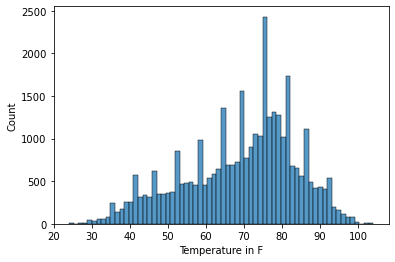

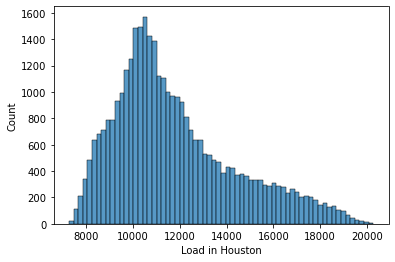

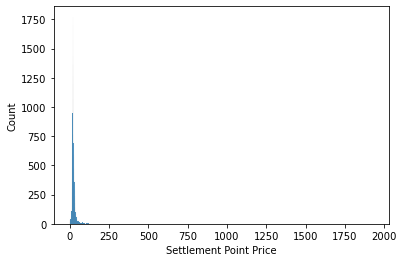

In [534]:
sns.histplot(load["Temperature in F"])
plt.show()
sns.histplot(load["Load in Houston"])
plt.show()
sns.histplot(load["Settlement Point Price"])
plt.show()


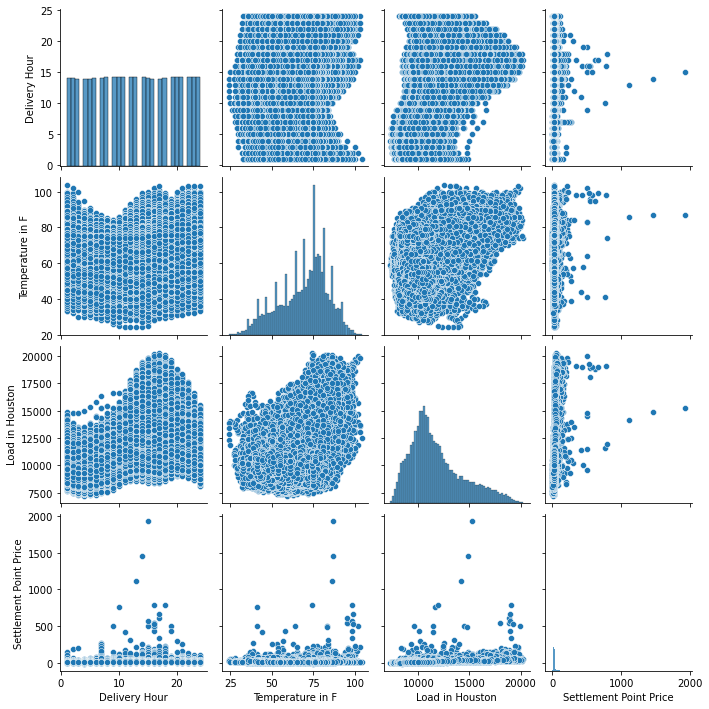

In [535]:
sns.pairplot(load)
plt.show()

In [536]:
# Removing "," from columns "Load in Houston" , "Ercot Load" and "Settlement Point Price"
load['Load in Houston'] = load['Load in Houston'].astype(str).str.replace(r',', '')
#load['Ercot Load'] = load['Ercot Load'].astype(str).str.replace(r',', '')
load['Settlement Point Price'] = load['Settlement Point Price'].astype(str).str.replace(r',', '')
load.head()

Delivery Date  Delivery Hour Repeated Hour Flag Settlement Point Name  \
0      1/1/2015              1                  N            LZ_HOUSTON   
1      1/1/2015              2                  N            LZ_HOUSTON   
2      1/1/2015              3                  N            LZ_HOUSTON   
3      1/1/2015              4                  N            LZ_HOUSTON   
4      1/1/2015              5                  N            LZ_HOUSTON   

  Settlement Point Type       DayStatus  Temperature in F Load in Houston  \
0                    LZ  Public Holiday                44          9844.2   
1                    LZ  Public Holiday                44         9653.46   
2                    LZ  Public Holiday                44          9502.3   
3                    LZ  Public Holiday                44         9474.48   
4                    LZ  Public Holiday                44         9554.37   

  Settlement Point Price  
0                  22.47  
1                  22.31  
2                   22.2  
3                  22.13  
4                  22.16

In [537]:
load['Settlement Point Price'] = load['Settlement Point Price'].astype(float)
load['Temperature in F'] = load['Temperature in F'].astype(float)
load['Load in Houston'] = load['Load in Houston'].astype(float)
#load['Ercot Load'] = load['Ercot Load'].astype(float)
load['Settlement Point Price'] = round(load['Settlement Point Price'],2)
load.dtypes
dataset = load.values

In [538]:
load.dtypes

import datetime
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year
load['day'] = pd.DatetimeIndex(load['Delivery Date']).day# Extracting Day from "Delivery Date"
load['month'] = pd.DatetimeIndex(load['Delivery Date']).month   # Extracting Month from "Delivery Date"


a = load['Delivery Date']
a= pd.to_datetime(a)

load['dayofweek'] = a.dt.dayofweek
load['dayofweek']

0        3
1        3
2        3
3        3
4        3
        ..
34633    0
34634    0
34635    0
34636    0
34637    0
Name: dayofweek, Length: 34638, dtype: int64

In [539]:
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year

In [540]:
load = load.set_index(['Delivery Date']) 
load = load.drop(columns=['year','day','Settlement Point Name','Settlement Point Type'], axis=1)  
# Re-arranging Columns
load = load[['dayofweek','month','Delivery Hour','Temperature in F','Load in Houston', 'Settlement Point Price']]
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  
Delivery Date                                           
1/1/2015               9844.20                   22.47  
1/1/2015               9653.46                   22.31  
1/1/2015               9502.30                   22.20  
1/1/2015               9474.48                   22.13  
1/1/2015               9554.37                   22.16

In [541]:
load['Load in Houston'].describe()

count    34638.000000
mean     11792.815830
std       2597.047989
min       7261.200000
25%       9953.645000
50%      11148.325000
75%      13203.805000
max      20269.850000
Name: Load in Houston, dtype: float64

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


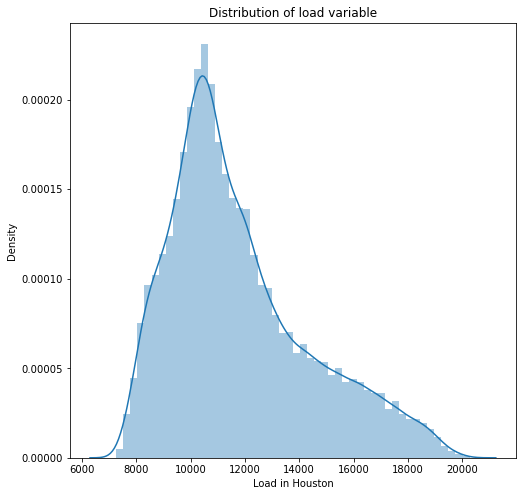

In [542]:
plt.figure(figsize=(8,8))
sns.distplot(load['Load in Houston'])
plt.xlabel("Load in Houston")
plt.title("Distribution of load variable")
plt.show()

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


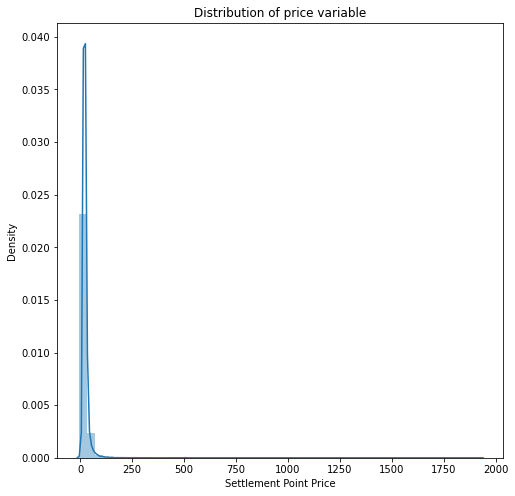

In [543]:
plt.figure(figsize=(8,8))
sns.distplot(load['Settlement Point Price'])
plt.xlabel("Settlement Point Price")
plt.title("Distribution of price variable")
plt.show()

As we can see our price variable heavily skewed and not much of insights can be gathered from the above plot. Hence we will use log transformation.

In [544]:
import numpy as np
import pandas as pd

# # Assuming 'load' is your pandas DataFrame
# load['Settlement Point Price'] = pd.to_numeric(load['Settlement Point Price'], errors='coerce')
# load['price_transform'] = np.log1p(load['Settlement Point Price'])

In [545]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  
Delivery Date                                           
1/1/2015               9844.20                   22.47  
1/1/2015               9653.46                   22.31  
1/1/2015               9502.30                   22.20  
1/1/2015               9474.48                   22.13  
1/1/2015               9554.37                   22.16

In [546]:
# plt.figure(figsize=(8,8))
# sns.distplot(load['price_transform'])
# plt.xlabel("price_transform")
# plt.title("Distribution of transformed price variable")
# plt.show()

# Lets check the hour wise usage and price of power

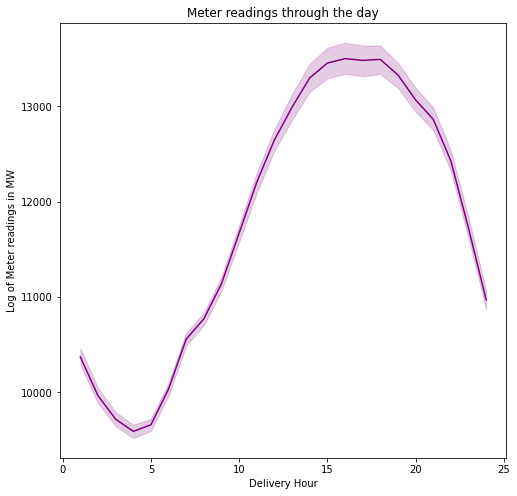

In [547]:
# plt.figure(figsize=(8,8))
# hour_df= load.groupby(['Delivery Date','Delivery Hour'])['Load in Houston'].mean().reset_index()
# sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Load in Houston'], color='purple')
# plt.ylabel("Log of Meter readings")
# plt.title("Meter readings through the day")
# plt.show()

load['Load in Houston'] = pd.to_numeric(load['Load in Houston'], errors='coerce')

plt.figure(figsize=(8, 8))
hour_df = load.groupby(['Delivery Date', 'Delivery Hour'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Load in Houston'], color='purple')
plt.ylabel("Log of Meter readings in MW")
plt.title("Meter readings through the day")
plt.show()

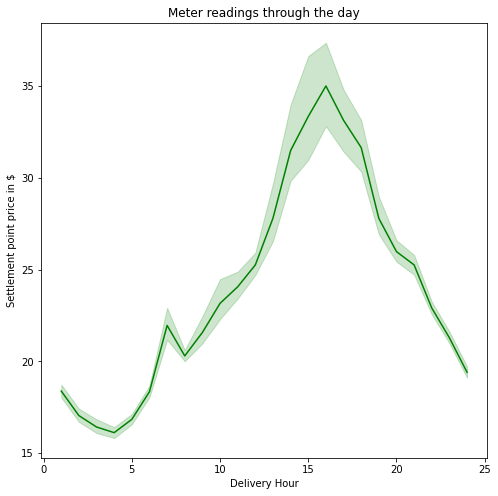

In [548]:
# plt.figure(figsize=(8,8))
# hour_df= load.groupby(['Delivery Date','Delivery Hour'])['Load in Houston'].mean().reset_index()
# sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Load in Houston'], color='purple')
# plt.ylabel("Log of Meter readings")
# plt.title("Meter readings through the day")
# plt.show()


plt.figure(figsize=(8, 8))
hour_df = load.groupby(['Delivery Date', 'Delivery Hour'])['Settlement Point Price'].mean().reset_index()
sns.lineplot(x=hour_df['Delivery Hour'], y=hour_df['Settlement Point Price'], color='green')
plt.ylabel("Settlement point price in $")
plt.title("Meter readings through the day")
plt.show()

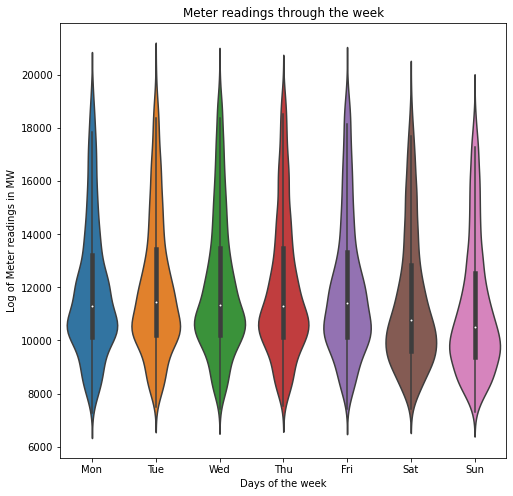

In [549]:
#Lets check the day wise usage of power
plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.violinplot(x=load['dayofweek'], y=load['Load in Houston'], pallete='muted')
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log of Meter readings in MW")
plt.title("Meter readings through the week")
plt.show()

There is not much of a difference in day to day basis of usage. Still, sundays have the lowest usage as we know most of the companies and educational institutions are closed on sunday.

 # Average monthly usage

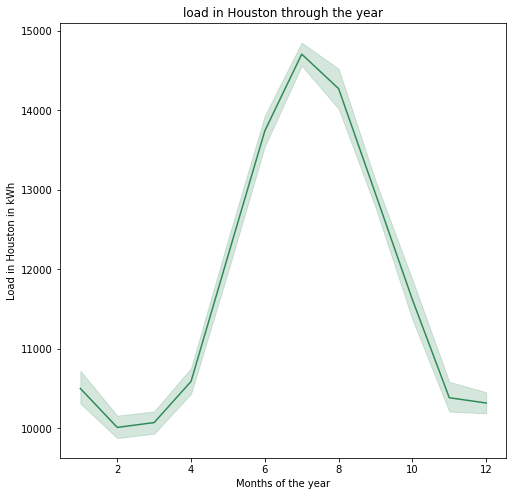

In [550]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','month'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['Load in Houston'], color='seagreen')
plt.xlabel("Months of the year")
plt.ylabel("Load in Houston in kWh")
plt.title("load in Houston through the year")
plt.show()

The average monthly consumption is minimal in the initial months and then rises after March in the onset of spring. It peaks in July and starts dropping again in the Autumn and winter months.

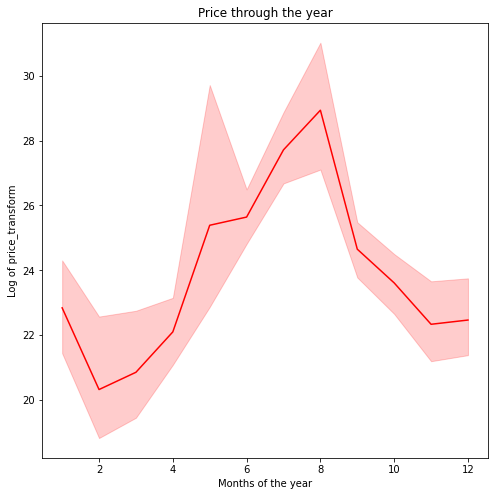

In [551]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','month'])['Settlement Point Price'].mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['Settlement Point Price'], color='red')
plt.xlabel("Months of the year")
plt.ylabel("Log of price_transform")
plt.title("Price through the year")
plt.show()

As we can that the price column is following a similar pattern of load in Houston.

# Lets check the Distribution Plot: Temperature

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


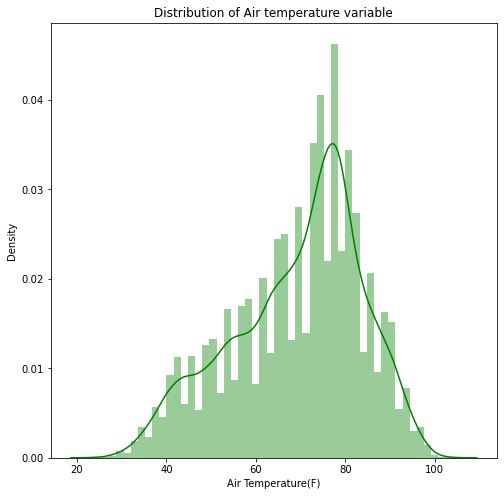

In [552]:
plt.figure(figsize=(8,8))
sns.distplot(load['Temperature in F'].dropna(), color='green')
plt.xlabel("Air Temperature(F)")
plt.title("Distribution of Air temperature variable")
plt.show()

The air temperature roughly follows a normal distribution. The maximum observations lie between 70-80 deg F.

### 3.12 Mean meter readings by air temperature

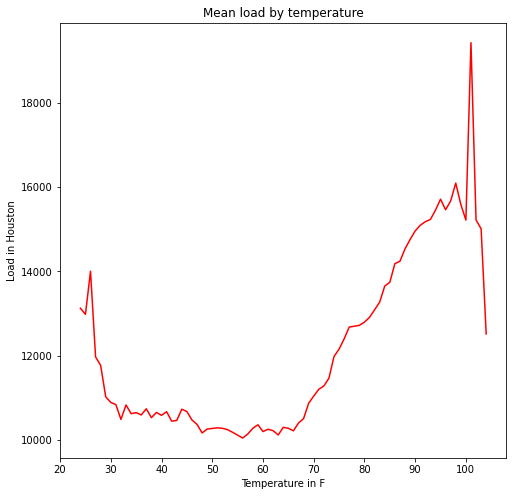

In [553]:
plt.figure(figsize=(8,8))
temp_df= load.groupby('Temperature in F')['Load in Houston'].mean().reset_index()
sns.lineplot(x=temp_df['Temperature in F'], y=temp_df['Load in Houston'], color='red')
plt.ylabel("Load in Houston")
plt.title("Mean load by temperature")
plt.show()

The average meter readings are high when the temperature is negative, once it starts increasing, the meter consumption reduces. It again spikes when the temperature rises above 70 deg F.

In [554]:
print(load[load['Load in Houston'] == load['Load in Houston'].max()])

               dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
8/21/2018              1      8             17              74.0   

               Load in Houston  Settlement Point Price  
Delivery Date                                           
8/21/2018             20269.85                   56.79  


In [555]:
load.iloc[:1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 1/1/2015 to 1/1/2015
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dayofweek               1 non-null      int64  
 1   month                   1 non-null      int64  
 2   Delivery Hour           1 non-null      int64  
 3   Temperature in F        1 non-null      float64
 4   Load in Houston         1 non-null      float64
 5   Settlement Point Price  1 non-null      float64
dtypes: float64(3), int64(3)
memory usage: 56.0+ bytes


### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

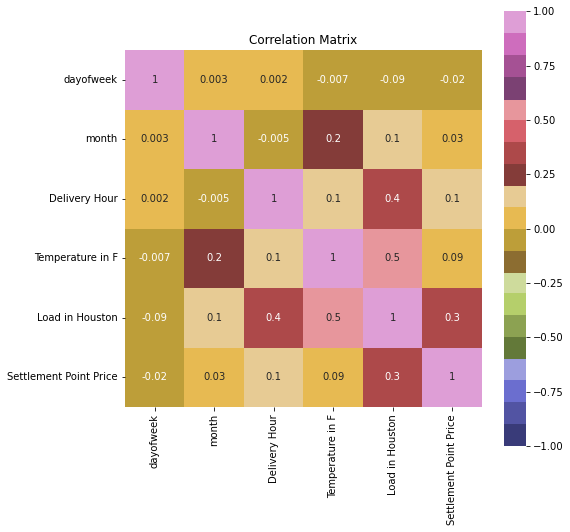

In [556]:
#Correlation Matrix
plt.figure(figsize=(8,8))
sns.heatmap(load.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, square=True, cmap='tab20b')
plt.title('Correlation Matrix')

As we can see that Temperature and Load in Houston as positive correlation. Temperature plays a significant impact on the energy demand.

#  Feature Engineering

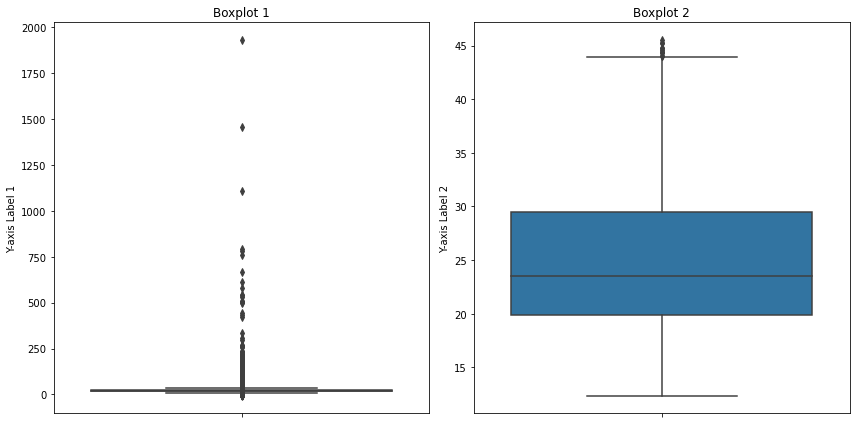

In [557]:
# Assuming you have a DataFrame called 'df'
# here we considered to remove any irregularities in the data
def remove_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]
target_variable_withoutoutliers=remove_outliers_iqr(predictions['Settlement Point Price'])
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first boxplot in the first subplot
sns.boxplot(y=load["Settlement Point Price"], ax=axs[0])
axs[0].set_title("Boxplot 1")
axs[0].set_ylabel("Y-axis Label 1")

# Plot the second boxplot in the second subplot
sns.boxplot(y=target_variable_withoutoutliers, ax=axs[1])
axs[1].set_title("Boxplot 2")
axs[1].set_ylabel("Y-axis Label 2")

# Adjust spacing between subplots
plt.tight_layout()


### Missing Value Imputation

In [558]:
#Check percentage of missing values in each column
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

In [559]:
missing_value_train= percent_missing_val(load)

In [560]:
missing_value_train

column_name  percent_missing
dayofweek                            dayofweek              0.0
month                                    month              0.0
Delivery Hour                    Delivery Hour              0.0
Temperature in F              Temperature in F              0.0
Load in Houston                Load in Houston              0.0
Settlement Point Price  Settlement Point Price              0.0

In [561]:
load.reset_index()['Delivery Date']

0          1/1/2015
1          1/1/2015
2          1/1/2015
3          1/1/2015
4          1/1/2015
            ...    
34633    12/31/2018
34634    12/31/2018
34635    12/31/2018
34636    12/31/2018
34637    12/31/2018
Name: Delivery Date, Length: 34638, dtype: object

No missing value 

In [562]:
#adding season features
load['season']= load['month'].apply(lambda x: 'Spring' if x==3 or x==4 or x==5 else 'Summer' if 
                                                x==6 or x==7 or x==8 
                                                else 'Autumn' if x==9 or x==10 or 
                                                x==11 else 'Winter')

In [563]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  
Delivery Date                                                   
1/1/2015               9844.20                   22.47  Winter  
1/1/2015               9653.46                   22.31  Winter  
1/1/2015               9502.30                   22.20  Winter  
1/1/2015               9474.48                   22.13  Winter  
1/1/2015               9554.37                   22.16  Winter

In [564]:
#Adding day and night period features
load['IsDayTime']= load['Delivery Hour'].apply(lambda x: 1 if x >=6 and x <=18 else 0)

In [565]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  IsDayTime  
Delivery Date                                                              
1/1/2015               9844.20                   22.47  Winter          0  
1/1/2015               9653.46                   22.31  Winter          0  
1/1/2015               9502.30                   22.20  Winter          0  
1/1/2015               9474.48                   22.13  Winter          0  
1/1/2015               9554.37                   22.16  Winter          0

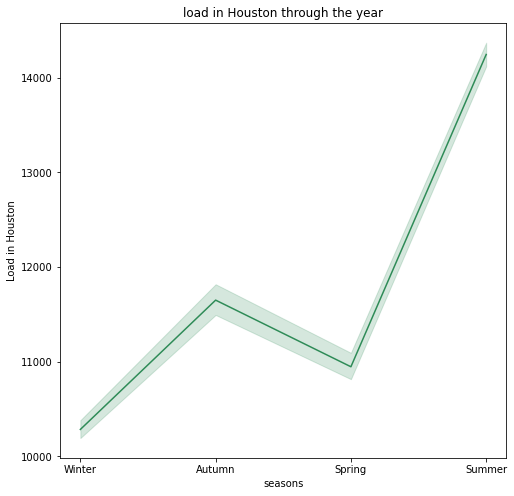

In [566]:
#Lets check the season wise usage of power
plt.figure(figsize=(8,8))
month_df= load.groupby(['Delivery Date','season'])['Load in Houston'].mean().reset_index()
sns.lineplot(x=month_df['season'], y=month_df['Load in Houston'], color='seagreen')
plt.xlabel("seasons")
plt.ylabel("Load in Houston")
plt.title("load in Houston through the year")
plt.show()

Text(0.5, 1.0, 'Average meter readings by meter types')

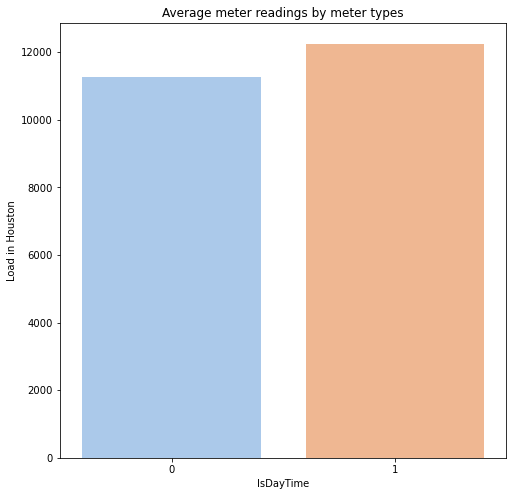

In [567]:

plt.figure(figsize=(8,8))
meter_df= load.groupby('IsDayTime')['Load in Houston'].mean().reset_index()
ax= sns.barplot(x='IsDayTime', y='Load in Houston', data=meter_df, palette='pastel')
plt.title("Average meter readings by meter types")

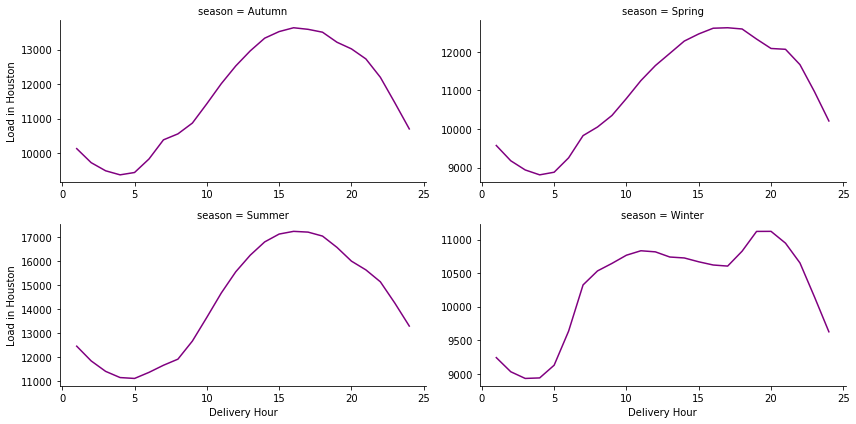

In [568]:
#Hourly average readings based on type of buildings
hour_use_df= load.groupby(['Delivery Hour', 'season'])['Load in Houston'].mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='season', col_wrap=2, height=3, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'Delivery Hour', 'Load in Houston', color='purple')
plt.show()

# Stacked LSTM

In [569]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  IsDayTime  
Delivery Date                                                              
1/1/2015               9844.20                   22.47  Winter          0  
1/1/2015               9653.46                   22.31  Winter          0  
1/1/2015               9502.30                   22.20  Winter          0  
1/1/2015               9474.48                   22.13  Winter          0  
1/1/2015               9554.37                   22.16  Winter          0

In [570]:
# hour based prediction

past_hours = 2
n_steps = past_hours
next_hours = 2
next_steps = next_hours


In [571]:
# data transforming for the LSTM
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([("1",OneHotEncoder(sparse=False),make_column_selector(pattern = 'month')),
                             ("2",OneHotEncoder(sparse=False),make_column_selector(pattern = 'dayofweek')),
                             ("3",OneHotEncoder(sparse=False),make_column_selector(pattern = 'Delivery Hour')),
                             ("7",StandardScaler(copy=True), make_column_selector(pattern = 'Temperature in F')),
                             ("8",StandardScaler(copy=True), make_column_selector(pattern = 'Load in Houston')),
                             ("y",QuantileTransformer(copy=True), make_column_selector(pattern = 'Settlement Point Price'))])

# QuantileTransformer transformer is used for'Settlement Point Price'. It transforms the target variable using quantiles, 
# mapping it to a uniform or Gaussian distribution. This can be helpful when the target variable has a skewed distribution 
# or when you want to reduce the impact of outliers.

In [572]:
import numpy
dataset=load.values
#numpy.around(dataset, decimals=2, out=None)


In [573]:
normed_data = ct.fit_transform(load)
print(normed_data.shape)

(34638, 46)


In [574]:
normed_data = pd.DataFrame(normed_data)
dataset = normed_data.values

In [575]:
dataset=numpy.around(dataset, decimals=5, out=None)
dataset

array([[ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.82378,  0.62513],
       [ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.88198,  0.62012],
       ...,
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.5402 ,  0.12346],
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.62114,  0.13914],
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.68715,  0.0996 ]])

In [576]:
dataset.shape

(34638, 46)

In [577]:
# reshaping the data for the LSTM input

series_reshaped =  np.array([dataset[i:i + (n_steps+next_steps)].copy() for i in range(len(dataset) - (n_steps+next_steps))])
series_reshaped[0]



array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     , -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,

In [578]:
series_reshaped.shape

(34634, 4, 46)

In [579]:
a = series_reshaped.shape[0]
b = int(0.9*a)
c = int(a-b)
d = int(c/2)

In [580]:
X_train = series_reshaped[:b, :n_steps]
X_val = series_reshaped[b:, :n_steps]

print(X_train.shape, X_val.shape)

(31170, 2, 46) (3464, 2, 46)


In [581]:
Y = np.empty((series_reshaped.shape[0], next_steps))
Y.shape

(34634, 2)

In [582]:
Y = np.empty((series_reshaped.shape[0], next_steps))
for step_ahead in range(0, next_steps):
    Y[..., step_ahead] = series_reshaped[..., (step_ahead+n_steps-next_steps+1), (X_train.shape[2]-1)]


In [583]:
Y_train = Y[:b]
Y_val = Y[b:]

In [584]:
print(Y_train.shape, Y_val.shape)

(31170, 2) (3464, 2)


In [585]:
X_train[0]

array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     , -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,

In [586]:
Y_train[0]

array([0.62513, 0.62012])

In [587]:
#  we find the best Weights and Biases using backpropagation, just like for any other neural network
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(224, return_sequences=True),
    Flatten(),
    #Dense(256, activation = "relu"),
    Dense(128, activation="relu"),
    #Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2), 
    Dense(next_steps)
])

#  Dropout is a regularization technique that randomly sets a fraction of input units to 0 during training, which helps prevent overfitting
# Flatten 3d to 2d
# return srquence returns the full sequence of output rather than the last output

In [588]:
from kerastuner.tuners import RandomSearch 

In [589]:
print(Y_train)

[[0.62513 0.62012]
 [0.62012 0.61612]
 [0.61612 0.61812]
 ...
 [0.94955 0.91948]
 [0.91948 0.90611]
 [0.90611 0.88375]]


In [590]:
from tensorflow.keras.callbacks import EarlyStopping
def build_lstm_model(hp):
    model_s = Sequential()
    model_s.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=256, step=32),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_s.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=256, step=32),
                   return_sequences=True))
    model_s.add(Flatten())
    model_s.add(Dense(units=hp.Int('dense_units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model_s.add(Dense(units=hp.Int('dense_units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model_s.add(Dropout(rate=hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))
    model_s.add(Dense(next_steps))
    model_s.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model_s

# Initialize the tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_directory',  # Directory to save the tuning results
    project_name='lstm_tuning'  # Name of the tuning project
)

# Search for the best hyperparameters
tuner.search(X_train.reshape(-1, X_train.shape[1], X_train.shape[2]), Y_train,
             epochs=100,  # Number of epochs for each trial
             validation_data=(X_val.reshape(-1, X_val.shape[1], X_val.shape[2]), Y_val),
             batch_size=16,  # Batch size for each trial
             callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],  # Early stopping callback
             verbose=1)

# Get the best model architecture
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()



INFO:tensorflow:Reloading Tuner from tuner_directory\lstm_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 32)             10112     
                                                                 
 lstm_1 (LSTM)               (None, 2, 160)            123520    
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 288)               92448     
                                                                 
 dense_1 (Dense)             (None, 448)               129472    
                                                                 
 dropout (Dropout)           (None, 448)               0         
       

In [591]:
# Train the best model on the full training data
bestmodel=best_model.fit(X_train.reshape(-1, X_train.shape[1], X_train.shape[2]), Y_train,
               epochs=100, batch_size=16,
               validation_data=(X_val.reshape(-1, X_val.shape[1], X_val.shape[2]), Y_val),
               callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)



Epoch 1/100
1949/1949 [==============================] - 25s 10ms/step - loss: 0.0043 - mae: 0.0403 - val_loss: 0.0036 - val_mae: 0.0347
Epoch 2/100
1949/1949 [==============================] - 19s 10ms/step - loss: 0.0042 - mae: 0.0401 - val_loss: 0.0056 - val_mae: 0.0494
Epoch 3/100
1949/1949 [==============================] - 20s 10ms/step - loss: 0.0042 - mae: 0.0401 - val_loss: 0.0049 - val_mae: 0.0498
Epoch 4/100
1949/1949 [==============================] - 24s 12ms/step - loss: 0.0042 - mae: 0.0396 - val_loss: 0.0052 - val_mae: 0.0462
Epoch 5/100
1949/1949 [==============================] - 24s 12ms/step - loss: 0.0042 - mae: 0.0398 - val_loss: 0.0041 - val_mae: 0.0383
Epoch 6/100
1949/1949 [==============================] - 24s 12ms/step - loss: 0.0041 - mae: 0.0395 - val_loss: 0.0043 - val_mae: 0.0383
Epoch 7/100
1949/1949 [==============================] - 23s 12ms/step - loss: 0.0041 - mae: 0.0395 - val_loss: 0.0043 - val_mae: 0.0383
Epoch 8/100
1949/1949 [==================

In [592]:
# Evaluate the best model
eval_result = best_model.evaluate(X_val.reshape(-1, X_val.shape[1], X_val.shape[2]), Y_val)
print("Validation Loss:", eval_result)

109/109 [==============================] - 0s 4ms/step - loss: 0.0036 - mae: 0.0347
Validation Loss: [0.003588014282286167, 0.03470976650714874]


In [593]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  IsDayTime  
Delivery Date                                                              
1/1/2015               9844.20                   22.47  Winter          0  
1/1/2015               9653.46                   22.31  Winter          0  
1/1/2015               9502.30                   22.20  Winter          0  
1/1/2015               9474.48                   22.13  Winter          0  
1/1/2015               9554.37                   22.16  Winter          0

In [594]:
from tensorflow.keras.layers import Input

In [595]:
stacked_lstm_input = Input(shape=(X_train.shape[1],X_train.shape[2]))

In [596]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
# learning rate schedule that exponentially decays the learning rate over time during training
# initial_learning_rate = 0.0005
# decay_steps: The number of steps it takes for the learning rate to decay
# decay_rate: learning rate decays. In this case, it is set to 0.98, meaning the learning rate decreases by 2% at each step.
# Staircase= False learning rate decays continuously or else in a discrete manner

In [597]:
from tensorflow import keras
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

# minimize the loss function Adam combines the concepts of momentum optimization and RMSProp
# exponential decay rate is by default set to 0.9, but in this case, it has been customized to 1e-6.

In [598]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [599]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 256)            310272    
                                                                 
 lstm_1 (LSTM)               (None, 2, 224)            430976    
                                                                 
 flatten_1 (Flatten)         (None, 448)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               57472     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [600]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# patience : number of epochs with no improvement in the monitored metric (val_loss)

In [601]:
example_batch= X_val[0:10]
example_batch.shape

(10, 2, 46)

In [602]:
example_result = model.predict(example_batch)
example_result.shape

1/1 [==============================] - 1s 939ms/step


(10, 2)

In [603]:
example_result

array([[ 0.00547163,  0.00799518],
       [ 0.0069464 ,  0.00872572],
       [ 0.00535768,  0.0048749 ],
       [ 0.00137609,  0.00188059],
       [ 0.00383562,  0.00241648],
       [ 0.00153854,  0.00134441],
       [ 0.00096841,  0.00047742],
       [ 0.00248772, -0.00063918],
       [ 0.00051019,  0.00095456],
       [ 0.00039947, -0.00039426]], dtype=float32)

In [604]:
len(example_result)

10

In [605]:
last_list=[]

for i in range (0, len(example_result)):
  last_list.append((example_result[i][0]))

last_list

[0.0054716347,
 0.006946399,
 0.005357676,
 0.0013760922,
 0.0038356162,
 0.0015385386,
 0.00096841075,
 0.0024877198,
 0.0005101929,
 0.00039947178]

In [606]:
len(last_list)

10

In [607]:
import datetime
print(datetime.datetime.now())

2023-09-11 12:24:50.383761


In [608]:
EPOCHS = 2000

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1, 
    callbacks=[early_stop])

Epoch 1/2000
975/975 [==============================] - 31s 26ms/step - loss: 0.0256 - mae: 0.1164 - mse: 0.0256 - val_loss: 0.0116 - val_mae: 0.0815 - val_mse: 0.0116
Epoch 2/2000
975/975 [==============================] - 24s 25ms/step - loss: 0.0118 - mae: 0.0789 - mse: 0.0118 - val_loss: 0.0052 - val_mae: 0.0500 - val_mse: 0.0052
Epoch 3/2000
975/975 [==============================] - 18s 19ms/step - loss: 0.0091 - mae: 0.0684 - mse: 0.0091 - val_loss: 0.0188 - val_mae: 0.1120 - val_mse: 0.0188
Epoch 4/2000
975/975 [==============================] - 20s 21ms/step - loss: 0.0083 - mae: 0.0649 - mse: 0.0083 - val_loss: 0.0271 - val_mae: 0.1344 - val_mse: 0.0271
Epoch 5/2000
975/975 [==============================] - 23s 23ms/step - loss: 0.0076 - mae: 0.0619 - mse: 0.0076 - val_loss: 0.0119 - val_mae: 0.0871 - val_mse: 0.0119
Epoch 6/2000
975/975 [==============================] - 21s 21ms/step - loss: 0.0071 - mae: 0.0596 - mse: 0.0071 - val_loss: 0.0053 - val_mae: 0.0511 - val_mse:

In [609]:
import datetime
b=datetime.datetime.now()
b

datetime.datetime(2023, 9, 11, 12, 32, 20, 408917)

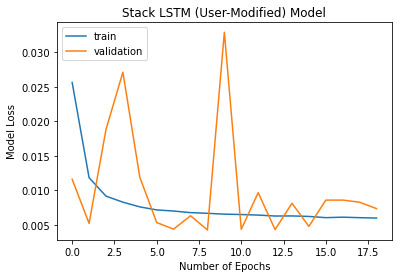

In [610]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stack LSTM (User-Modified) Model')
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

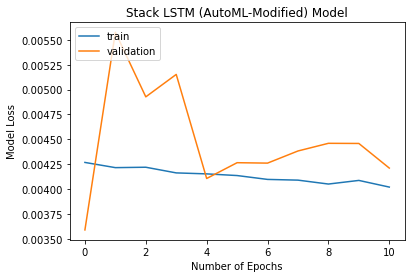

In [611]:
import matplotlib.pyplot as plt
plt.plot(bestmodel.history['loss'])
plt.plot(bestmodel.history['val_loss'])
plt.title('Stack LSTM (AutoML-Modified) Model')
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

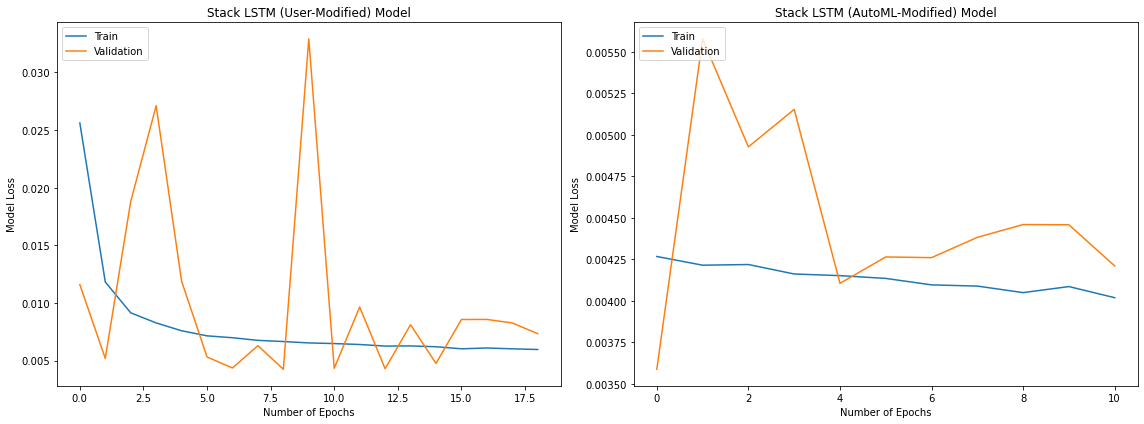

In [612]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the model loss for the first dataset on the left subplot
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Stack LSTM (User-Modified) Model')
ax1.set_ylabel('Model Loss')
ax1.set_xlabel('Number of Epochs')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the model loss for the second dataset on the right subplot
ax2.plot(bestmodel.history['loss'])
ax2.plot(bestmodel.history['val_loss'])
ax2.set_title('Stack LSTM (AutoML-Modified) Model')
ax2.set_ylabel('Model Loss')
ax2.set_xlabel('Number of Epochs')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.tight_layout()
plt.show()

In [613]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  IsDayTime  
Delivery Date                                                              
1/1/2015               9844.20                   22.47  Winter          0  
1/1/2015               9653.46                   22.31  Winter          0  
1/1/2015               9502.30                   22.20  Winter          0  
1/1/2015               9474.48                   22.13  Winter          0  
1/1/2015               9554.37                   22.16  Winter          0

In [614]:

test_predictions_b = best_model.predict(X_val)
op_lists= []
for i in range (0, len(test_predictions_b)):
  op_lists.append((test_predictions_b[i][1]))
len(op_lists)

109/109 [==============================] - 1s 4ms/step


3464

In [615]:
op_lists

[0.8469473,
 0.73725617,
 0.5555208,
 0.3934771,
 0.265863,
 0.23852813,
 0.23092,
 0.2368151,
 0.28781328,
 0.3612734,
 0.3917299,
 0.51368916,
 0.6016394,
 0.6291422,
 0.78609884,
 0.8972813,
 0.95253074,
 0.9632837,
 0.9441896,
 0.8923979,
 0.8550762,
 0.8176508,
 0.8577486,
 0.8794221,
 0.8065096,
 0.68298566,
 0.50866103,
 0.43584678,
 0.3264908,
 0.26950246,
 0.3077256,
 0.26359367,
 0.39718828,
 0.45568153,
 0.4391057,
 0.529423,
 0.7540683,
 0.86884177,
 0.90543604,
 0.94852674,
 1.0050838,
 0.99593186,
 1.000294,
 0.9438157,
 0.87417984,
 0.879884,
 0.8948512,
 0.8456244,
 0.7617954,
 0.6240443,
 0.59586453,
 0.5376795,
 0.4822442,
 0.49855602,
 0.49085206,
 0.5215851,
 0.56826293,
 0.565356,
 0.7368328,
 0.8610729,
 0.8290266,
 0.86668605,
 0.89968675,
 0.92511755,
 0.9180782,
 0.9219718,
 0.91727304,
 0.90007794,
 0.8656623,
 0.8492347,
 0.8434732,
 0.8099154,
 0.7537581,
 0.58941185,
 0.660894,
 0.6905071,
 0.58366597,
 0.5735386,
 0.5546742,
 0.57048345,
 0.5471173,
 0.480

In [616]:
test_predictions = model.predict(X_val)
op_list= []
for i in range (0, len(test_predictions)):
  op_list.append((test_predictions[i][1]))
len(op_list)

109/109 [==============================] - 1s 7ms/step


3464

In [617]:
op_list

[0.7002711,
 0.5897365,
 0.49190763,
 0.35315096,
 0.2863026,
 0.27016366,
 0.25116304,
 0.27168867,
 0.2777245,
 0.37658942,
 0.39484492,
 0.49419153,
 0.5632744,
 0.59733045,
 0.7587315,
 0.8361159,
 0.8642556,
 0.8823671,
 0.8640617,
 0.8126906,
 0.7917785,
 0.7650773,
 0.76170117,
 0.77444196,
 0.67592674,
 0.5619749,
 0.46163604,
 0.39417815,
 0.31974775,
 0.2944451,
 0.3177364,
 0.29184282,
 0.38084483,
 0.4704939,
 0.45961535,
 0.49618238,
 0.7077415,
 0.80511796,
 0.83127856,
 0.8649484,
 0.8922674,
 0.8948754,
 0.8954634,
 0.83196634,
 0.79242396,
 0.7800693,
 0.79108906,
 0.7047851,
 0.6202061,
 0.5504254,
 0.52064943,
 0.480381,
 0.4681639,
 0.47005957,
 0.48648387,
 0.48564795,
 0.59822524,
 0.5642324,
 0.6677299,
 0.78199714,
 0.7585855,
 0.79942465,
 0.82175875,
 0.8337178,
 0.8401575,
 0.83901775,
 0.8331742,
 0.7995554,
 0.7835101,
 0.7324939,
 0.74242395,
 0.68710893,
 0.62957215,
 0.52464914,
 0.5546554,
 0.589547,
 0.53709894,
 0.52345586,
 0.5460997,
 0.5098923,
 0.

In [618]:
test_labels = pd.DataFrame({'Settlement Point Price':(Y_val[:,1])})
#test_labels.rename(columns = {(Y_test.shape[1]):'actual'}, inplace = True)
#test_labels['actual']
test_labels['Settlement Point Price']

0       0.81502
1       0.67267
2       0.46096
3       0.33333
4       0.28428
         ...   
3459    0.62713
3460    0.60561
3461    0.57658
3462    0.30244
3463    0.12346
Name: Settlement Point Price, Length: 3464, dtype: float64

In [619]:
np.reshape(test_labels, (-1,1))
test_labels.shape

(3464, 1)

In [620]:
test_labels['Settlement Point Price']=ct.named_transformers_['y'].inverse_transform(test_labels)
test_labels['Settlement Point Price']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: Settlement Point Price, Length: 3464, dtype: float64

In [621]:
predictions=pd.DataFrame({'Settlement Point Price':op_list})
predictions['Settlement Point Price'] = ct.named_transformers_['y'].inverse_transform(predictions)

In [622]:
predictions['Settlement Point Price']

0       24.127127
1       21.673355
2       20.334158
3       18.997978
4       18.330162
          ...    
3459    22.592648
3460    23.100527
3461    20.866154
3462    21.059151
3463    17.914576
Name: Settlement Point Price, Length: 3464, dtype: float32

In [623]:
predictions_b=pd.DataFrame({'Settlement Point Price':op_lists})
predictions_b['Settlement Point Price'] = ct.named_transformers_['y'].inverse_transform(predictions_b)

In [624]:
predictions_b['Settlement Point Price']

0       29.706022
1       25.235567
2       21.139652
3       19.360836
4       18.105972
          ...    
3459    22.639637
3460    22.874750
3461    21.024414
3462    20.981911
3463    17.617834
Name: Settlement Point Price, Length: 3464, dtype: float32

In [625]:
test_labels['Settlement Point Price']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: Settlement Point Price, Length: 3464, dtype: float64

In [626]:
# here we considered to remove any irregularities in the data
def remove_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 2.0 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]
predictions_outliers=remove_outliers_iqr(predictions['Settlement Point Price'])
predictions_b_outliers=remove_outliers_iqr(predictions_b['Settlement Point Price'])
test_labels_a=remove_outliers_iqr(test_labels['Settlement Point Price'])

In [627]:
#  sns.boxplot(y=predictions['Settlement Point Price'])

In [628]:
#  sns.boxplot(y=predictions_outliers)

In [629]:
#  sns.boxplot(y=predictions_b['Settlement Point Price'])

In [630]:
#  sns.boxplot(y=predictions_b_outliers)

In [631]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Sample data (replace with your actual data)
# data1 = predictions_outliers
# data2 = predictions['Settlement Point Price']
# data3 = predictions_b['Settlement Point Price']
# data4 = predictions_b_outliers

# # Create a figure with two sets of subplots side by side
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the first set of boxplots in the first subplot
# sns.boxplot(data=[data1, data4], ax=axs[0])
# axs[0].set_title("Boxplots Set 1")
# axs[0].set_yticklabels(["Settlement Point Price", "Settlement Point Price"])

# # Plot the second set of boxplots in the second subplot
# sns.boxplot(data=[data2, data3], ax=axs[1])
# axs[1].set_title("Boxplots Set 2")
# axs[1].set_yticklabels(["Data 2", "Data 3"])

# # Adjust spacing between subplots
# plt.tight_layout()

# # Display the two sets of boxplots side by side
# plt.show()


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_11388\3564099699.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["User modified data without outliers","Settlement Point Price"])
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_11388\3564099699.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(["Data 2","Settlement Point Price"])


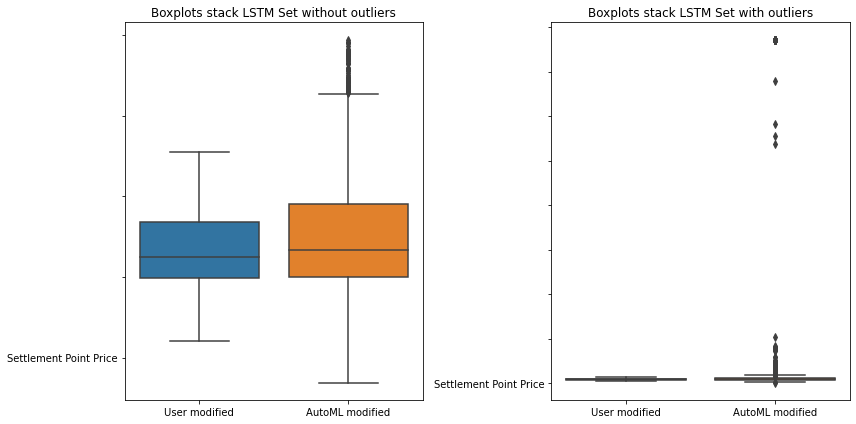

In [632]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
# user
data1 = predictions_outliers
data2 = predictions['Settlement Point Price']
data3 = predictions_b['Settlement Point Price']
data4 = predictions_b_outliers

# Create a figure with two sets of subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of boxplots in the first subplot
sns.boxplot(data=[data1, data4], ax=axs[0])
axs[0].set_title("Boxplots stack LSTM Set without outliers")
axs[0].set_yticklabels(["User modified data without outliers","Settlement Point Price"])
axs[0].set_xticklabels(["User modified", "AutoML modified"])

# Plot the second set of boxplots in the second subplot
sns.boxplot(data=[data2, data3], ax=axs[1])
axs[1].set_title("Boxplots stack LSTM Set with outliers")
axs[1].set_yticklabels(["Data 2","Settlement Point Price"])
axs[1].set_xticklabels(["User modified", "AutoML modified"])

# Adjust spacing between subplots
plt.tight_layout()

# Display the two sets of boxplots side by side
plt.show()


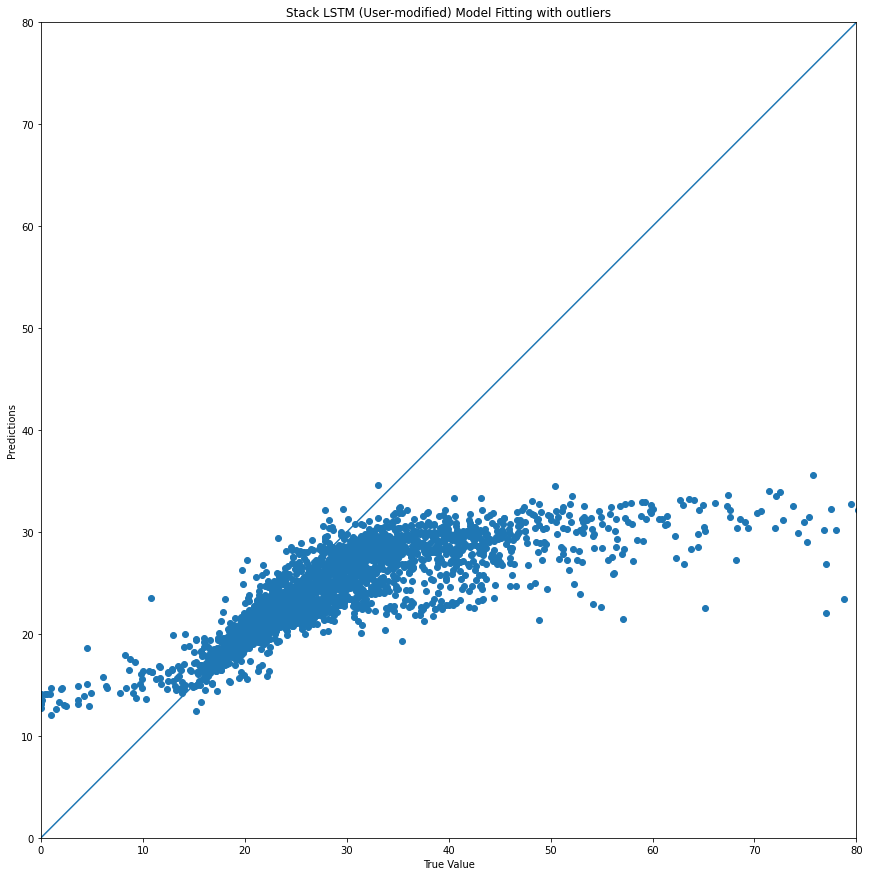

In [633]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'], predictions)
plt.title("Stack LSTM (User-modified) Model Fitting with outliers")
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

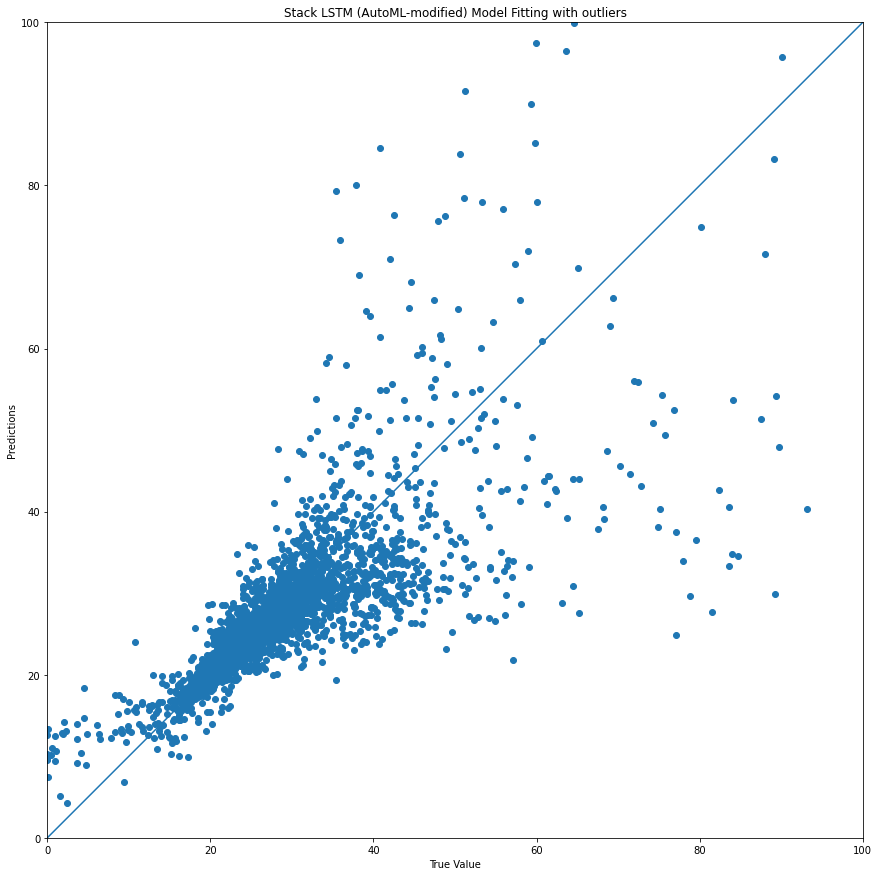

In [634]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'], predictions_b)
plt.title("Stack LSTM (AutoML-modified) Model Fitting with outliers")
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [635]:
len(predictions_outliers)

3464

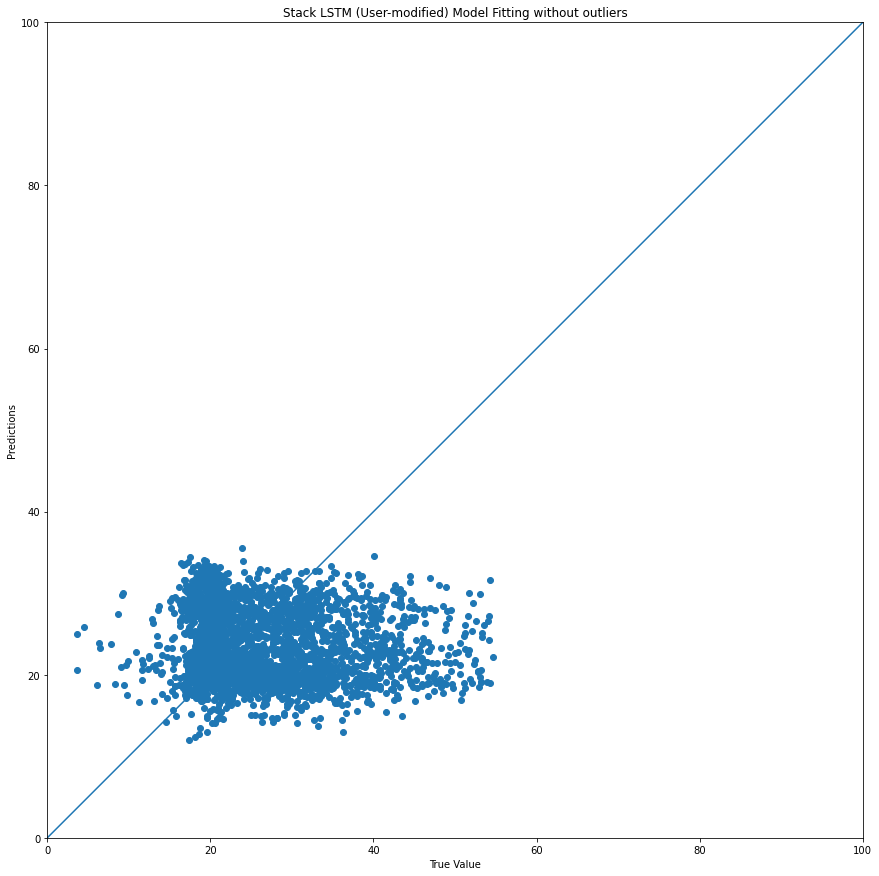

In [636]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels_a[:2976], predictions_outliers[:2976])
plt.title("Stack LSTM (User-modified) Model Fitting without outliers")
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

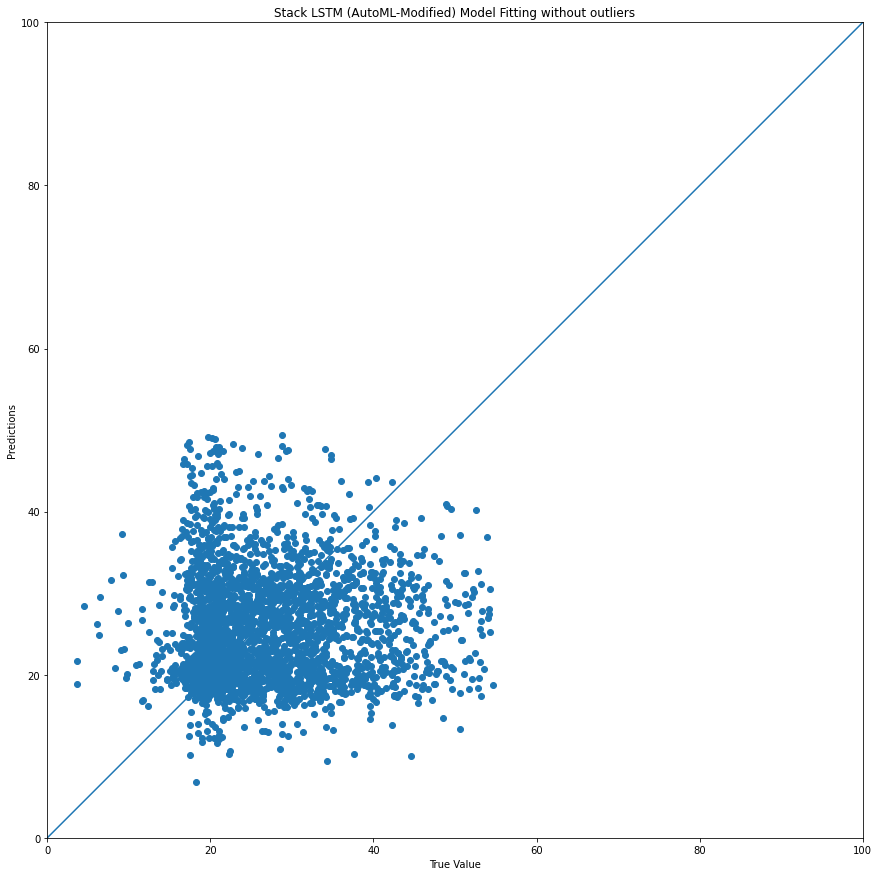

In [637]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels_a[:3000], predictions_b_outliers[:3000])
plt.title("Stack LSTM (AutoML-Modified) Model Fitting without outliers")
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

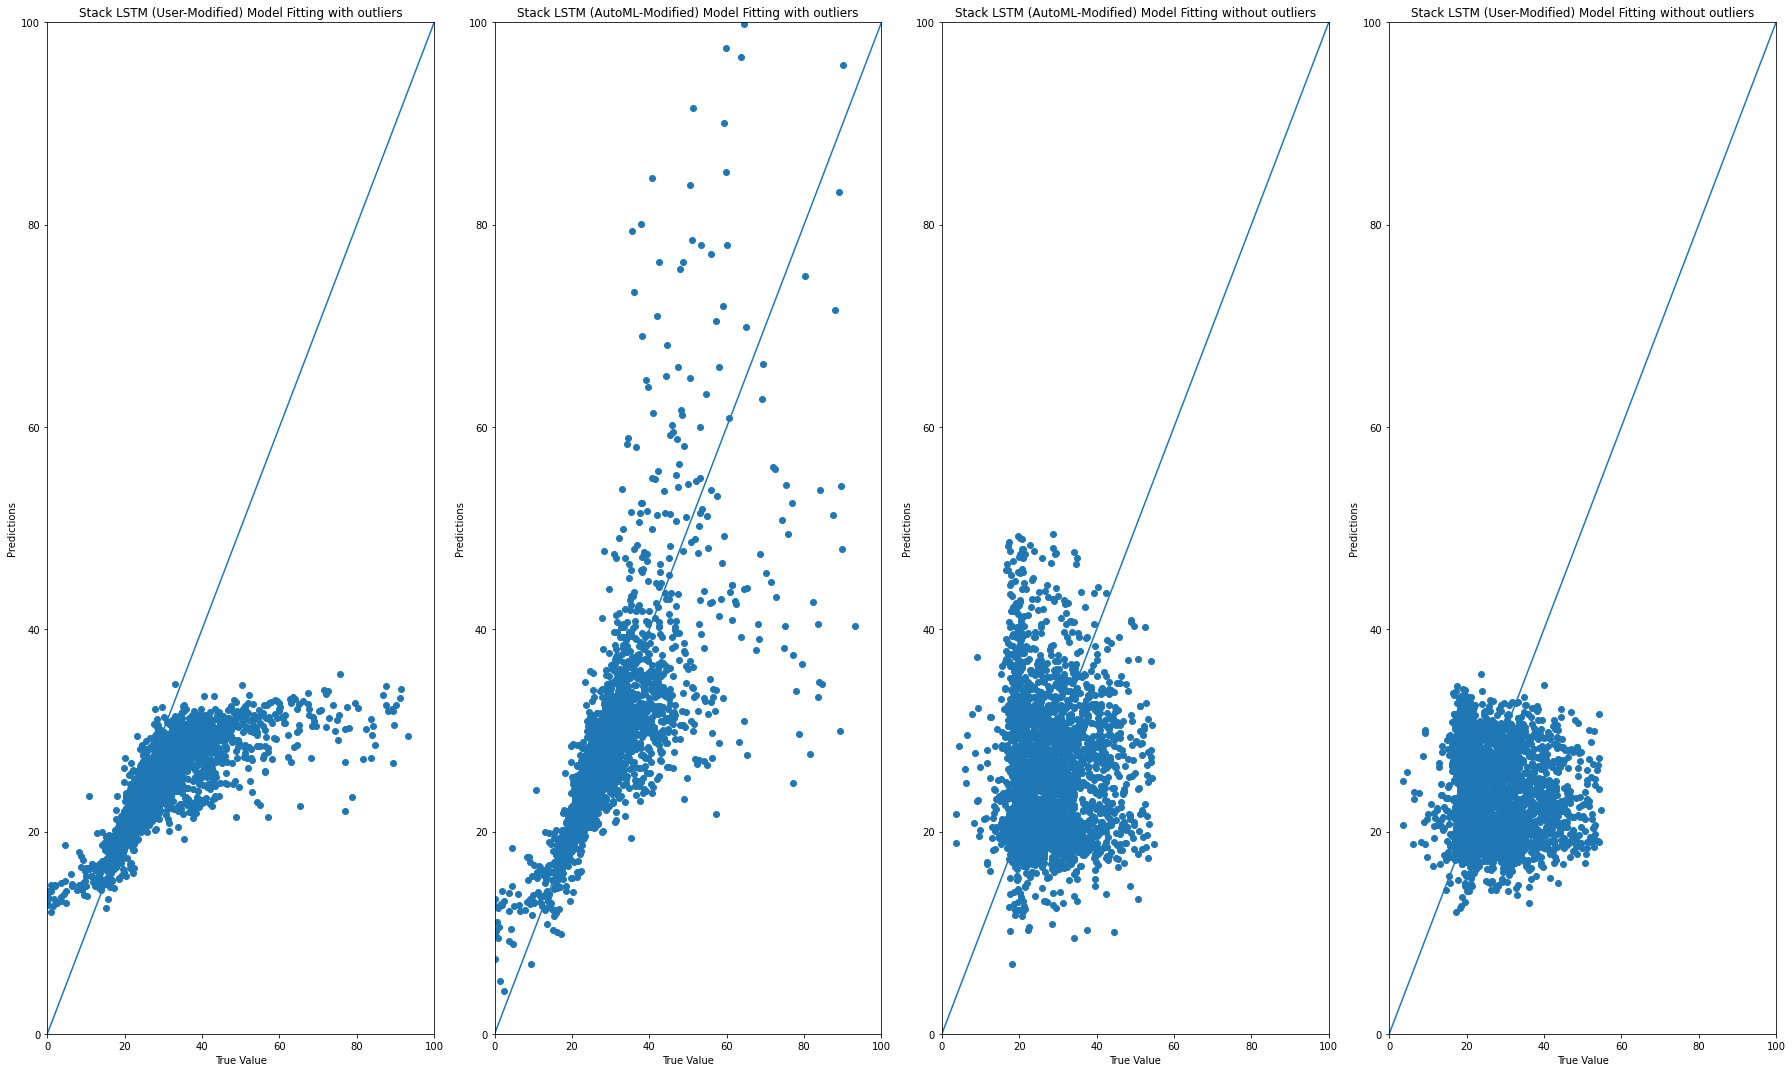

In [638]:
import matplotlib.pyplot as plt

# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 4, figsize=(25, 15))
lims = [0, 100]  # Set the common x and y-axis limits

# First subplot
axs[0].scatter(test_labels['Settlement Point Price'], predictions)
axs[0].set_title('Stack LSTM (User-Modified) Model Fitting with outliers')
axs[0].set_xlabel('True Value')
axs[0].set_ylabel('Predictions')
axs[0].set_xlim(lims)
axs[0].set_ylim(lims)
_ = axs[0].plot(lims, lims)

# Second subplot
axs[1].scatter(test_labels['Settlement Point Price'], predictions_b)
axs[1].set_title('Stack LSTM (AutoML-Modified) Model Fitting with outliers')
axs[1].set_xlabel('True Value')
axs[1].set_ylabel('Predictions')
axs[1].set_xlim(lims)
axs[1].set_ylim(lims)
_ = axs[1].plot(lims, lims)

# Third subplot
axs[2].scatter(test_labels_a[:3000], predictions_b_outliers[:3000])
axs[2].set_title('Stack LSTM (AutoML-Modified) Model Fitting without outliers')
axs[2].set_xlabel('True Value')
axs[2].set_ylabel('Predictions')
axs[2].set_xlim(lims)
axs[2].set_ylim(lims)
_ = axs[2].plot(lims, lims)


# Fourth subplot
axs[3].scatter(test_labels_a[:3000], predictions_outliers[:3000])
axs[3].set_title('Stack LSTM (User-Modified) Model Fitting without outliers')
axs[3].set_xlabel('True Value')
axs[3].set_ylabel('Predictions')
axs[3].set_xlim(lims)
axs[3].set_ylim(lims)
_ = axs[3].plot(lims, lims)
# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with subplots side by side
plt.show()


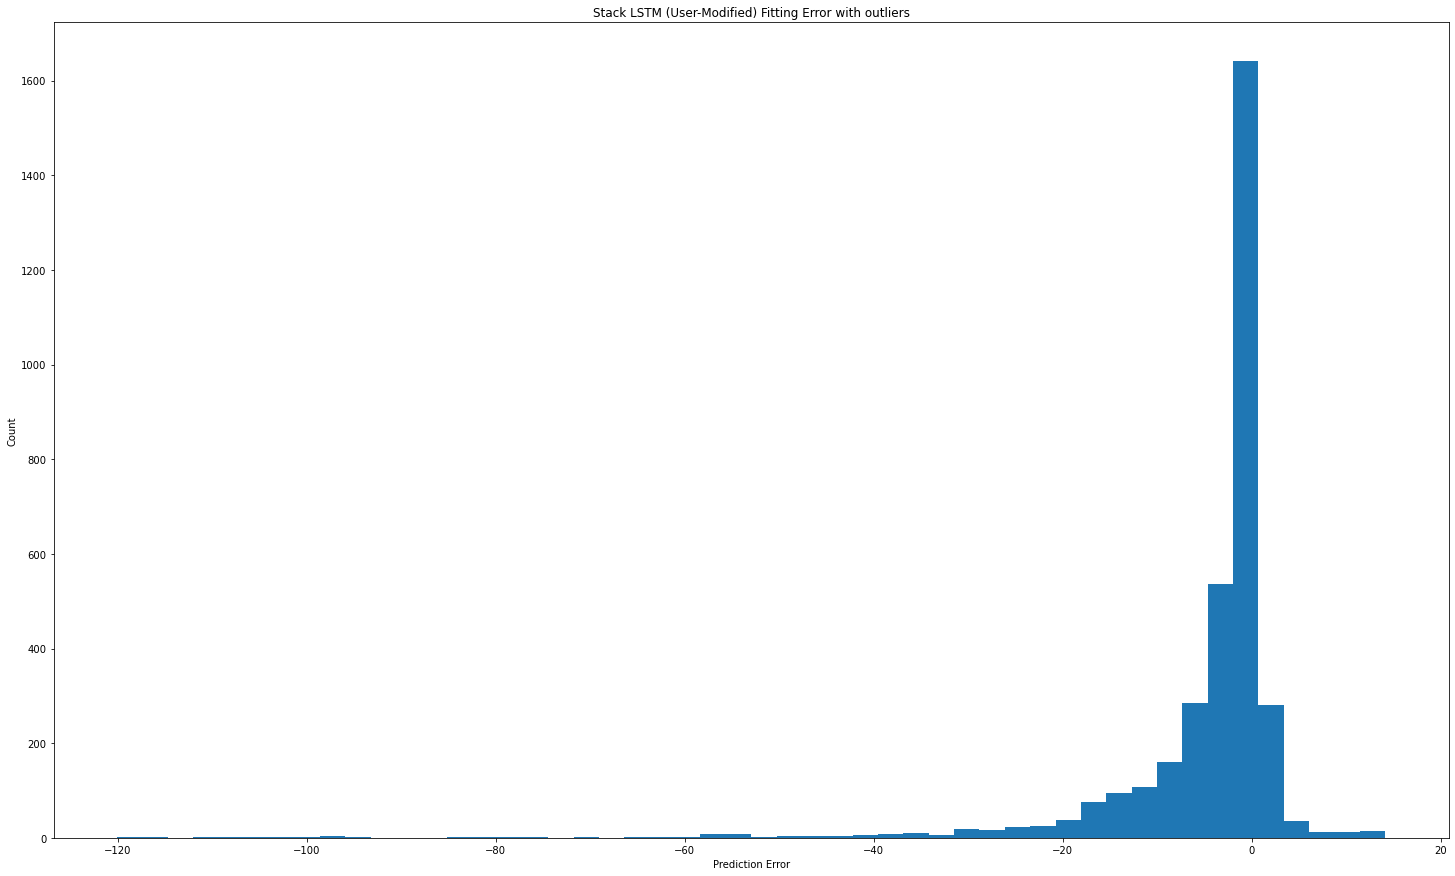

In [639]:
error = round(predictions['Settlement Point Price'],2) - round(test_labels['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Stack LSTM (User-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")


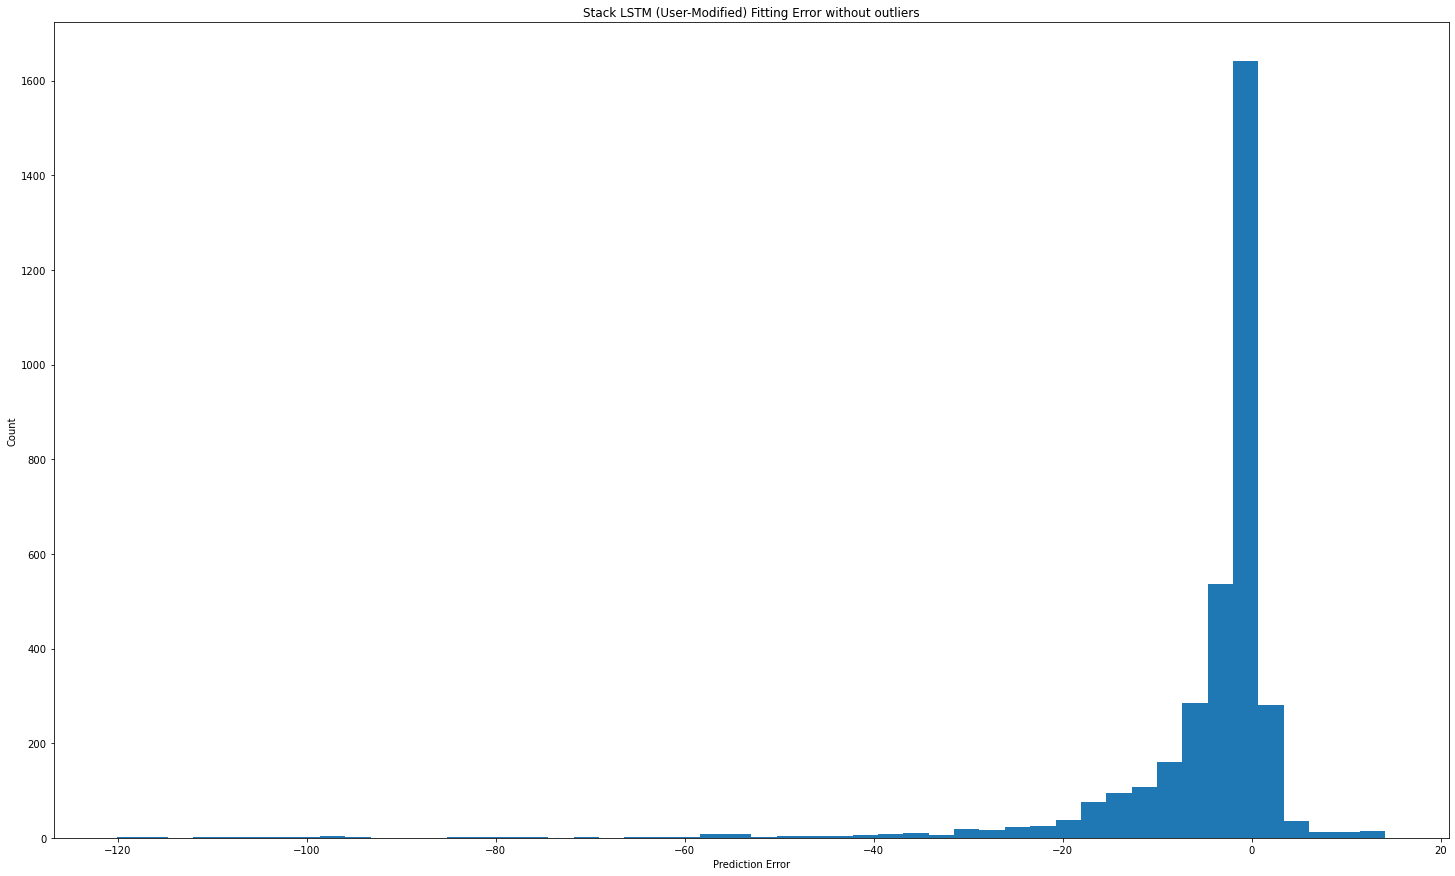

In [640]:
error_u_out = round(predictions_outliers[:3000],2) - round(test_labels_a[:3000],2)
error_u_out=error_u_out[:3000]
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Stack LSTM (User-Modified) Fitting Error without outliers')
_ = plt.ylabel("Count")


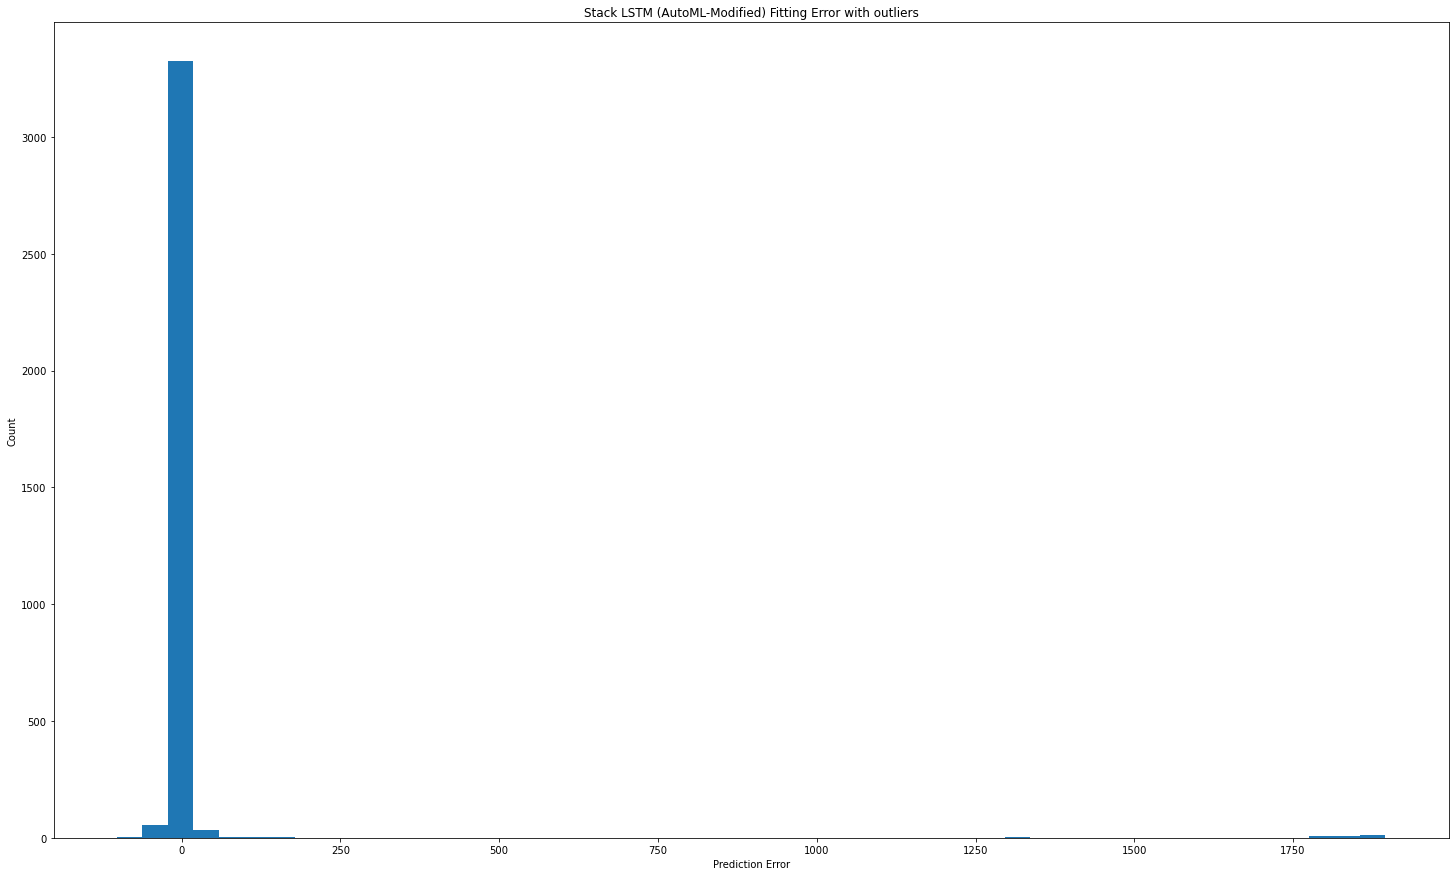

In [641]:
error_b = round(predictions_b['Settlement Point Price'],2) - round(test_labels['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error_b, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Stack LSTM (AutoML-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")


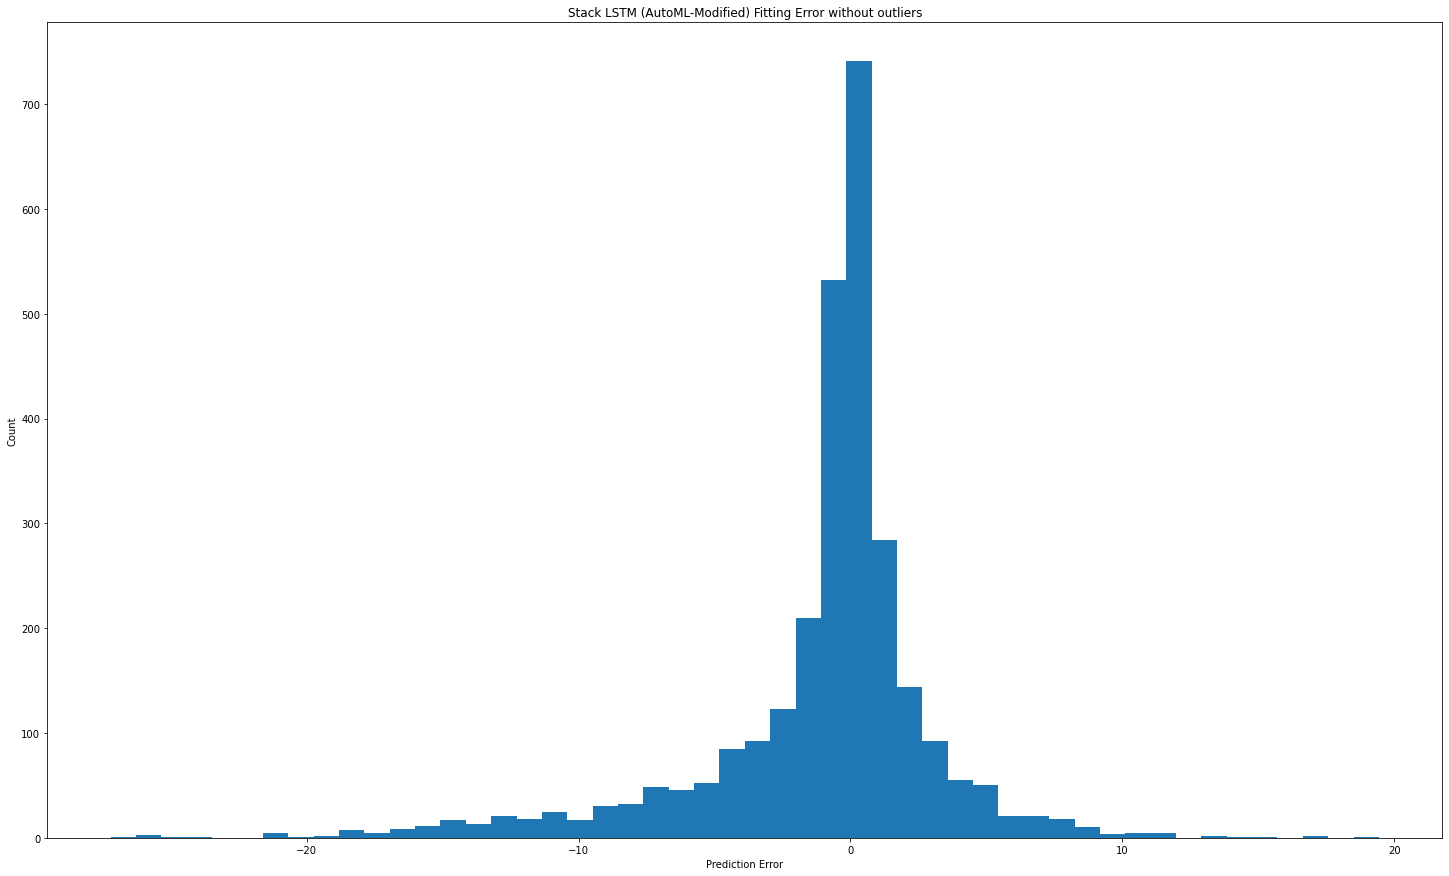

In [642]:
# test_labels_a[:3000], predictions_b_outliers[:3000]

error_b_out = round(predictions_b_outliers[:3000],2) - round(test_labels_a[:3000],2)
error_b_out=error_b_out[:3000]
plt.figure(figsize=(25,15))
plt.hist(error_b_out, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Stack LSTM (AutoML-Modified) Fitting Error without outliers')
_ = plt.ylabel("Count")

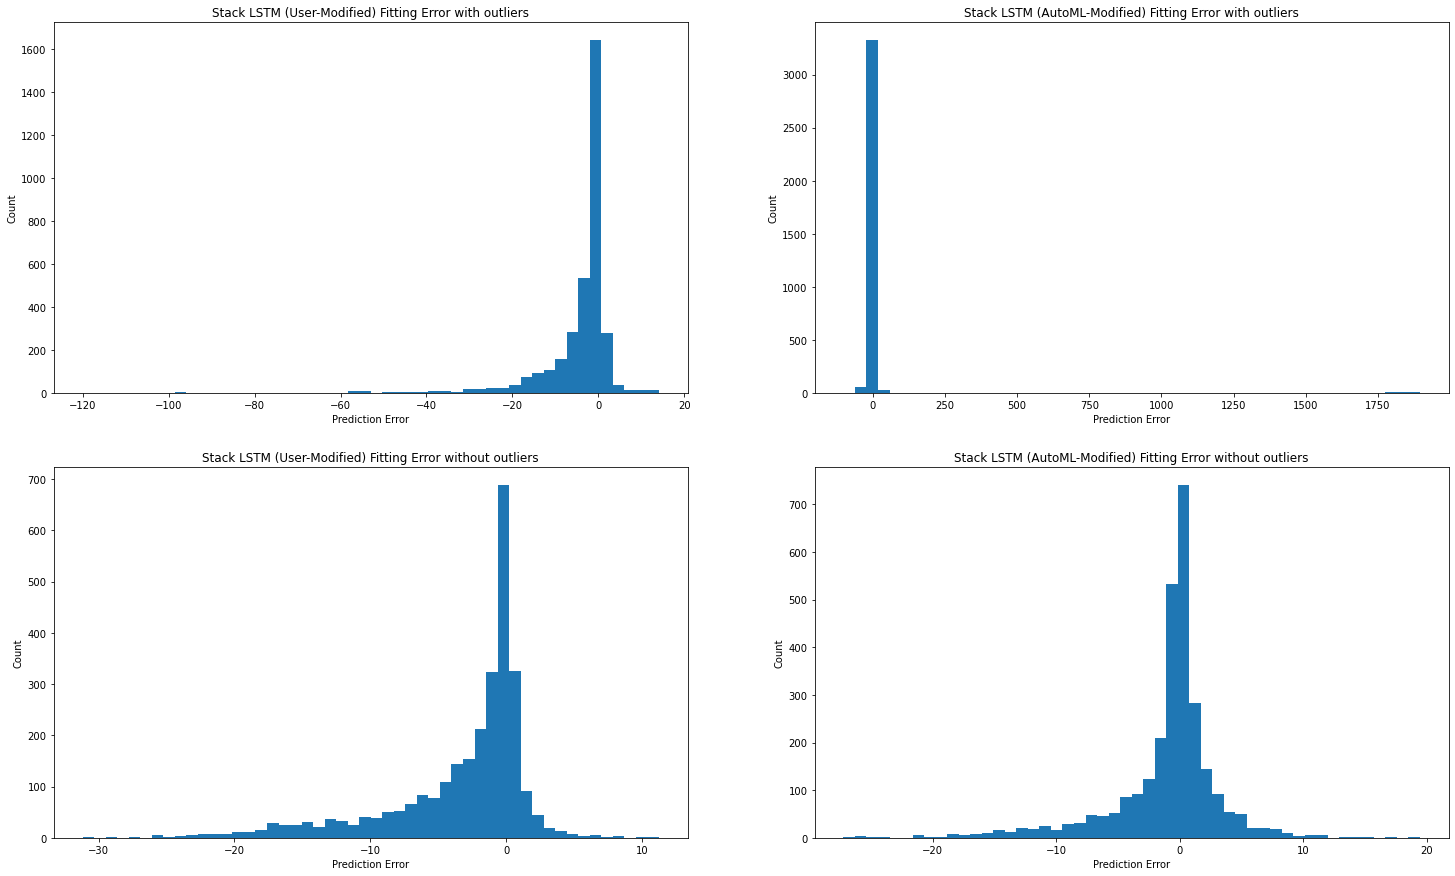

In [643]:
# Calculate errors for both predictions and predictions_b
# error = round(predictions['Settlement Point Price'], 2) - round(test_labels['Settlement Point Price'], 2)
# error_b = round(predictions_b['Settlement Point Price'], 2) - round(test_labels['Settlement Point Price'], 2)
# error_b_out = round(predictions_b_outliers[:3000],2) - round(test_labels_a[:3000],2)
# error_b_out=error_b_out[:3000]
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(25, 15))

# Plot the histogram of errors for the first dataset on the left subplot
ax1[0].hist(error, bins=50)
ax1[0].set_xlabel("Prediction Error")
ax1[0].set_ylabel("Count")
ax1[0].set_title('Stack LSTM (User-Modified) Fitting Error with outliers')
# Plot the histogram of errors for the first dataset on the left subplot
ax2[0].hist(error_u_out, bins=50)
ax2[0].set_xlabel("Prediction Error")
ax2[0].set_ylabel("Count")
ax2[0].set_title('Stack LSTM (User-Modified) Fitting Error without outliers')

# Plot the histogram of errors for the second dataset on the right subplot
ax1[1].hist(error_b, bins=50)
ax1[1].set_xlabel("Prediction Error")
ax1[1].set_ylabel("Count")
ax1[1].set_title('Stack LSTM (AutoML-Modified) Fitting Error with outliers')

ax2[1].hist(error_b_out, bins=50)
ax2[1].set_xlabel("Prediction Error")
ax2[1].set_ylabel("Count")
ax2[1].set_title('Stack LSTM (AutoML-Modified) Fitting Error without outliers')

# Display the plots
plt.show()

In [644]:
print(predictions[0:10], test_labels['Settlement Point Price'][0:10], error[0:10])

   Settlement Point Price
0               24.127127
1               21.673355
2               20.334158
3               18.997978
4               18.330162
5               18.148935
6               17.938238
7               18.174170
8               18.228935
9               19.209999 0    28.210249
1    23.379947
2    19.990000
3    18.819967
4    18.309957
5    17.839968
6    17.729968
7    17.589966
8    18.220054
9    19.179966
Name: Settlement Point Price, dtype: float64 0   -4.080001
1   -1.710000
2    0.340000
3    0.180000
4    0.020000
5    0.310000
6    0.210001
7    0.580000
8    0.010000
9    0.029999
Name: Settlement Point Price, dtype: float64


In [645]:
mean_squared_error(test_labels['Settlement Point Price'][0:10],predictions[0:10])

2.021599604123034

In [646]:
mean_squared_error(test_labels['Settlement Point Price'],predictions_b)

31831.936938512226

In [647]:
r2_score(test_labels['Settlement Point Price'][0:10],predictions[0:10])

0.8027620744375948

In [648]:
i=0
count=0
for i in range(len(error)):
    if ((error[i])>5) or ((error[i]<-5)):
        count=count+1
print(count)

934


In [649]:
i=0
count_b=0
for i in range(len(error_b)):
    if ((error_b[i])>5) or ((error_b[i]<-5)):
        count_b=count_b+1
print(count_b)

699


In [650]:
i=0
count_b_out=0
error_b_n=error_b_out.reset_index()
error_b_n=error_b_n['Settlement Point Price']
for i in range(len(error_b_n)):
    if ((error_b_n[i])>5) or ((error_b_n[i]<-5)):
        count_b_out=count_b_out+1
print(count_b_out)

463


In [651]:
a = len(predictions) - count
a
accuracy = (a/len(predictions))*100
print('accuracy:', accuracy)

accuracy: 73.03695150115473


In [652]:
b = len(predictions_b) - count_b
b
accuracy = (b/len(predictions_b))*100
print('accuracy:', accuracy)

accuracy: 79.82101616628175


In [653]:
b = len(predictions_b_outliers) - count_b_out
b
accuracy = (b/len(predictions_b_outliers))*100
print('accuracy:', accuracy)

accuracy: 86.03739445114596


In [654]:
from statistics import mean, stdev
print('Mean of error in test data:', mean(error))
print('Standard deviation of error in test data:', stdev(error))

Mean of error in test data: -4.639419751640831
Standard deviation of error in test data: 11.044848078125607


In [655]:
from statistics import mean, stdev
print('Mean of error in test data:', mean(error_b))
print('Standard deviation of error in test data:', stdev(error_b))

Mean of error in test data: 16.90883903240772
Standard deviation of error in test data: 177.63764083057063


In [656]:
error_b_out=error_b_out.reset_index()['Settlement Point Price']
error_b_out

0       1.499999
1       1.860000
2       1.149999
3       0.540001
4      -0.199999
          ...   
2995   -3.009999
2996   -2.670000
2997    3.100000
2998   -1.199999
2999    1.530000
Name: Settlement Point Price, Length: 3000, dtype: float64

In [657]:
from statistics import mean, stdev
print('Mean of error in test data:', mean(error_b_out))
print('Standard deviation of error in test data:', stdev(error_b_out))

Mean of error in test data: nan
Standard deviation of error in test data: nan


In [658]:
from statistics import mean, stdev
print('Mean of test data:', mean(test_labels['Settlement Point Price']))
print('Standard deviation of test data:', stdev(test_labels['Settlement Point Price']))

Mean of test data: 27.92255865196976
Standard deviation of test data: 13.837448141380454


In [659]:
import datetime
stop =datetime.datetime.now()
stop

datetime.datetime(2023, 9, 11, 12, 32, 28, 705618)

In [660]:
print(stop-start)

0:12:43.270003


In [661]:
# Default model for the stack Lstm
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error)):
        if ((error[i])>j) or ((error[i]<-j)):
            count=count+1
    a = len(predictions) - count
#     mse, rmse, mae,r2, mse graph
    accuracy = (a/len(predictions))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy )

accuracy: with threshold of 1  is 38.60
accuracy: with threshold of 2  is 53.75
accuracy: with threshold of 3  is 62.30
accuracy: with threshold of 4  is 68.45
accuracy: with threshold of 5  is 73.04
accuracy: with threshold of 6  is 76.59
accuracy: with threshold of 7  is 79.82
accuracy: with threshold of 8  is 81.81
accuracy: with threshold of 9  is 83.66
accuracy: with threshold of 10  is 85.39


In [662]:
import numpy as np

# Initialize lists to store MSE and MAE values
mse_values1 = []
mae_values1 = []

for j in range(1, 11):
    count = 0
    squared_errors = []  # List to store squared errors for MSE calculation
    absolute_errors = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error)):
        if (error[i] > j) or (error[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors.append((error[i]) ** 2)
            absolute_errors.append(abs(error[i]))
    
    a = len(predictions) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.mean(squared_errors) if squared_errors else 0.0
    mae = np.mean(absolute_errors) if absolute_errors else 0.0
    
    mse_values1.append(mse)
    mae_values1.append(mae)
    
    accuracy = (a / len(predictions)) * 100
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

Accuracy with a threshold of 1  is 38.60
MSE with a threshold of 1  is 0.23
MAE with a threshold of 1  is 0.39


Accuracy with a threshold of 2  is 53.75
MSE with a threshold of 2  is 0.78
MAE with a threshold of 2  is 0.69


Accuracy with a threshold of 3  is 62.30
MSE with a threshold of 3  is 1.52
MAE with a threshold of 3  is 0.94


Accuracy with a threshold of 4  is 68.45
MSE with a threshold of 4  is 2.49
MAE with a threshold of 4  is 1.17


Accuracy with a threshold of 5  is 73.04
MSE with a threshold of 5  is 3.60
MAE with a threshold of 5  is 1.37


Accuracy with a threshold of 6  is 76.59
MSE with a threshold of 6  is 4.83
MAE with a threshold of 6  is 1.56


Accuracy with a threshold of 7  is 79.82
MSE with a threshold of 7  is 6.33
MAE with a threshold of 7  is 1.76


Accuracy with a threshold of 8  is 81.81
MSE with a threshold of 8  is 7.56
MAE with a threshold of 8  is 1.90


Accuracy with a threshold of 9  is 83.66
MSE with a threshold of 9  is 8.99
MAE with a threshold

Accuracy with a threshold of 1  is 38.60 mae
Accuracy with a threshold of 2  is 53.75 mae
Accuracy with a threshold of 3  is 62.30 mae
Accuracy with a threshold of 4  is 68.45 mae
Accuracy with a threshold of 5  is 73.04 mae
Accuracy with a threshold of 6  is 76.59 mae
Accuracy with a threshold of 7  is 79.82 mae
Accuracy with a threshold of 8  is 81.81 mae
Accuracy with a threshold of 9  is 83.66 mae
Accuracy with a threshold of 10  is 85.39 mae


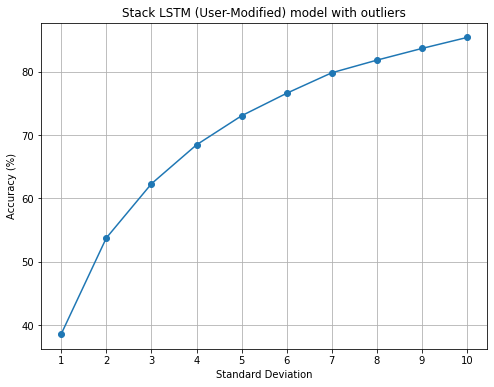

In [663]:
# Default model for the stack Lstm
thresholds_s = []
accuracies_s = []
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for j in range(1, 11):
    i = 0
    count = 0
    for i in range(len(error)):
        if ((error[i]) > j) or ((error[i] < -j)):
            count += 1
    a = len(predictions) - count
    accuracy = (a / len(predictions)) * 100
    mae = mean_absolute_error(predictions, test_labels['Settlement Point Price'])
    # mse = mean_squared_error(predictions, test_labels['Settlement Point Price'])
    # r2 = r2_score(test_labels['Settlement Point Price'], predictions)
    thresholds_s.append(j)
    accuracies_s.append(accuracy)
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy,"mae" % mae)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds_s, accuracies_s, marker='o', linestyle='-')
plt.title("Stack LSTM (User-Modified) model with outliers")
plt.xlabel("Standard Deviation")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

Accuracy with a threshold of 1  is 38.60
MSE with a threshold of 1  is 0.23
MAE with a threshold of 1  is 0.39


Accuracy with a threshold of 2  is 53.75
MSE with a threshold of 2  is 0.78
MAE with a threshold of 2  is 0.69


Accuracy with a threshold of 3  is 62.30
MSE with a threshold of 3  is 1.52
MAE with a threshold of 3  is 0.94


Accuracy with a threshold of 4  is 68.45
MSE with a threshold of 4  is 2.49
MAE with a threshold of 4  is 1.17


Accuracy with a threshold of 5  is 73.04
MSE with a threshold of 5  is 3.60
MAE with a threshold of 5  is 1.37


Accuracy with a threshold of 6  is 76.59
MSE with a threshold of 6  is 4.83
MAE with a threshold of 6  is 1.56


Accuracy with a threshold of 7  is 79.82
MSE with a threshold of 7  is 6.33
MAE with a threshold of 7  is 1.76


Accuracy with a threshold of 8  is 81.81
MSE with a threshold of 8  is 7.56
MAE with a threshold of 8  is 1.90


Accuracy with a threshold of 9  is 83.66
MSE with a threshold of 9  is 8.99
MAE with a threshold

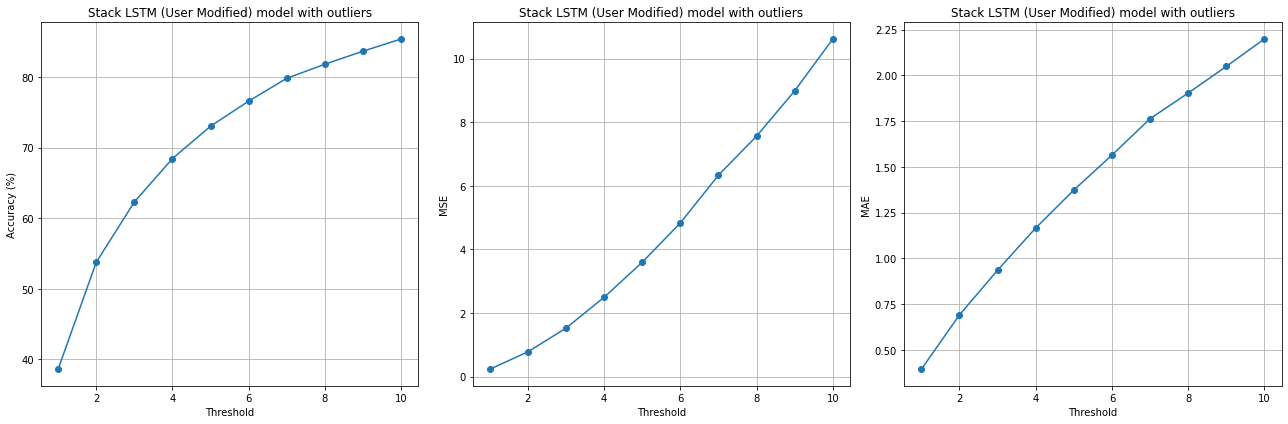

In [664]:
# Default model for the stack Lstm with outliers

import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values1 = []
mae_values1 = []
accuracy_values = []

for j in range(1, 11):
    count = 0
    squared_errors = []  # List to store squared errors for MSE calculation
    absolute_errors = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error)):
        if (error[i] > j) or (error[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors.append((error[i]) ** 2)
            absolute_errors.append(abs(error[i]))
    
    a = len(predictions) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.mean(squared_errors) if squared_errors else 0.0
    mae = np.mean(absolute_errors) if absolute_errors else 0.0
    
    mse_values1.append(mse)
    mae_values1.append(mae)
    
    accuracy = (a / len(predictions)) * 100
    accuracy_values.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values, marker='o', linestyle='-')
axes[0].set_title("Stack LSTM (User Modified) model with outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values1, marker='o', linestyle='-')
axes[1].set_title("Stack LSTM (User Modified) model with outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values1, marker='o', linestyle='-')
axes[2].set_title("Stack LSTM (User Modified) model with outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


Accuracy with a threshold of 1  is 50.72
Accuracy with a threshold of 2  is 62.82
Accuracy with a threshold of 3  is 69.95
Accuracy with a threshold of 4  is 75.12
Accuracy with a threshold of 5  is 78.95
Accuracy with a threshold of 6  is 81.99
Accuracy with a threshold of 7  is 84.84
Accuracy with a threshold of 8  is 86.75
Accuracy with a threshold of 9  is 88.51
Accuracy with a threshold of 10  is 89.98


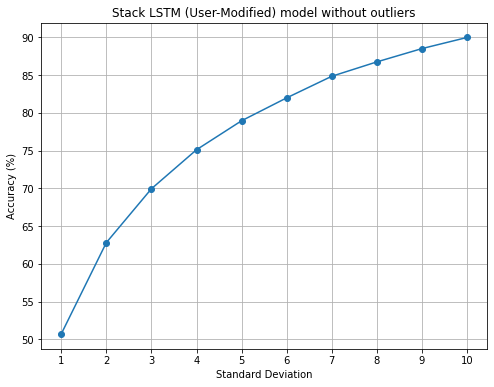

In [665]:
# Default model for the stack Lstm without outliers
thresholds_u = []
accuracies_u = []
error_u_out=error_u_out.reset_index()['Settlement Point Price']
for j in range(1, 11):
    i = 0
    count = 0
    for i in range(len(error_u_out)):
        if ((error_u_out[i]) > j) or ((error_u_out[i] < -j)):
            count += 1
    a = len(predictions_outliers) - count
    accuracy = (a / len(predictions_outliers)) * 100
    thresholds_u.append(j)
    accuracies_u.append(accuracy)
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds_u, accuracies_u, marker='o', linestyle='-')
plt.title("Stack LSTM (User-Modified) model without outliers")
plt.xlabel("Standard Deviation")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

Accuracy with a threshold of 1  is 50.72
MSE with a threshold of 1  is 0.22
MAE with a threshold of 1  is 0.39


Accuracy with a threshold of 2  is 62.82
MSE with a threshold of 2  is 0.74
MAE with a threshold of 2  is 0.67


Accuracy with a threshold of 3  is 69.95
MSE with a threshold of 3  is 1.49
MAE with a threshold of 3  is 0.91


Accuracy with a threshold of 4  is 75.12
MSE with a threshold of 4  is 2.47
MAE with a threshold of 4  is 1.15


Accuracy with a threshold of 5  is 78.95
MSE with a threshold of 5  is 3.56
MAE with a threshold of 5  is 1.35


Accuracy with a threshold of 6  is 81.99
MSE with a threshold of 6  is 4.81
MAE with a threshold of 6  is 1.55


Accuracy with a threshold of 7  is 84.84
MSE with a threshold of 7  is 6.39
MAE with a threshold of 7  is 1.75


Accuracy with a threshold of 8  is 86.75
MSE with a threshold of 8  is 7.76
MAE with a threshold of 8  is 1.91


Accuracy with a threshold of 9  is 88.51
MSE with a threshold of 9  is 9.35
MAE with a threshold

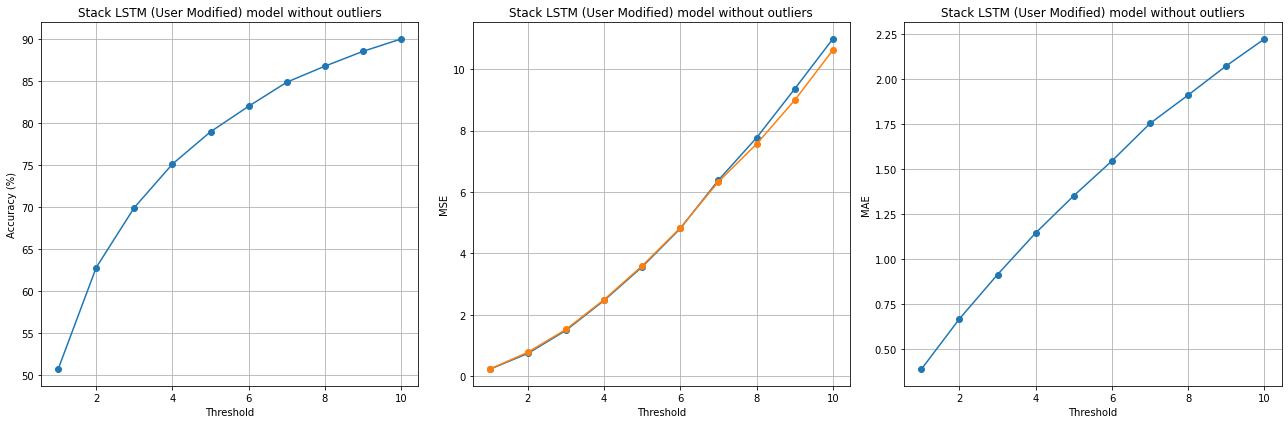

In [668]:
# Default model for the stack Lstm without outliers
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values2 = []
mae_values2 = []
accuracy_values2 = []

for j in range(1, 11):
    count = 0
    squared_errors2 = []  # List to store squared errors for MSE calculation
    absolute_errors2 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_u_out)):  # Make sure error_u_out is defined
        if (error_u_out[i] > j) or (error_u_out[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors2.append((error_u_out[i]) ** 2)
            absolute_errors2.append(abs(error_u_out[i]))
             
    a = len(predictions_outliers) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.nanmean(squared_errors2) if squared_errors2 else 0.0
    mae = np.nanmean(absolute_errors2) if absolute_errors2 else 0.0
    mse_values2.append(mse)
    mae_values2.append(mae)
    
    accuracy = (a / len(predictions_outliers)) * 100
    accuracy_values2.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values2, marker='o', linestyle='-')
axes[0].set_title("Stack LSTM (User Modified) model without outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values2, marker='o', linestyle='-')
axes[1].plot(range(1, 11), mse_values1, marker='o', linestyle='-')
axes[1].set_title("Stack LSTM (User Modified) model without outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values2, marker='o', linestyle='-')
axes[2].set_title("Stack LSTM (User Modified) model without outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [669]:
# best model for the stack LSTM
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_b)):
        if ((error_b[i])>j) or ((error_b[i]<-j)):
            count=count+1
    a = len(predictions_b) - count
    accuracy = (a/len(predictions_b))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 43.88
accuracy: with threshold of 2  is 60.28
accuracy: with threshold of 3  is 69.49
accuracy: with threshold of 4  is 75.17
accuracy: with threshold of 5  is 79.82
accuracy: with threshold of 6  is 82.74
accuracy: with threshold of 7  is 85.16
accuracy: with threshold of 8  is 87.15
accuracy: with threshold of 9  is 88.74
accuracy: with threshold of 10  is 89.81


Accuracy with a threshold of 1  is 43.88
Accuracy with a threshold of 2  is 60.28
Accuracy with a threshold of 3  is 69.49
Accuracy with a threshold of 4  is 75.17
Accuracy with a threshold of 5  is 79.82
Accuracy with a threshold of 6  is 82.74
Accuracy with a threshold of 7  is 85.16
Accuracy with a threshold of 8  is 87.15
Accuracy with a threshold of 9  is 88.74
Accuracy with a threshold of 10  is 89.81


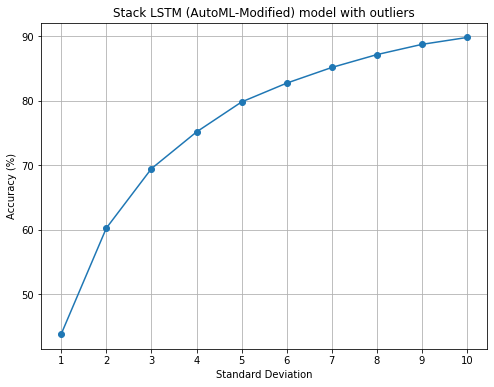

In [670]:
# best model for the stack LSTM with outliers
thresholds2 = []
accuracies2 = []

for j in range(1, 11):
    i = 0
    count = 0
    for i in range(len(error_b)):
        if ((error_b[i]) > j) or ((error_b[i] < -j)):
            count += 1
    a = len(predictions_b) - count
    accuracy = (a / len(predictions_b)) * 100
    thresholds2.append(j)
    accuracies2.append(accuracy)
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds2, accuracies2, marker='o', linestyle='-')
plt.title("Stack LSTM (AutoML-Modified) model with outliers")
plt.xlabel("Standard Deviation")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

Accuracy with a threshold of 1  is 43.88
MSE with a threshold of 1  is 0.24
MAE with a threshold of 1  is 0.40


Accuracy with a threshold of 2  is 60.28
MSE with a threshold of 2  is 0.76
MAE with a threshold of 2  is 0.68


Accuracy with a threshold of 3  is 69.49
MSE with a threshold of 3  is 1.46
MAE with a threshold of 3  is 0.92


Accuracy with a threshold of 4  is 75.17
MSE with a threshold of 4  is 2.29
MAE with a threshold of 4  is 1.11


Accuracy with a threshold of 5  is 79.82
MSE with a threshold of 5  is 3.32
MAE with a threshold of 5  is 1.31


Accuracy with a threshold of 6  is 82.74
MSE with a threshold of 6  is 4.26
MAE with a threshold of 6  is 1.45


Accuracy with a threshold of 7  is 85.16
MSE with a threshold of 7  is 5.35
MAE with a threshold of 7  is 1.60


Accuracy with a threshold of 8  is 87.15
MSE with a threshold of 8  is 6.51
MAE with a threshold of 8  is 1.73


Accuracy with a threshold of 9  is 88.74
MSE with a threshold of 9  is 7.67
MAE with a threshold

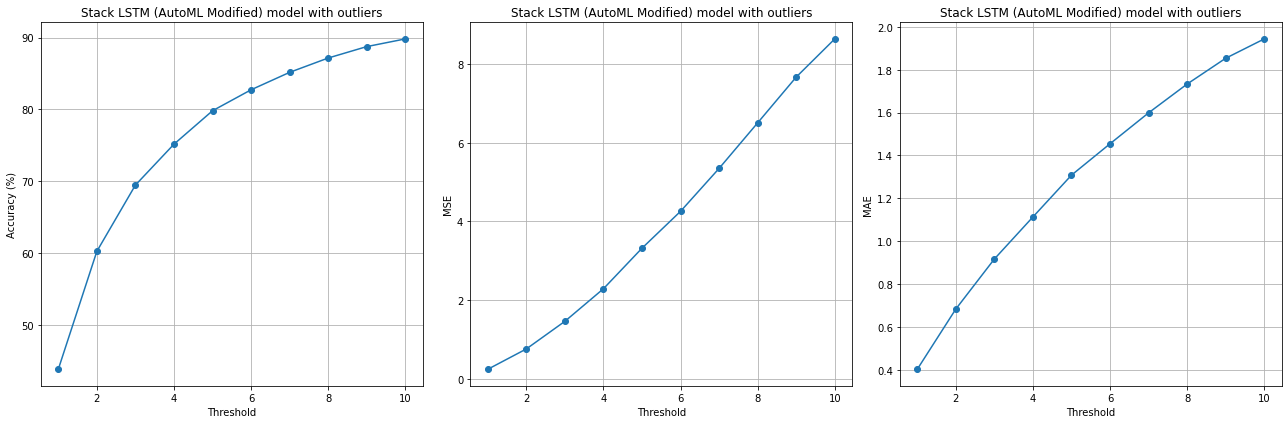

In [671]:
# Best model for the stack Lstm with outliers
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values3 = []
mae_values3 = []
accuracy_values3 = []

for j in range(1, 11):
    count = 0
    squared_errors3 = []  # List to store squared errors for MSE calculation
    absolute_errors3 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_b)):  # Make sure error_u_out is defined
        if (error_b[i] > j) or (error_b[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors3.append((error_b[i]) ** 2)
            absolute_errors3.append(abs(error_b[i]))
             
    a = len(predictions_b) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.nanmean(squared_errors3) if squared_errors3 else 0.0
    mae = np.nanmean(absolute_errors3) if absolute_errors3 else 0.0
    mse_values3.append(mse)
    mae_values3.append(mae)
    
    accuracy = (a / len(predictions_b)) * 100
    accuracy_values3.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values3, marker='o', linestyle='-')
axes[0].set_title("Stack LSTM (AutoML Modified) model with outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values3, marker='o', linestyle='-')
axes[1].set_title("Stack LSTM (AutoML Modified) model with outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values3, marker='o', linestyle='-')
axes[2].set_title("Stack LSTM (AutoML Modified) model with outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [672]:
error_b_out[:3000]

0       1.499999
1       1.860000
2       1.149999
3       0.540001
4      -0.199999
          ...   
2995   -3.009999
2996   -2.670000
2997    3.100000
2998   -1.199999
2999    1.530000
Name: Settlement Point Price, Length: 3000, dtype: float64

Accuracy with a threshold of 1  is 53.65
Accuracy with a threshold of 2  is 68.06
Accuracy with a threshold of 3  is 76.57
Accuracy with a threshold of 4  is 81.69
Accuracy with a threshold of 5  is 86.04
Accuracy with a threshold of 6  is 88.75
Accuracy with a threshold of 7  is 90.89
Accuracy with a threshold of 8  is 92.76
Accuracy with a threshold of 9  is 94.21
Accuracy with a threshold of 10  is 94.96


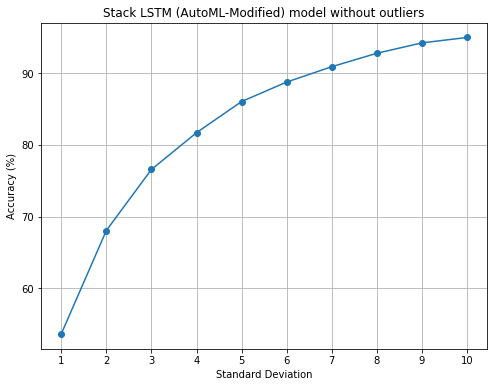

In [673]:
# best model for the stack LSTM without outliers
thresholds3 = []
accuracies3 = []

for j in range(1, 11):
    i = 0
    count = 0
    for i in range(len(error_b_out)):
        if ((error_b_out[i]) > j) or ((error_b_out[i] < -j)):
            count += 1
    a = len(predictions_b_outliers) - count
    accuracy = (a / len(predictions_b_outliers)) * 100
    thresholds3.append(j)
    accuracies3.append(accuracy)
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds3, accuracies3, marker='o', linestyle='-')
plt.title("Stack LSTM (AutoML-Modified) model without outliers")
plt.xlabel("Standard Deviation")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

Accuracy with a threshold of 1  is 53.65
MSE with a threshold of 1  is 0.24
MAE with a threshold of 1  is 0.40


Accuracy with a threshold of 2  is 68.06
MSE with a threshold of 2  is 0.73
MAE with a threshold of 2  is 0.67


Accuracy with a threshold of 3  is 76.57
MSE with a threshold of 3  is 1.46
MAE with a threshold of 3  is 0.91


Accuracy with a threshold of 4  is 81.69
MSE with a threshold of 4  is 2.28
MAE with a threshold of 4  is 1.11


Accuracy with a threshold of 5  is 86.04
MSE with a threshold of 5  is 3.34
MAE with a threshold of 5  is 1.31


Accuracy with a threshold of 6  is 88.75
MSE with a threshold of 6  is 4.30
MAE with a threshold of 6  is 1.46


Accuracy with a threshold of 7  is 90.89
MSE with a threshold of 7  is 5.37
MAE with a threshold of 7  is 1.60


Accuracy with a threshold of 8  is 92.76
MSE with a threshold of 8  is 6.56
MAE with a threshold of 8  is 1.74


Accuracy with a threshold of 9  is 94.21
MSE with a threshold of 9  is 7.73
MAE with a threshold

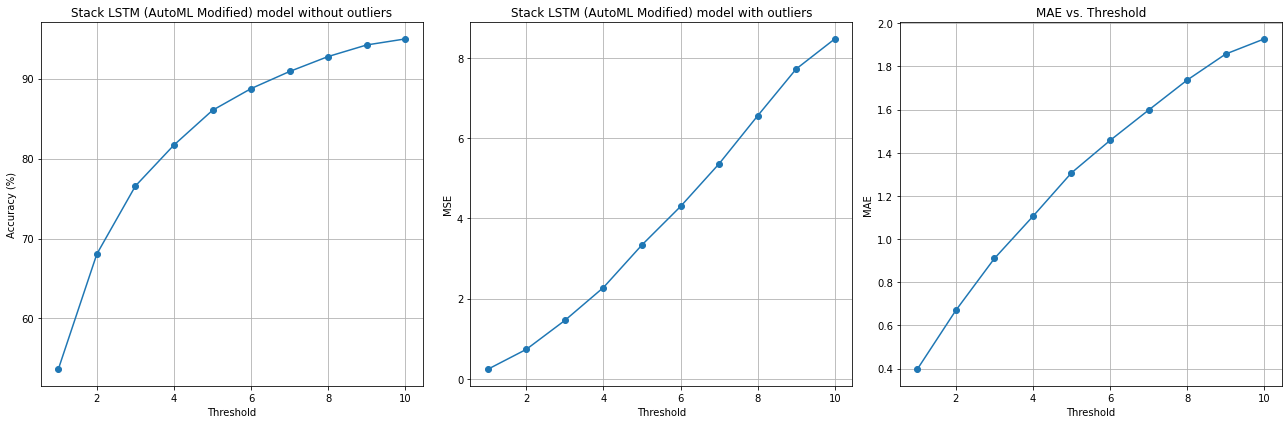

In [674]:
# Default model for the stack Lstm without outliers
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values4 = []
mae_values4 = []
accuracy_values4 = []

for j in range(1, 11):
    count = 0
    squared_errors4 = []  # List to store squared errors for MSE calculation
    absolute_errors4 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_b_out)):  # Make sure error_u_out is defined
        if (error_b_out[i] > j) or (error_b_out[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors4.append((error_b_out[i]) ** 2)
            absolute_errors4.append(abs(error_b_out[i]))
             
    a = len(predictions_b_outliers) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.nanmean(squared_errors4) if squared_errors4 else 0.0
    mae = np.nanmean(absolute_errors4) if absolute_errors4 else 0.0
    mse_values4.append(mse)
    mae_values4.append(mae)
    
    accuracy = (a / len(predictions_b_outliers)) * 100
    accuracy_values4.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values4, marker='o', linestyle='-')
axes[0].set_title("Stack LSTM (AutoML Modified) model without outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values4, marker='o', linestyle='-')
axes[1].set_title("Stack LSTM (AutoML Modified) model with outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values4, marker='o', linestyle='-')
axes[2].set_title("MAE vs. Threshold")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


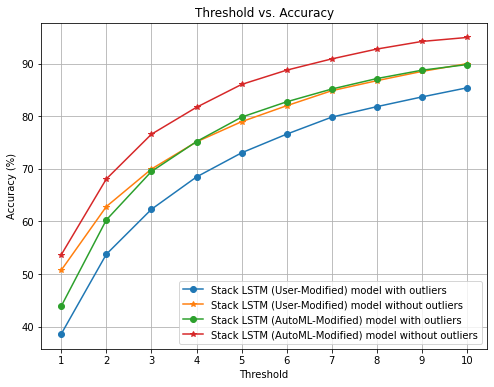

In [675]:
import matplotlib.pyplot as plt

# Create a figure with one subplot for both line plots
plt.figure(figsize=(8, 6))

# Plot the threshold vs. accuracy for the first dataset
plt.plot(thresholds_s, accuracies_s, marker='o', linestyle='-', label="Stack LSTM (User-Modified) model with outliers")
plt.plot(thresholds_u, accuracies_u, marker='*', linestyle='-', label="Stack LSTM (User-Modified) model without outliers")
# Plot the threshold vs. accuracy for the second dataset
plt.plot(thresholds2, accuracies2, marker='o', linestyle='-', label="Stack LSTM (AutoML-Modified) model with outliers")

plt.plot(thresholds3, accuracies3, marker='*', linestyle='-', label="Stack LSTM (AutoML-Modified) model without outliers")

# Add titles, labels, legend, and grid
plt.title("Threshold vs. Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.legend()

# Display the single graph with both line plots
plt.show()


In [676]:
load.reset_index()

Delivery Date  dayofweek  month  Delivery Hour  Temperature in F  \
0          1/1/2015          3      1              1              44.0   
1          1/1/2015          3      1              2              44.0   
2          1/1/2015          3      1              3              44.0   
3          1/1/2015          3      1              4              44.0   
4          1/1/2015          3      1              5              44.0   
...             ...        ...    ...            ...               ...   
34633    12/31/2018          0     12             20              54.0   
34634    12/31/2018          0     12             21              55.0   
34635    12/31/2018          0     12             22              55.0   
34636    12/31/2018          0     12             23              55.0   
34637    12/31/2018          0     12             24              55.0   

       Load in Houston  Settlement Point Price  season  IsDayTime  
0              9844.20                   22.47  Winter          0  
1              9653.46                   22.31  Winter          0  
2              9502.30                   22.20  Winter          0  
3              9474.48                   22.13  Winter          0  
4              9554.37                   22.16  Winter          0  
...                ...                     ...     ...        ...  
34633         10846.18                   21.45  Winter          0  
34634         10574.06                   18.50  Winter          0  
34635         10389.92                   16.04  Winter          0  
34636         10179.72                   16.39  Winter          0  
34637         10008.27                   15.38  Winter          0  

[34638 rows x 9 columns]

In [677]:
load.head()

dayofweek  month  Delivery Hour  Temperature in F  \
Delivery Date                                                      
1/1/2015               3      1              1              44.0   
1/1/2015               3      1              2              44.0   
1/1/2015               3      1              3              44.0   
1/1/2015               3      1              4              44.0   
1/1/2015               3      1              5              44.0   

               Load in Houston  Settlement Point Price  season  IsDayTime  
Delivery Date                                                              
1/1/2015               9844.20                   22.47  Winter          0  
1/1/2015               9653.46                   22.31  Winter          0  
1/1/2015               9502.30                   22.20  Winter          0  
1/1/2015               9474.48                   22.13  Winter          0  
1/1/2015               9554.37                   22.16  Winter          0

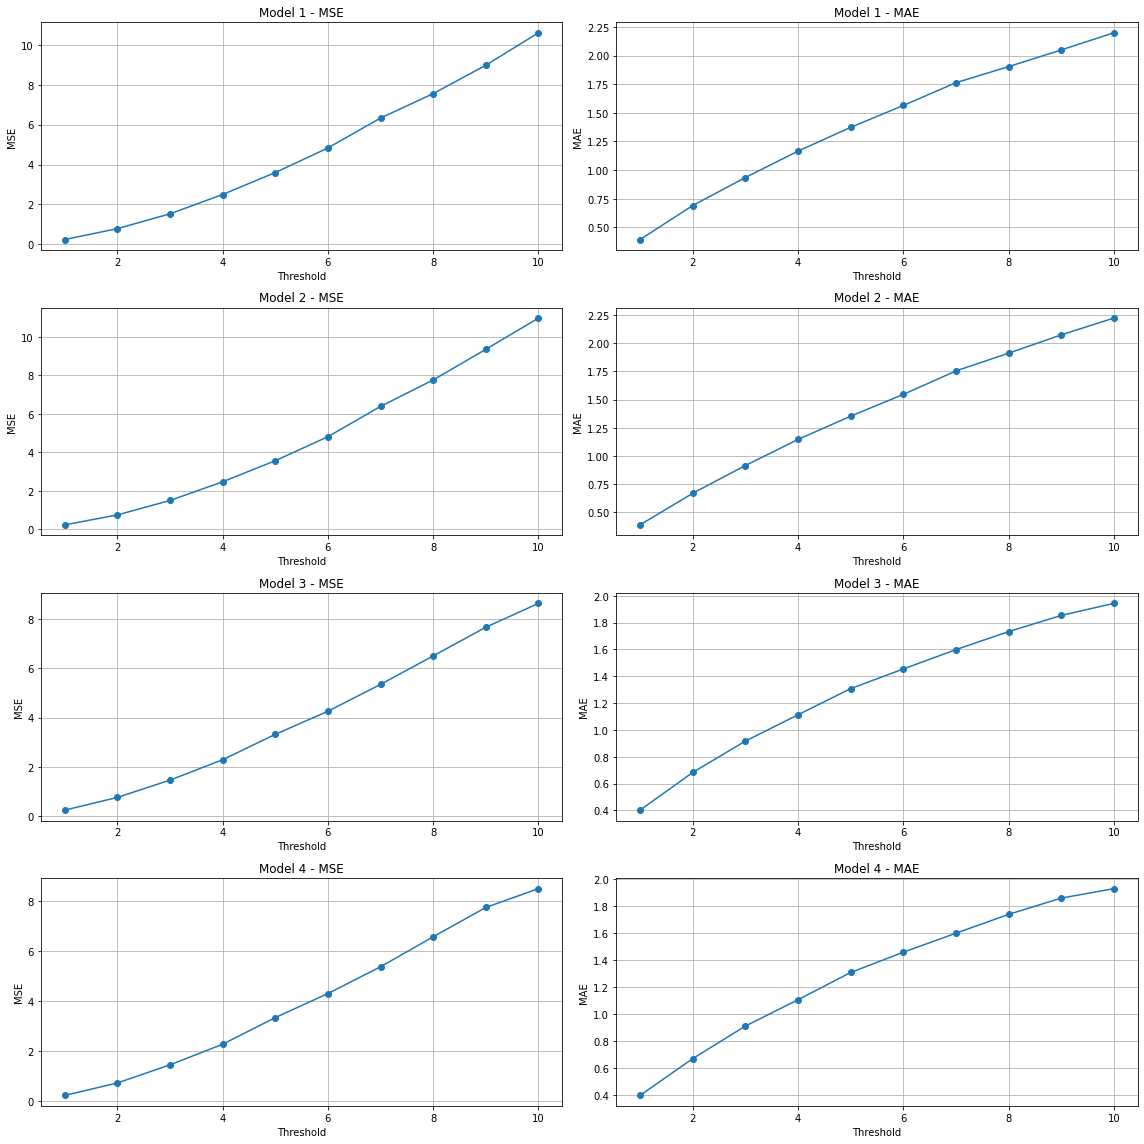

In [678]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE and MAE values for different models
mse_values = [mse_values1, mse_values2, mse_values3, mse_values4]  # Replace with your actual MSE values
mae_values = [mae_values1, mae_values2, mae_values3, mae_values4]  # Replace with your actual MAE values
model_labels = ["Model 1", "Model 2", "Model 3", "Model 4"]  # Replace with your actual model labels

# Create subplots for MSE and MAE
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Plot MSE for each model
for i in range(4):
    axes[i, 0].plot(range(1, 11), mse_values[i], marker='o', linestyle='-')
    axes[i, 0].set_title(f"{model_labels[i]} - MSE")
    axes[i, 0].set_xlabel("Threshold")
    axes[i, 0].set_ylabel("MSE")
    axes[i, 0].grid(True)

# Plot MAE for each model
for i in range(4):
    axes[i, 1].plot(range(1, 11), mae_values[i], marker='o', linestyle='-')
    axes[i, 1].set_title(f"{model_labels[i]} - MAE")
    axes[i, 1].set_xlabel("Threshold")
    axes[i, 1].set_ylabel("MAE")
    axes[i, 1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Display the MSE and MAE plots side by side
plt.show()


# Hybrid LSTM


In [679]:
# Custom LSTM cell with modified activation functions for forget and output gates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, LSTM, Dense, Dropout, Flatten

# Custom LSTM cell with modified activation functions for forget and output gates
class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, forget_activation='sigmoid', output_activation='tanh', **kwargs):
        super(CustomLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.forget_activation = tf.keras.activations.get(forget_activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.state_size = (units, units)  # Two states: hidden state and cell state

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Weights for input and recurrent connections
        self.kernel = self.add_weight(shape=(input_dim, self.units * 4), name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units * 4), name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units * 4,), initializer='zeros', name='bias')

    def call(self, inputs, states):
        h_tm1 = states[0]  # Previous hidden state
        c_tm1 = states[1]  # Previous cell state

        # Concatenate input and previous hidden state for matrix multiplication
        z = tf.matmul(inputs, self.kernel) + tf.matmul(h_tm1, self.recurrent_kernel) + self.bias

        # Split the concatenated results into the four gates: forget, input, candidate, and output
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Apply the activation functions to the forget and output gates
        forget_gate = self.forget_activation(z0)
        output_gate = self.output_activation(z3)

        # Update the cell state using the forget and input gates
        c = forget_gate * c_tm1 + self.forget_activation(z1) * self.output_activation(z2)

        # Update the hidden state using the output gate and cell state
        h = output_gate * self.output_activation(c)

        return h, [h, c]

# Example usage of the custom LSTM cell
# model = Sequential()

# model.add(RNN(CustomLSTMCell(128, forget_activation='sigmoid', output_activation='tanh'),
#               input_shape=(X_train.shape[1],X_train.shape[2])))

model3 = Sequential([
    RNN(CustomLSTMCell(128, forget_activation='sigmoid', output_activation='relu'),
        input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
     RNN(CustomLSTMCell(256, forget_activation='sigmoid', output_activation='relu'), return_sequences=True),  # Additional LSTM layer for maintaining sequence dimension
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dense(64, activation="relu"),
    Dropout(0.1),
    Dense(32, activation="relu"),
    Dropout(0.1), 
    Dense(next_steps)
])
model3.compile(optimizer='adam', loss='mse')
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 2, 128)            89600     
                                                                 
 rnn_1 (RNN)                 (None, 2, 256)            394240    
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [680]:
from tensorflow.keras.callbacks import EarlyStopping
def build_Cust_lstm_model(hp):
    model_s = Sequential()
    model_s.add(RNN(CustomLSTMCell(units=hp.Int('lstm_units_1', min_value=32, max_value=256, step=32), forget_activation='sigmoid', output_activation='relu'),
        input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),)
    model_s.add(RNN(CustomLSTMCell(units=hp.Int('lstm_units_2', min_value=32, max_value=256, step=32), forget_activation='sigmoid', output_activation='relu'),
        input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),)
    model_s.add(Flatten())
    model_s.add(Dense(units=hp.Int('dense_units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model_s.add(Dense(units=hp.Int('dense_units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model_s.add(Dropout(rate=hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))
    model_s.add(Dense(next_steps))
    model_s.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model_s

# Initialize the tuner
tuner = RandomSearch(
    build_Cust_lstm_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_directory',  # Directory to save the tuning results
    project_name='lstm_tuning_cust'  # Name of the tuning project
)

# Search for the best hyperparameters
tuner.search(X_train.reshape(-1, X_train.shape[1], X_train.shape[2]), Y_train,
             epochs=100,  # Number of epochs for each trial
             validation_data=(X_val.reshape(-1, X_val.shape[1], X_val.shape[2]), Y_val),
             batch_size=16,  # Batch size for each trial
             callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],  # Early stopping callback
             verbose=1)

# Get the best model architecture
best_model_cust = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model_cust.summary()



INFO:tensorflow:Reloading Tuner from tuner_directory\lstm_tuning_cust\tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 2, 32)             10112     
                                                                 
 rnn_1 (RNN)                 (None, 2, 96)             49536     
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 192)               37056     
                                                                 
 dense_1 (Dense)             (None, 96)                18528     
                                                                 
 dropout (Dropout)           (None, 96)                0         
  

In [681]:
import tensorflow.keras as keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# patience : number of epochs with no improvement in the monitored metric (val_loss)

In [682]:
example_batch= X_val[0:10]
example_batch.shape

(10, 2, 46)

In [683]:
example_result = model3.predict(example_batch)
example_result.shape

1/1 [==============================] - 0s 440ms/step


(10, 2)

In [684]:


example_result_b = best_model_cust.predict(example_batch)
example_result_b.shape

1/1 [==============================] - 0s 411ms/step


(10, 2)

In [685]:
example_result_b

array([[0.87856925, 0.8294773 ],
       [0.80998397, 0.7235199 ],
       [0.6444956 , 0.55084556],
       [0.47932774, 0.39353403],
       [0.35317084, 0.2872593 ],
       [0.29101947, 0.2454806 ],
       [0.2688192 , 0.25165102],
       [0.26933086, 0.28697637],
       [0.2539776 , 0.31207192],
       [0.3108114 , 0.39966336]], dtype=float32)

In [686]:
len(example_result_b)

10

In [687]:
last_list=[]

for i in range (0, len(example_result)):
  last_list.append((example_result[i][0]))

last_list

[0.24219431,
 0.24219486,
 0.24219468,
 0.24219343,
 0.24219167,
 0.24219126,
 0.24219094,
 0.24219124,
 0.24219084,
 0.24219114]

In [688]:
last_list_b=[]

for i in range (0, len(example_result_b)):
  last_list_b.append((example_result_b[i][0]))

last_list_b

[0.87856925,
 0.80998397,
 0.6444956,
 0.47932774,
 0.35317084,
 0.29101947,
 0.2688192,
 0.26933086,
 0.2539776,
 0.3108114]

In [689]:
len(last_list_b)

10

In [690]:
EPOCHS = 2000

history3 = model3.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1, 
    callbacks=[early_stop])

Epoch 1/2000
975/975 [==============================] - 26s 22ms/step - loss: 0.0330 - val_loss: 0.0269
Epoch 2/2000
975/975 [==============================] - 21s 21ms/step - loss: 0.0100 - val_loss: 0.0128
Epoch 3/2000
975/975 [==============================] - 21s 22ms/step - loss: 0.0086 - val_loss: 0.0302
Epoch 4/2000
975/975 [==============================] - 21s 22ms/step - loss: 0.0076 - val_loss: 0.0302
Epoch 5/2000
975/975 [==============================] - 21s 22ms/step - loss: 0.0073 - val_loss: 0.0240
Epoch 6/2000
975/975 [==============================] - 21s 22ms/step - loss: 0.0065 - val_loss: 0.0189
Epoch 7/2000
975/975 [==============================] - 21s 21ms/step - loss: 0.0064 - val_loss: 0.0250
Epoch 8/2000
975/975 [==============================] - 20s 21ms/step - loss: 0.0061 - val_loss: 0.0232
Epoch 9/2000
975/975 [==============================] - 21s 22ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 10/2000
975/975 [==============================] - 21s 22m

In [691]:


EPOCHS = 2000

history4 = best_model_cust.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1, 
    callbacks=[early_stop])

Epoch 1/2000
975/975 [==============================] - 14s 10ms/step - loss: 0.0061 - mae: 0.0543 - val_loss: 0.0080 - val_mae: 0.0710
Epoch 2/2000
975/975 [==============================] - 138s 142ms/step - loss: 0.0061 - mae: 0.0549 - val_loss: 0.0086 - val_mae: 0.0724
Epoch 3/2000
975/975 [==============================] - 7s 7ms/step - loss: 0.0061 - mae: 0.0545 - val_loss: 0.0069 - val_mae: 0.0606
Epoch 4/2000
975/975 [==============================] - 7s 7ms/step - loss: 0.0061 - mae: 0.0544 - val_loss: 0.0074 - val_mae: 0.0639
Epoch 5/2000
975/975 [==============================] - 6s 6ms/step - loss: 0.0059 - mae: 0.0538 - val_loss: 0.0067 - val_mae: 0.0609
Epoch 6/2000
975/975 [==============================] - 6s 6ms/step - loss: 0.0060 - mae: 0.0542 - val_loss: 0.0050 - val_mae: 0.0473
Epoch 7/2000
975/975 [==============================] - 7s 7ms/step - loss: 0.0060 - mae: 0.0541 - val_loss: 0.0048 - val_mae: 0.0446
Epoch 8/2000
975/975 [==============================] - 

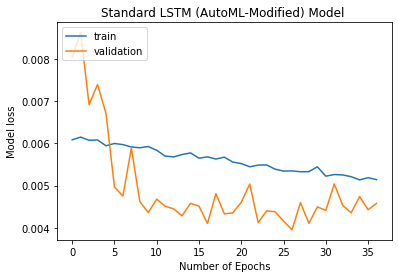

In [692]:
# best modelfor customized LSTM
import matplotlib.pyplot as plt
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Standard LSTM (AutoML-Modified) Model ')
plt.ylabel('Model loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

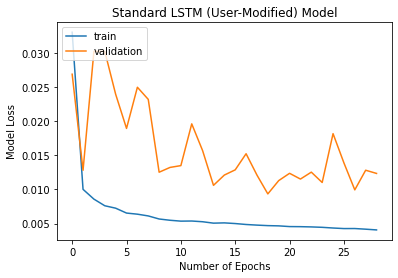

In [693]:
# Default model for the Customized LSTM
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Standard LSTM (User-Modified) Model')
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

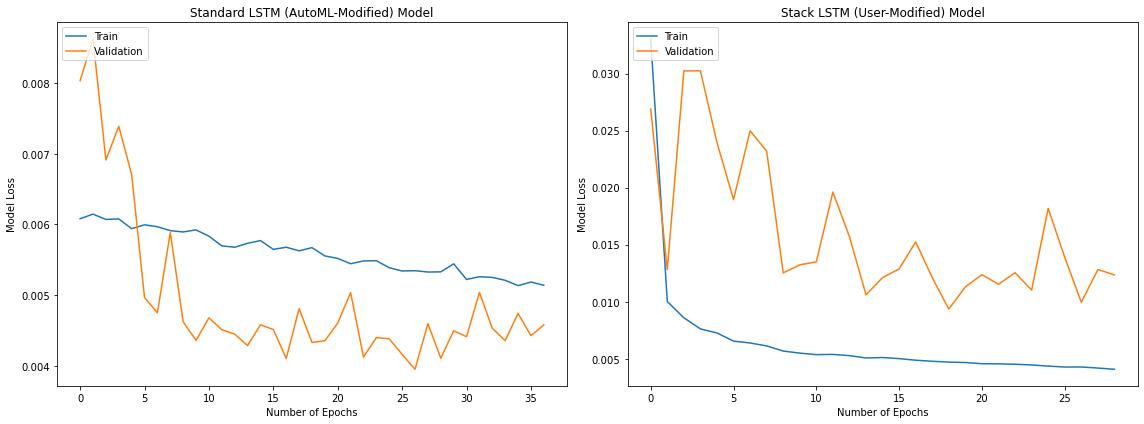

In [694]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the model loss for the first dataset on the left subplot
ax1.plot(history4.history['loss'])
ax1.plot(history4.history['val_loss'])
ax1.set_title('Standard LSTM (AutoML-Modified) Model')
ax1.set_ylabel('Model Loss')
ax1.set_xlabel('Number of Epochs')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the model loss for the second dataset on the right subplot
ax2.plot(history3.history['loss'])
ax2.plot(history3.history['val_loss'])
ax2.set_title('Stack LSTM (User-Modified) Model')
ax2.set_ylabel('Model Loss')
ax2.set_xlabel('Number of Epochs')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.tight_layout()
plt.show()

In [695]:
# best model
test_predictions_h = best_model_cust.predict(X_val)
h_op_list= []
for i in range (0, len(test_predictions_h)):
  h_op_list.append((test_predictions_h[i][1]))
len(h_op_list)

109/109 [==============================] - 0s 3ms/step


3464

In [696]:
# my model
test_predictions = model3.predict(X_val)
op_lists= []
for i in range (0, len(test_predictions)):
  op_lists.append((test_predictions[i][1]))
len(op_lists)

109/109 [==============================] - 1s 7ms/step


3464

In [697]:
# best model list
h_op_list

[0.8308456,
 0.6826693,
 0.5226198,
 0.36076367,
 0.27985942,
 0.23412406,
 0.23219247,
 0.25491974,
 0.25117227,
 0.35371757,
 0.39358732,
 0.53888905,
 0.6095238,
 0.6204473,
 0.75609875,
 0.8586639,
 0.9070685,
 0.9302428,
 0.9090321,
 0.85178816,
 0.8235935,
 0.8105829,
 0.8304323,
 0.86582196,
 0.8027277,
 0.582553,
 0.5039888,
 0.39881477,
 0.32583618,
 0.27940917,
 0.31763428,
 0.29103613,
 0.3779573,
 0.49775624,
 0.47554576,
 0.5065504,
 0.72672796,
 0.889423,
 0.9067193,
 0.9303796,
 0.99589276,
 0.9736413,
 0.9845327,
 0.91938937,
 0.871281,
 0.8528532,
 0.8847114,
 0.83703697,
 0.74167514,
 0.60897267,
 0.55644804,
 0.46792188,
 0.45930046,
 0.49657205,
 0.46881366,
 0.45878056,
 0.56068873,
 0.5841966,
 0.69457924,
 0.77287513,
 0.8064878,
 0.83993524,
 0.8894051,
 0.89303756,
 0.89846694,
 0.89571154,
 0.8997587,
 0.85783494,
 0.86396325,
 0.8151418,
 0.81975716,
 0.7882323,
 0.69541156,
 0.579838,
 0.63721776,
 0.6198466,
 0.53319895,
 0.5374743,
 0.5279427,
 0.49208117,

In [698]:
# Actual list
test_labels = pd.DataFrame({'Settlement Point Price':(Y_val[:,1])})
#test_labels.rename(columns = {(Y_test.shape[1]):'actual'}, inplace = True)
#test_labels['actual']
test_labels['Settlement Point Price']

0       0.81502
1       0.67267
2       0.46096
3       0.33333
4       0.28428
         ...   
3459    0.62713
3460    0.60561
3461    0.57658
3462    0.30244
3463    0.12346
Name: Settlement Point Price, Length: 3464, dtype: float64

In [699]:
np.reshape(test_labels, (-1,1))
test_labels.shape

(3464, 1)

In [700]:
test_labels['Settlement Point Price']=ct.named_transformers_['y'].inverse_transform(test_labels)
test_labels['Settlement Point Price']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: Settlement Point Price, Length: 3464, dtype: float64

In [701]:
# best model List
predictions_h=pd.DataFrame({'Settlement Point Price':h_op_list})
predictions_h['Settlement Point Price'] = ct.named_transformers_['y'].inverse_transform(predictions_h)

In [702]:
# my model list
predictions_C=pd.DataFrame({'Settlement Point Price':op_lists})
predictions_C['Settlement Point Price'] = ct.named_transformers_['y'].inverse_transform(predictions_C)

C:\Users\Abhishek\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Settlement Point Price'>

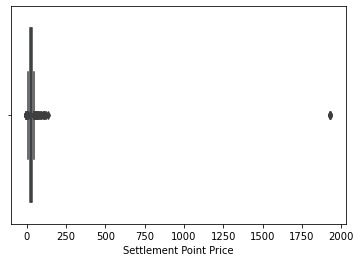

In [703]:
sns.boxplot(predictions_h['Settlement Point Price'])

In [861]:
# here we considered to remove any irregularities in the data
def remove_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]
predictions_cl=remove_outliers_iqr(predictions_C['Settlement Point Price'])
predictions_hl=remove_outliers_iqr(predictions_h['Settlement Point Price'])
test_labels_a=remove_outliers_iqr(test_labels['Settlement Point Price'])

<AxesSubplot:ylabel='Settlement Point Price'>

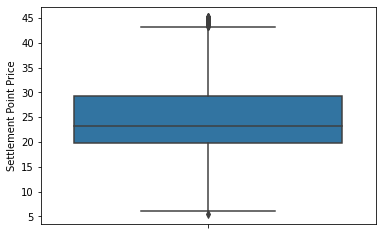

In [705]:
sns.boxplot(y=predictions_hl)

<AxesSubplot:ylabel='Settlement Point Price'>

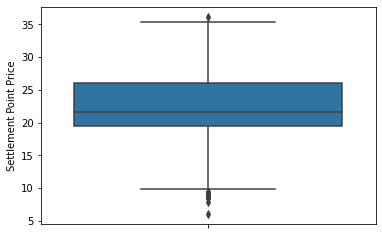

In [706]:
sns.boxplot(y=predictions_C['Settlement Point Price'])

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_11388\63967361.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["User modified data without outliers","Settlement Point Price"])
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_11388\63967361.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(["Data 2","Settlement Point Price"])


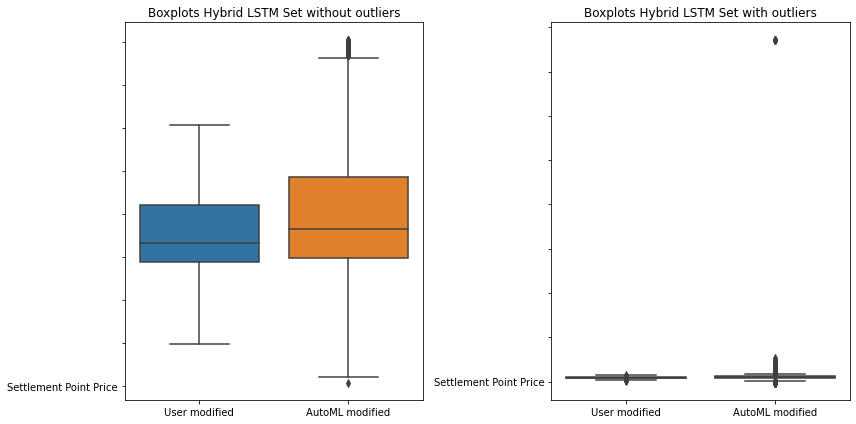

In [707]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
# user
data1 = predictions_cl
data2 = predictions_C['Settlement Point Price']

# best
data3 = predictions_h['Settlement Point Price']
data4 = predictions_hl

# Create a figure with two sets of subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of boxplots in the first subplot
sns.boxplot(data=[data1, data4], ax=axs[0])
axs[0].set_title("Boxplots Hybrid LSTM Set without outliers")
axs[0].set_yticklabels(["User modified data without outliers","Settlement Point Price"])
axs[0].set_xticklabels(["User modified", "AutoML modified"])

# Plot the second set of boxplots in the second subplot
sns.boxplot(data=[data2, data3], ax=axs[1])
axs[1].set_title("Boxplots Hybrid LSTM Set with outliers")
axs[1].set_yticklabels(["Data 2","Settlement Point Price"])
axs[1].set_xticklabels(["User modified", "AutoML modified"])

# Adjust spacing between subplots
plt.tight_layout()

# Display the two sets of boxplots side by side
plt.show()


In [708]:
max(predictions_hl)

45.23377227783203

In [709]:
max(predictions_cl)

35.278682708740234

In [710]:
max(test_labels_a)

48.86211034714723

In [711]:
max(predictions_h['Settlement Point Price'])

1930.3199462890625

In [712]:
predictions_h['Settlement Point Price']

0       28.950737
1       23.639599
2       20.710972
3       19.070000
4       18.255796
          ...    
3459    23.247545
3460    26.229166
3461    21.247639
3462    22.362158
3463    17.860001
Name: Settlement Point Price, Length: 3464, dtype: float32

In [713]:
predictions_hl

0       28.950737
1       23.639599
2       20.710972
3       19.070000
4       18.255796
          ...    
3459    23.247545
3460    26.229166
3461    21.247639
3462    22.362158
3463    17.860001
Name: Settlement Point Price, Length: 3316, dtype: float32

In [714]:
# mean_squared_error(test_labels,predictions_h)

In [715]:
mean_squared_error(test_labels_a[:3100],predictions_hl[:3100])

95.79946187514699

In [716]:
r2_score(test_labels_a[:3100],predictions_hl[:3100])

-0.6123577702142118

In [717]:
test_labels['Settlement Point Price']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: Settlement Point Price, Length: 3464, dtype: float64

In [718]:
mean_squared_error(test_labels['Settlement Point Price'], predictions_h['Settlement Point Price'])


7128.731342992662

In [719]:
mean_squared_error(test_labels['Settlement Point Price'], predictions_C['Settlement Point Price'])


151.71696975932844

In [720]:
r2_score(test_labels['Settlement Point Price'], predictions_h['Settlement Point Price'])

-36.24136812989495

In [721]:
r2_score(test_labels['Settlement Point Price'], predictions_C['Settlement Point Price'])

0.2074119151771341

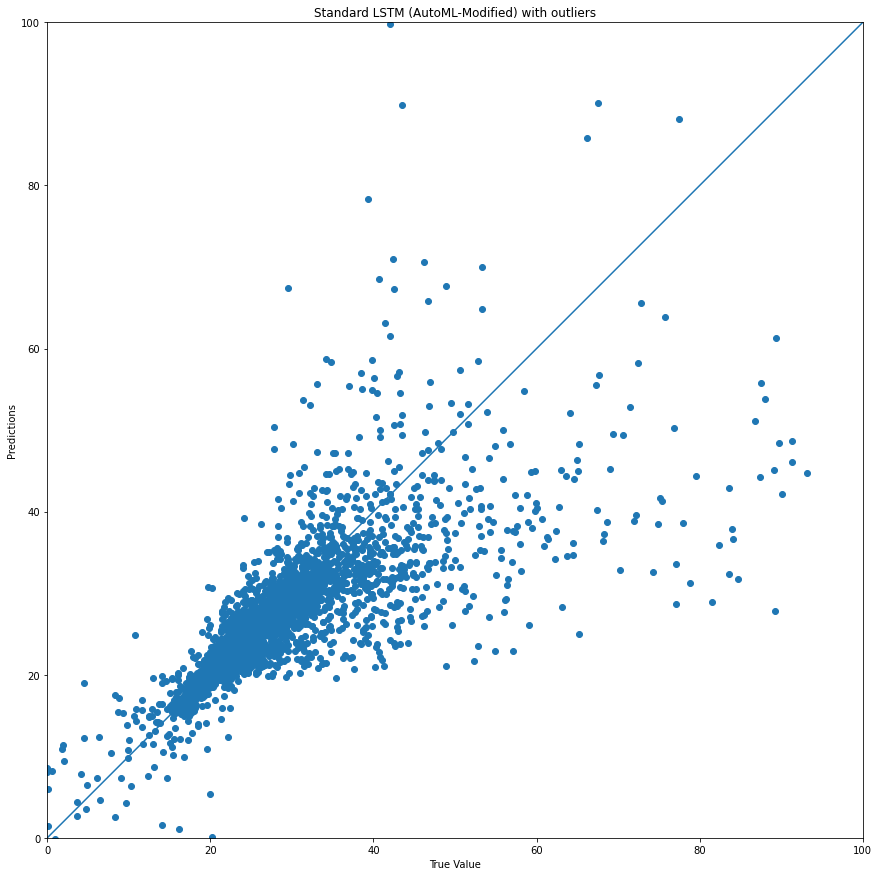

In [722]:
# best model graph
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'], predictions_h)
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Standard LSTM (AutoML-Modified) with outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

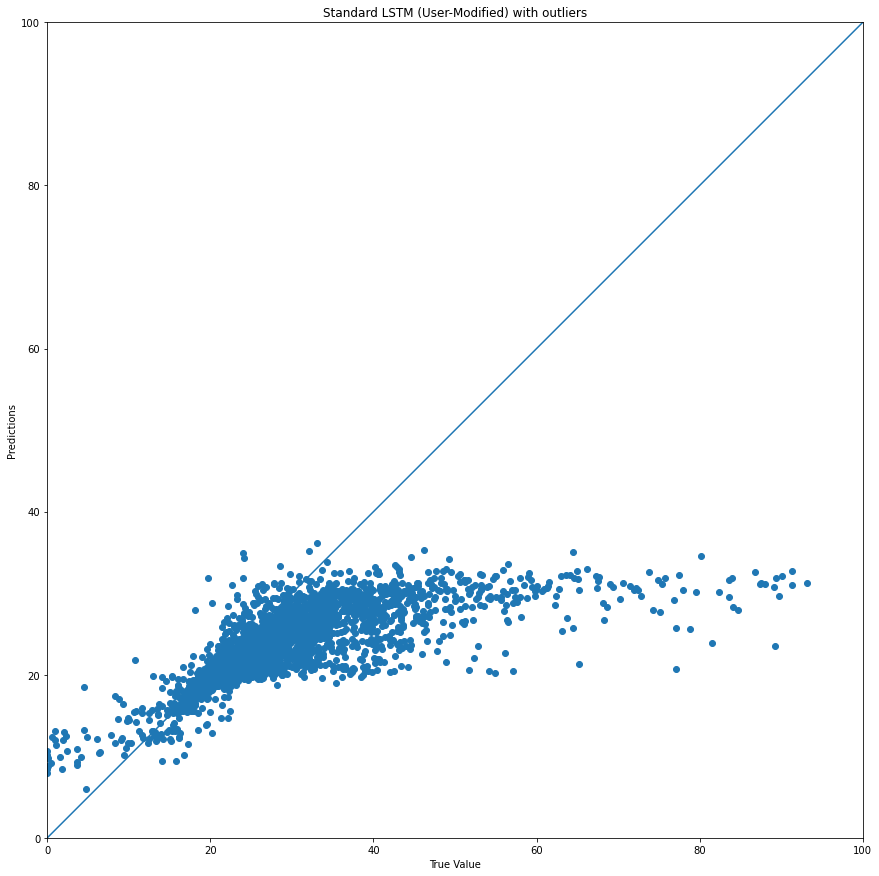

In [723]:
# my model graph
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'], predictions_C)
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Standard LSTM (User-Modified) with outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

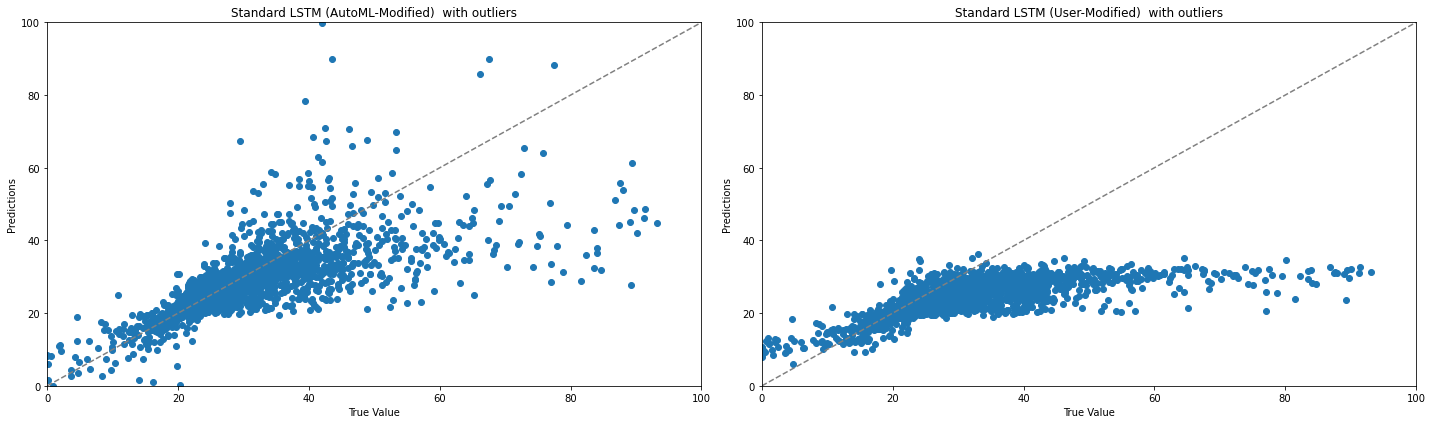

In [724]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the scatter plot for the best model on the left subplot
axes[0].scatter(test_labels['Settlement Point Price'], predictions_h)
axes[0].set_title('Standard LSTM (AutoML-Modified)  with outliers')
axes[0].set_xlabel('True Value')
axes[0].set_ylabel('Predictions')
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 100])
axes[0].plot([0, 100], [0, 100], linestyle='--', color='gray')  # Add a diagonal line

# Plot the scatter plot for your model on the right subplot
axes[1].scatter(test_labels['Settlement Point Price'], predictions_C)
axes[1].set_title('Standard LSTM (User-Modified)  with outliers')
axes[1].set_xlabel('True Value')
axes[1].set_ylabel('Predictions')
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])
axes[1].plot([0, 100], [0, 100], linestyle='--', color='gray')  # Add a diagonal line

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


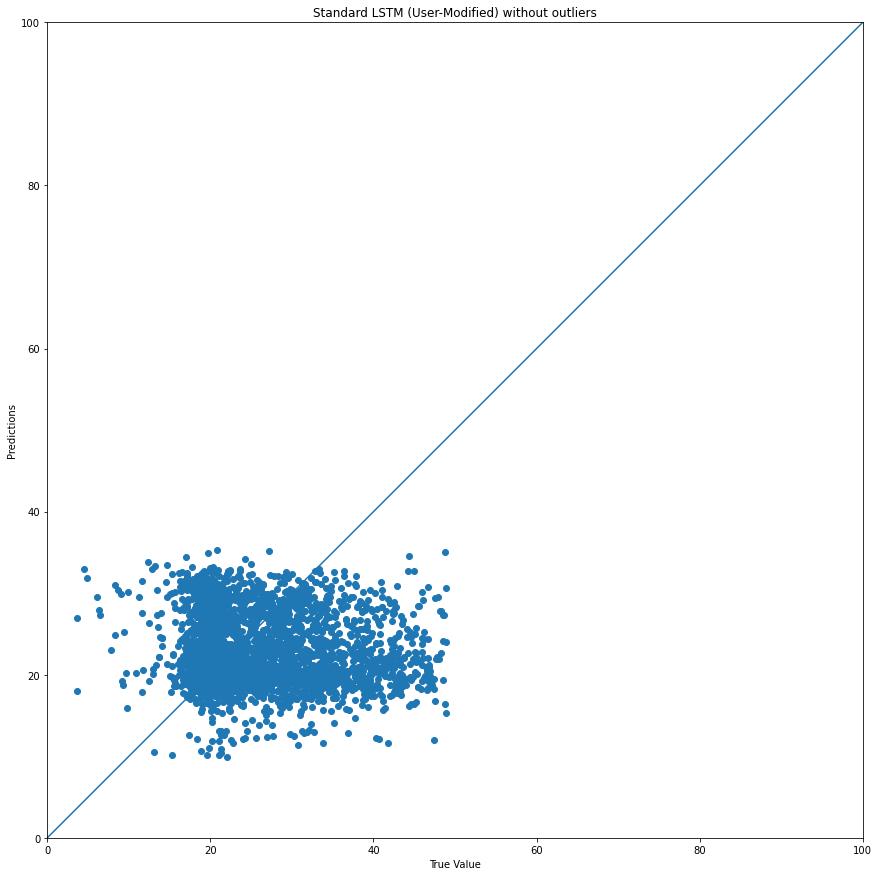

In [725]:
# After removing the outliers for the user model
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels_a[:3000], predictions_cl[:3000])
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Standard LSTM (User-Modified) without outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

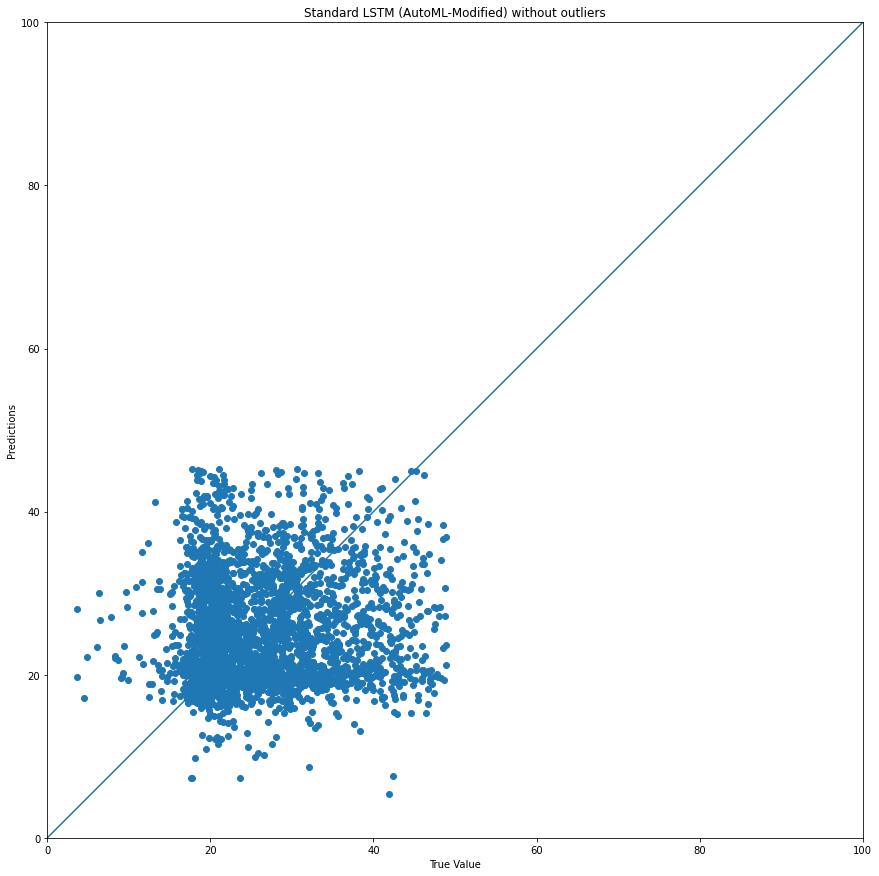

In [726]:
# After removing the outliers for the best model
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels_a[:3000], predictions_hl[:3000])
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Standard LSTM (AutoML-Modified) without outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

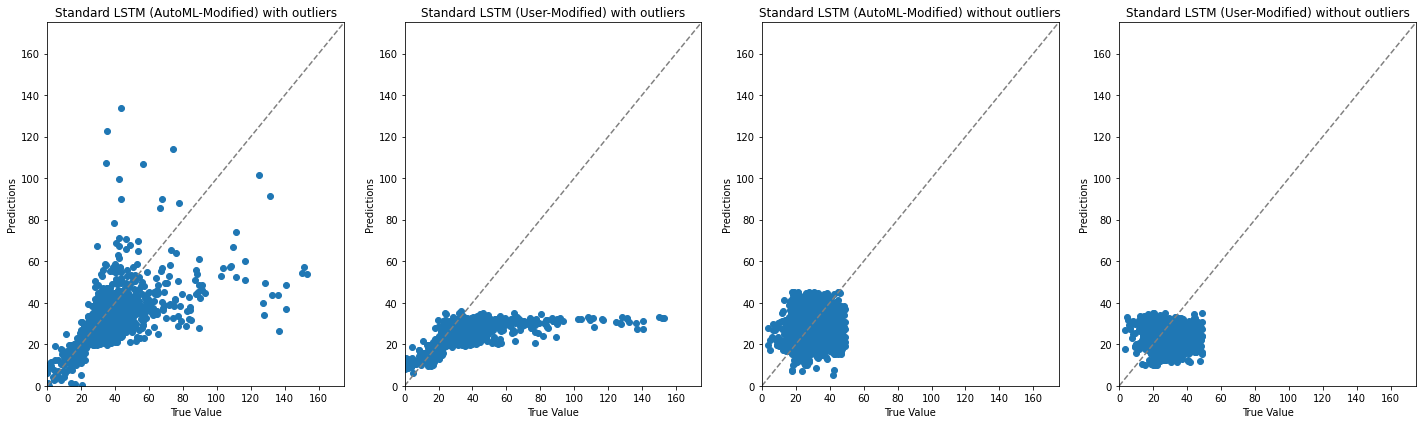

In [727]:

import matplotlib.pyplot as plt

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
# Plot the first scatter plot on the left subplot
axes[0].scatter(test_labels['Settlement Point Price'], predictions_h)
axes[0].set_title('Standard LSTM (AutoML-Modified) with outliers')
axes[0].set_xlabel('True Value')
axes[0].set_ylabel('Predictions')
axes[0].set_xlim([0, 175])
axes[0].set_ylim([0, 175])
axes[0].plot([0, 175], [0, 175], linestyle='--', color='gray')  # Add a diagonal line

# Plot the second scatter plot in the middle subplot
axes[1].scatter(test_labels['Settlement Point Price'], predictions_C)
axes[1].set_title('Standard LSTM (User-Modified) with outliers')
axes[1].set_xlabel('True Value')
axes[1].set_ylabel('Predictions')
axes[1].set_xlim([0, 175])
axes[1].set_ylim([0, 175])
axes[1].plot([0, 175], [0, 175], linestyle='--', color='gray')  # Add a diagonal line

# Plot the third scatter plot on the right subplot
axes[2].scatter(test_labels_a[:3000], predictions_hl[:3000])
axes[2].set_title('Standard LSTM (AutoML-Modified) without outliers')
axes[2].set_xlabel('True Value')
axes[2].set_ylabel('Predictions')
axes[2].set_xlim([0, 175])
axes[2].set_ylim([0, 175])
axes[2].plot([0, 175], [0, 175], linestyle='--', color='gray')  # Add a diagonal line
# Plot the third scatter plot on the right subplot
axes[3].scatter(test_labels_a[:3000], predictions_cl[:3000])
axes[3].set_title('Standard LSTM (User-Modified) without outliers')
axes[3].set_xlabel('True Value')
axes[3].set_ylabel('Predictions')
axes[3].set_xlim([0, 175])
axes[3].set_ylim([0, 175])
axes[3].plot([0, 175], [0, 175], linestyle='--', color='gray')  # Add a diagonal line

# Adjust the spacing between subplots
plt.tight_layout()
# Display the plots
plt.show()

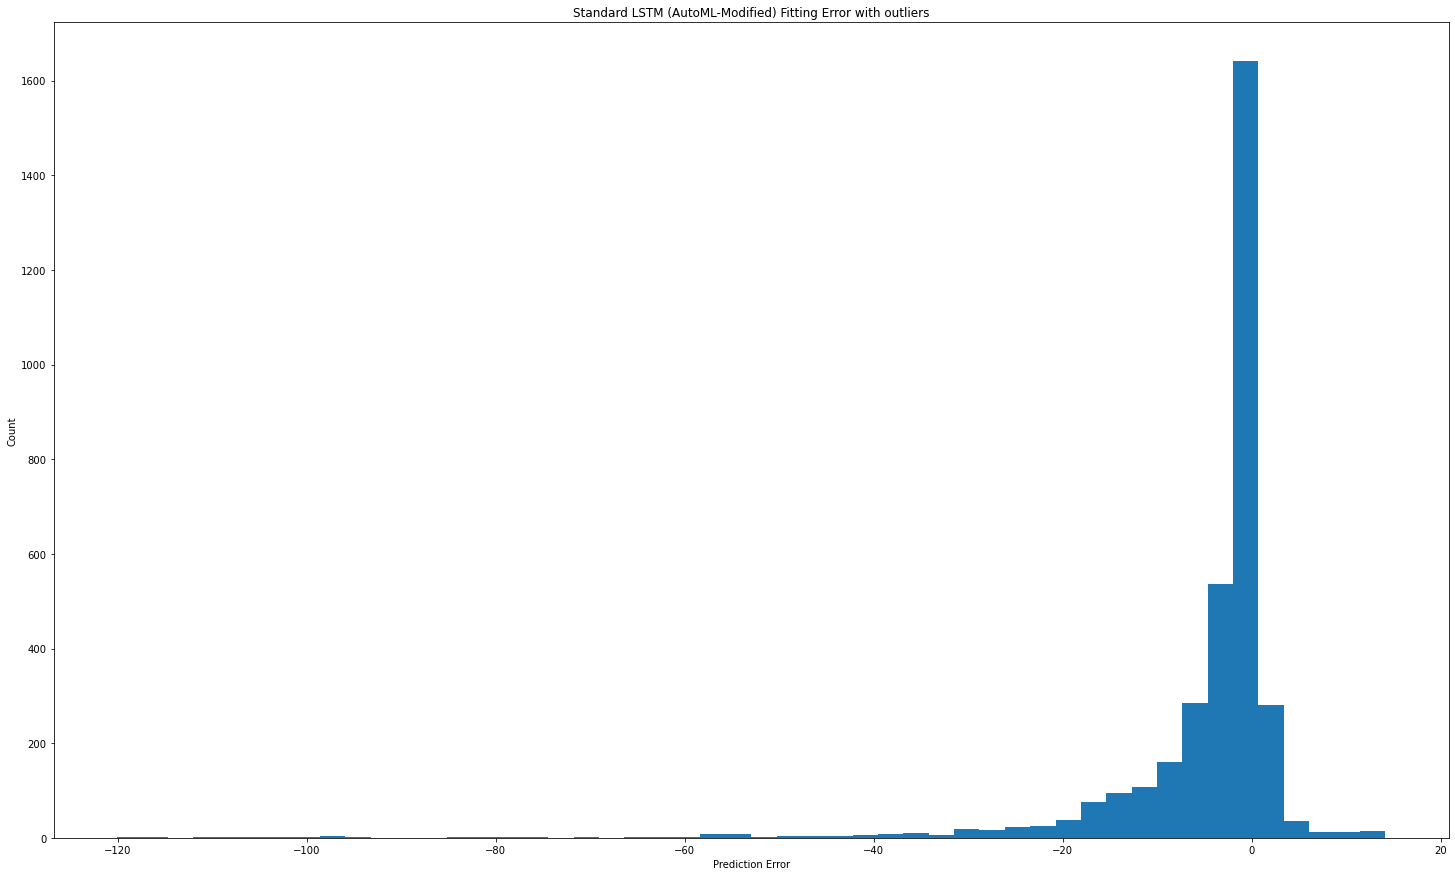

In [728]:
# prediction_h is for the best model
error_h = round(predictions_h['Settlement Point Price'],2) - round(test_labels['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Standard LSTM (AutoML-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")

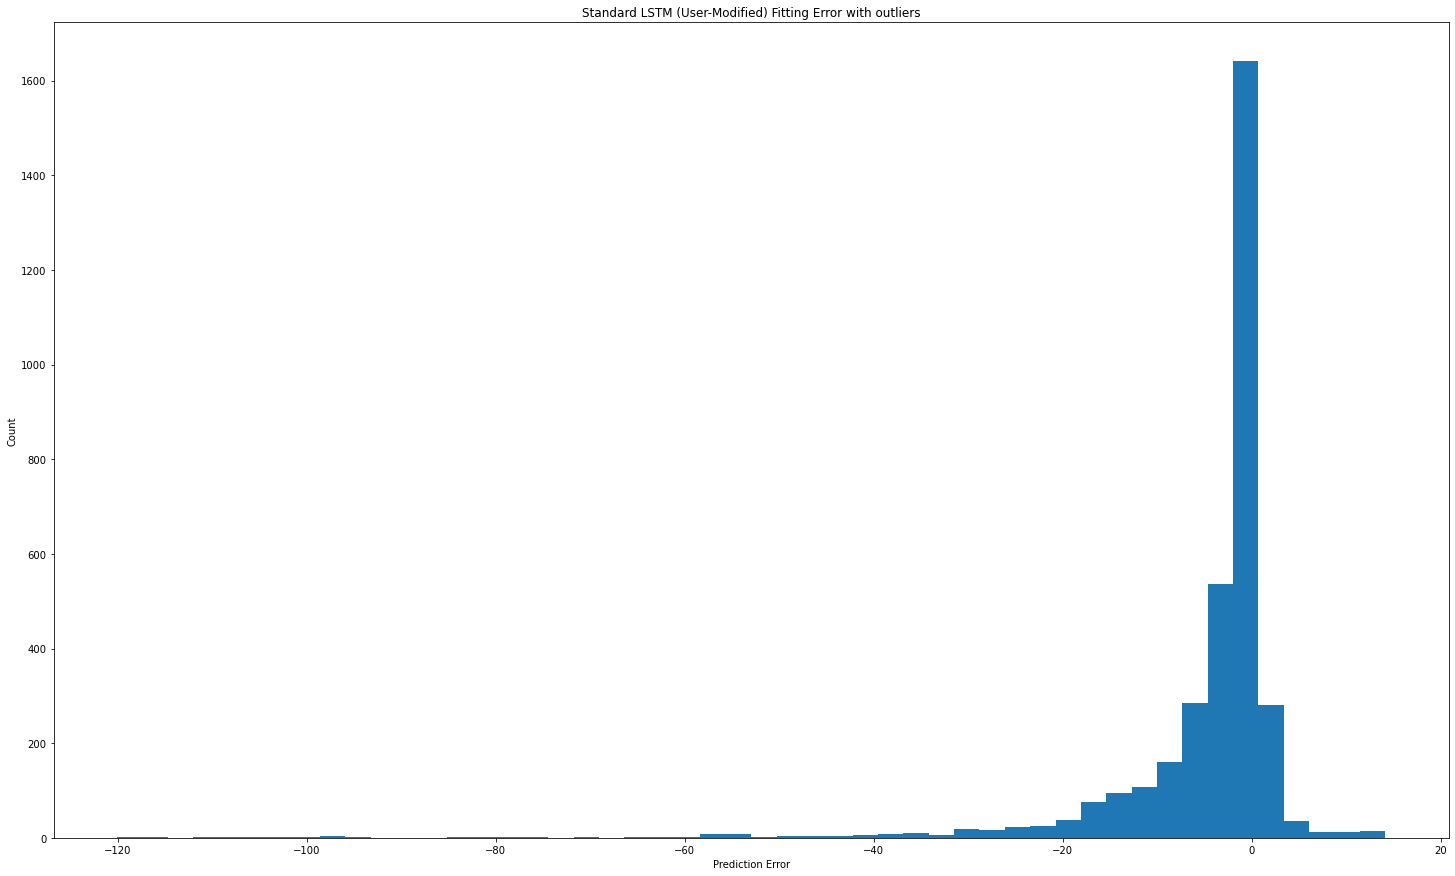

In [729]:
# prediction_C is for the user model
error_C = round(predictions_C['Settlement Point Price'],2) - round(test_labels['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Standard LSTM (User-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")

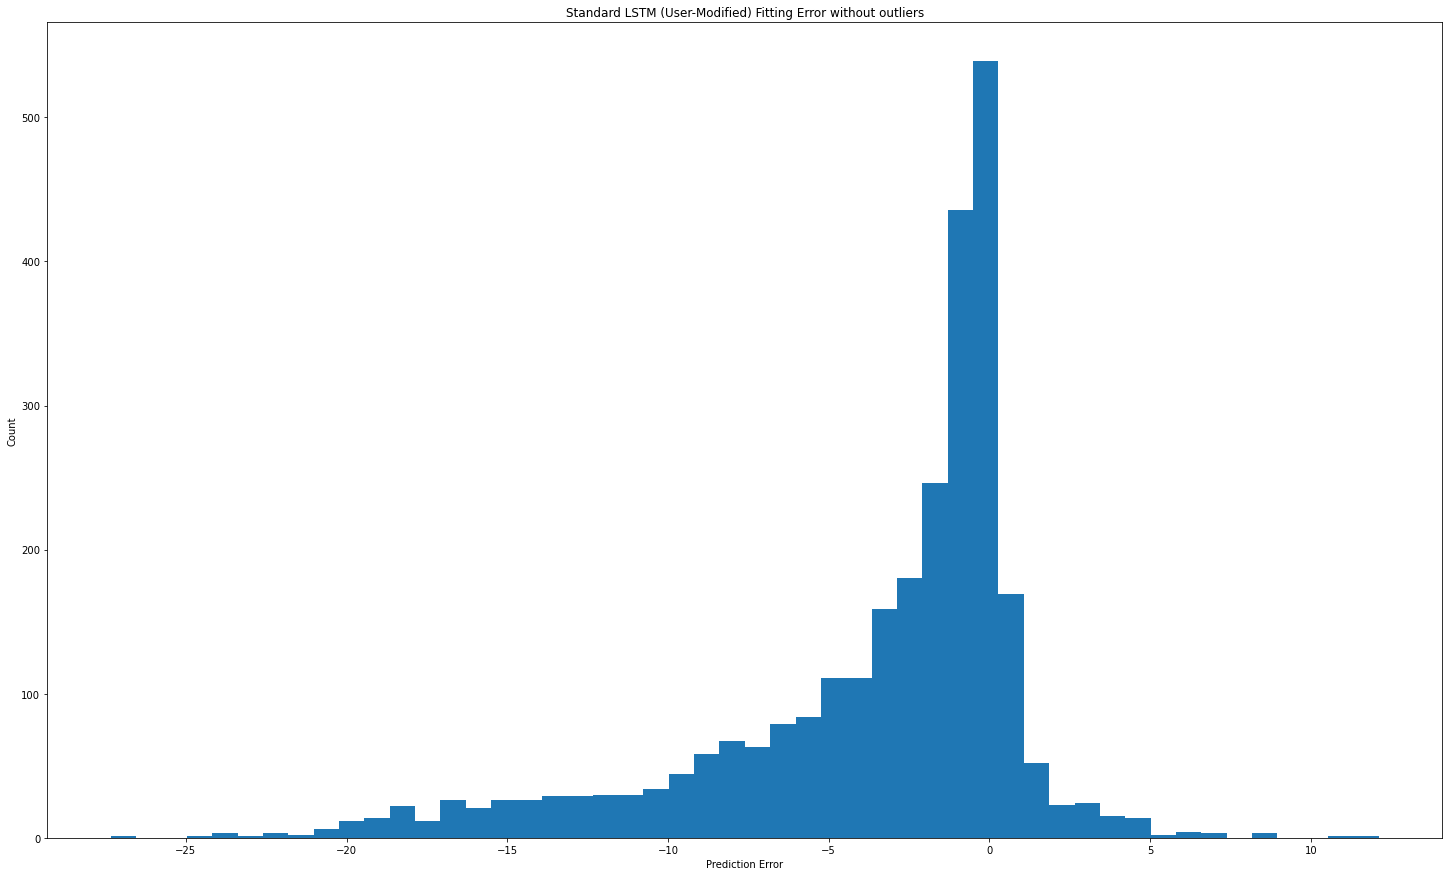

In [730]:
# constrained model without outliers
error_co = round(predictions_cl[:3000],2) - round(test_labels_a[:3000],2)
error_co=error_co[:3000]
plt.figure(figsize=(25,15))
plt.hist(error_co, bins = 50)
plt.title('Standard LSTM (User-Modified) Fitting Error without outliers')
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

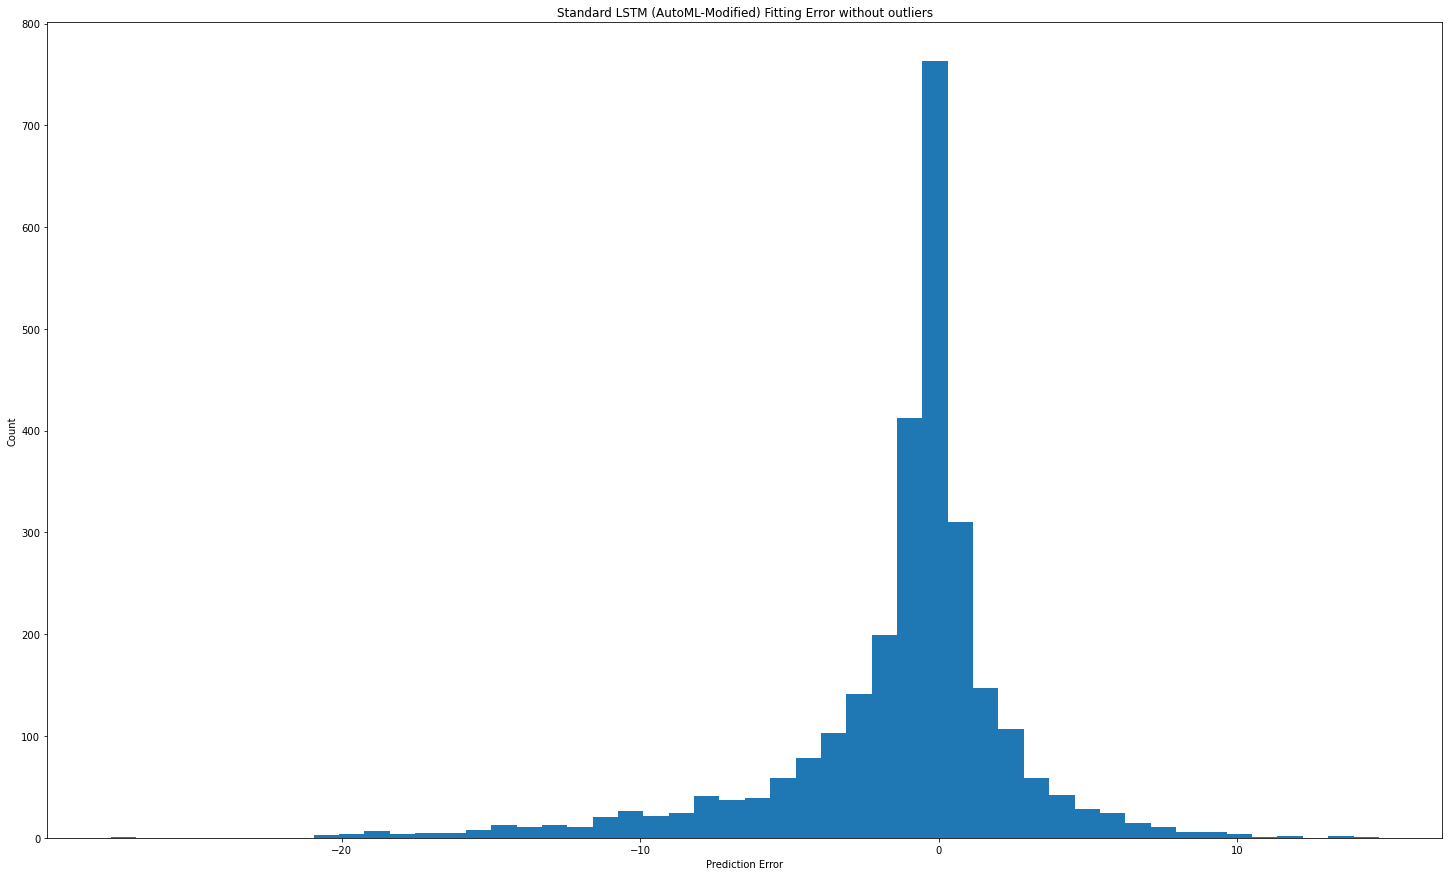

In [731]:
# constrained model without outliers
error_s = round(predictions_hl[:3000],2) - round(test_labels_a[:3000],2)
error_s=error_s[:3000]
plt.figure(figsize=(25,15))
plt.hist(error_s, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Standard LSTM (AutoML-Modified) Fitting Error without outliers')
_ = plt.ylabel("Count")

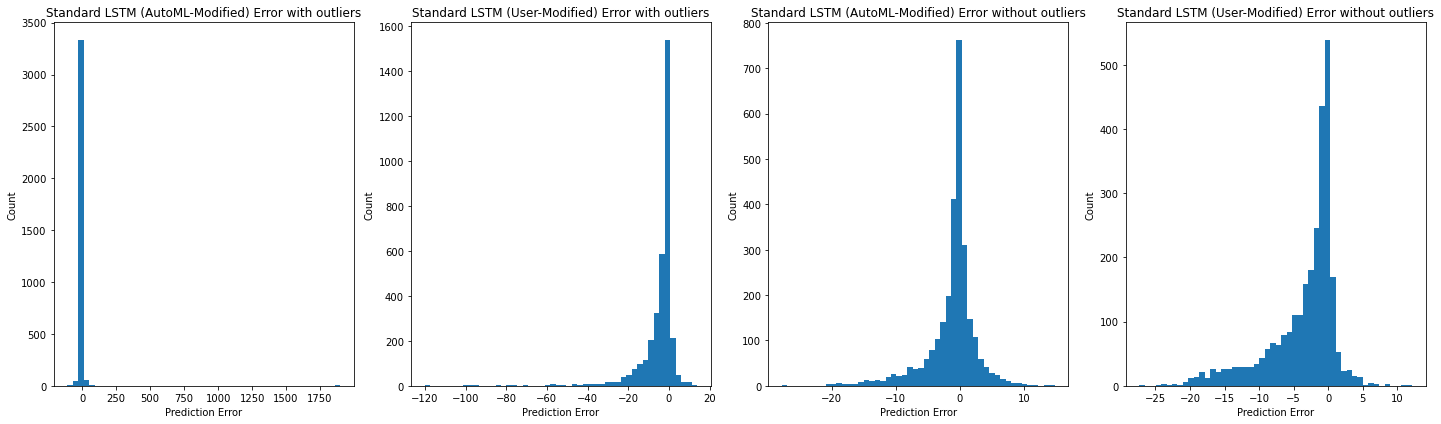

In [732]:
import matplotlib.pyplot as plt

# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Plot the first histogram on the left subplot
axes[0].hist(error_h, bins=50)
axes[0].set_title('Standard LSTM (AutoML-Modified) Error with outliers')
axes[0].set_xlabel("Prediction Error")
axes[0].set_ylabel("Count")

# Plot the second histogram in the middle subplot
axes[1].hist(error_C, bins=50)
axes[1].set_title('Standard LSTM (User-Modified) Error with outliers')
axes[1].set_xlabel("Prediction Error")
axes[1].set_ylabel("Count")

# Plot the third histogram on the right subplot
axes[2].hist(error_s, bins=50)
axes[2].set_title('Standard LSTM (AutoML-Modified) Error without outliers')
axes[2].set_xlabel("Prediction Error")
axes[2].set_ylabel("Count")

# Plot the third histogram on the right subplot
axes[3].hist(error_co, bins=50)
axes[3].set_title('Standard LSTM (User-Modified) Error without outliers')
axes[3].set_xlabel("Prediction Error")
axes[3].set_ylabel("Count")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [733]:
print(predictions_h[0:10], test_labels['Settlement Point Price'][0:10], error[0:10])

   Settlement Point Price
0               28.950737
1               23.639599
2               20.710972
3               19.070000
4               18.255796
5               17.738899
6               17.719603
7               17.986649
8               17.938421
9               19.003639 0    28.210249
1    23.379947
2    19.990000
3    18.819967
4    18.309957
5    17.839968
6    17.729968
7    17.589966
8    18.220054
9    19.179966
Name: Settlement Point Price, dtype: float64 0   -4.080001
1   -1.710000
2    0.340000
3    0.180000
4    0.020000
5    0.310000
6    0.210001
7    0.580000
8    0.010000
9    0.029999
Name: Settlement Point Price, dtype: float64


In [734]:
# best model count
i=0
count=0
for i in range(len(error_h)):
    if ((error_h[i])>5) or ((error_h[i]<-5)):
        count=count+1
print(count)

700


In [735]:
# best model
a = len(predictions_h) - count
a
accuracy = (a/len(predictions_h))*100
print('accuracy:', accuracy)

accuracy: 79.79214780600462


In [736]:
# user model
i=0
count=0
for i in range(len(error_C)):
    if ((error_C[i])>5) or ((error_C[i]<-5)):
        count=count+1
print(count)

1057


In [737]:
a = len(predictions_C) - count
a
accuracy = (a/len(predictions_h))*100
print('accuracy:', accuracy)

accuracy: 69.48614318706697


In [738]:
error_s=(error_s.reset_index()['Settlement Point Price'])

In [739]:
# Constrained model 
i=0
count_s=0
for i in range(len(error_s)):
    if ((error_s[i])>5) or ((error_s[i]<-5)):
        count_s=count_s+1
print(count_s)

417


In [740]:
# Constrained model 
a = len(predictions_h) - count_s
a
accuracy = (a/len(predictions_h))*100
print('accuracy:', accuracy)

accuracy: 87.96189376443418


In [741]:
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_h)):
        if ((error_h[i])>j) or ((error_h[i]<-j)):
            count=count+1
    a = len(predictions_h) - count
    accuracy = (a/len(predictions_h))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 42.98
accuracy: with threshold of 2  is 59.27
accuracy: with threshold of 3  is 69.14
accuracy: with threshold of 4  is 75.23
accuracy: with threshold of 5  is 79.79
accuracy: with threshold of 6  is 82.82
accuracy: with threshold of 7  is 85.08
accuracy: with threshold of 8  is 87.04
accuracy: with threshold of 9  is 88.48
accuracy: with threshold of 10  is 89.69


Accuracy with a threshold of 1  is 42.98
MSE with a threshold of 1  is 0.25
MAE with a threshold of 1  is 0.41


Accuracy with a threshold of 2  is 59.27
MSE with a threshold of 2  is 0.78
MAE with a threshold of 2  is 0.70


Accuracy with a threshold of 3  is 69.14
MSE with a threshold of 3  is 1.53
MAE with a threshold of 3  is 0.95


Accuracy with a threshold of 4  is 75.23
MSE with a threshold of 4  is 2.39
MAE with a threshold of 4  is 1.15


Accuracy with a threshold of 5  is 79.79
MSE with a threshold of 5  is 3.38
MAE with a threshold of 5  is 1.34


Accuracy with a threshold of 6  is 82.82
MSE with a threshold of 6  is 4.38
MAE with a threshold of 6  is 1.49


Accuracy with a threshold of 7  is 85.08
MSE with a threshold of 7  is 5.39
MAE with a threshold of 7  is 1.62


Accuracy with a threshold of 8  is 87.04
MSE with a threshold of 8  is 6.53
MAE with a threshold of 8  is 1.76


Accuracy with a threshold of 9  is 88.48
MSE with a threshold of 9  is 7.61
MAE with a threshold

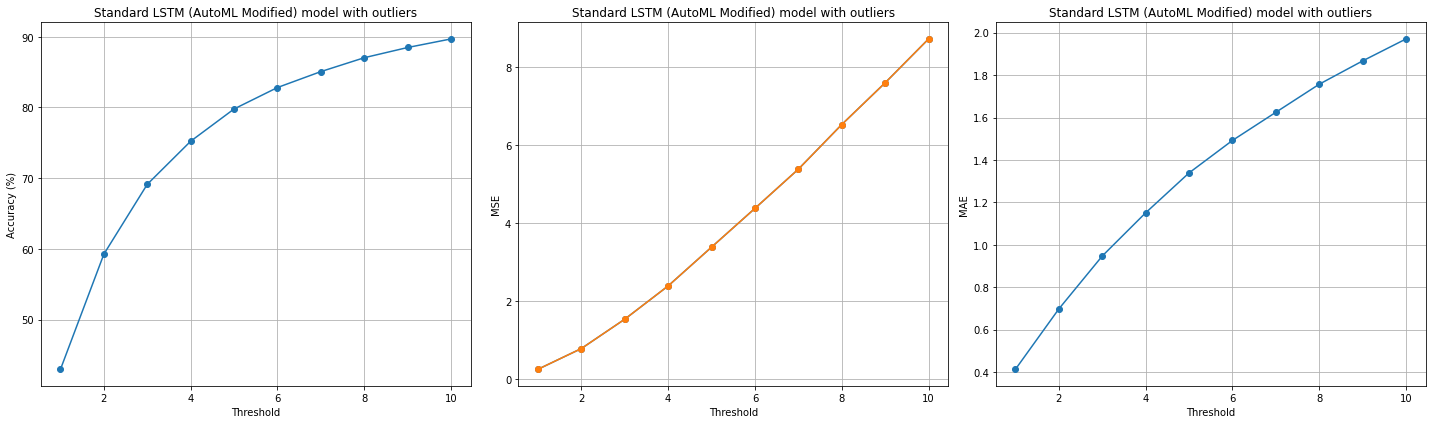

In [742]:
# best model with outliers
import numpy as np
import matplotlib.pyplot as plt



mse_values5 = []
mae_values5 = []
accuracy_values5 = []

for j in range(1, 11):
    count = 0
    squared_errors5 = []  # List to store squared errors for MSE calculation
    absolute_errors5 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_h)):  # Make sure error_u_out is defined
        if (error_h[i] > j) or (error_h[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors5.append((error_h[i]) ** 2)
            absolute_errors5.append(abs(error_h[i]))
             
    a = len(predictions_h) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.mean(squared_errors5) if squared_errors4 else 0.0
    mae = np.mean(absolute_errors5) if absolute_errors4 else 0.0
    
    mse_values5.append(mse)
    mae_values5.append(mae)
    
    accuracy = (a / len(predictions_h)) * 100
    accuracy_values5.append(accuracy)
    
    # Calculate R2 score for the current threshold
    actual_values = test_labels_a[:3000]  # Replace with your actual values
    predicted_values = predictions_h[:3000]  # Replace with your predicted values
 
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, MAE, and R2
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Increase to 4 subplots

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values5, marker='o', linestyle='-')
axes[0].set_title("Standard LSTM (AutoML Modified) model with outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values5, marker='o', linestyle='-')
axes[1].plot(range(1, 11), mse_values5, marker='o', linestyle='-')
axes[1].set_title("Standard LSTM (AutoML Modified) model with outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values5, marker='o', linestyle='-')
axes[2].set_title("Standard LSTM (AutoML Modified) model with outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [743]:
# thresholds = []
# accuracies = []

# for j in range(1, 11):
#     i = 0
#     count = 0
#     for i in range(len(error)):
#         if ((error[i]) > j) or ((error[i] < -j)):
#             count += 1
#     a = len(predictions_h) - count
#     accuracy = (a / len(predictions_h)) * 100
#     thresholds.append(j)
#     accuracies.append(accuracy)
#     print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)

# # Create a line plot
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, accuracies, marker='o', linestyle='-')
# plt.title("Threshold vs. Accuracy")
# plt.xlabel("Threshold")
# plt.ylabel("Accuracy (%)")
# plt.grid(True)
# plt.xticks(range(1, 11))
# plt.show()


In [744]:
count

357

In [745]:
# a = len(predictions_hl) - count
# a
# accuracy = (a/len(predictions_hl))*100
# print('accuracy:', accuracy)

Accuracy with a threshold of 1  is 54.55
MSE with a threshold of 1  is 0.24
MAE with a threshold of 1  is 0.41


Accuracy with a threshold of 2  is 68.88
MSE with a threshold of 2  is 0.76
MAE with a threshold of 2  is 0.68


Accuracy with a threshold of 3  is 77.77
MSE with a threshold of 3  is 1.51
MAE with a threshold of 3  is 0.93


Accuracy with a threshold of 4  is 83.32
MSE with a threshold of 4  is 2.36
MAE with a threshold of 4  is 1.14


Accuracy with a threshold of 5  is 87.42
MSE with a threshold of 5  is 3.35
MAE with a threshold of 5  is 1.33


Accuracy with a threshold of 6  is 90.08
MSE with a threshold of 6  is 4.31
MAE with a threshold of 6  is 1.47


Accuracy with a threshold of 7  is 92.04
MSE with a threshold of 7  is 5.28
MAE with a threshold of 7  is 1.60


Accuracy with a threshold of 8  is 93.82
MSE with a threshold of 8  is 6.43
MAE with a threshold of 8  is 1.74


Accuracy with a threshold of 9  is 94.96
MSE with a threshold of 9  is 7.39
MAE with a threshold

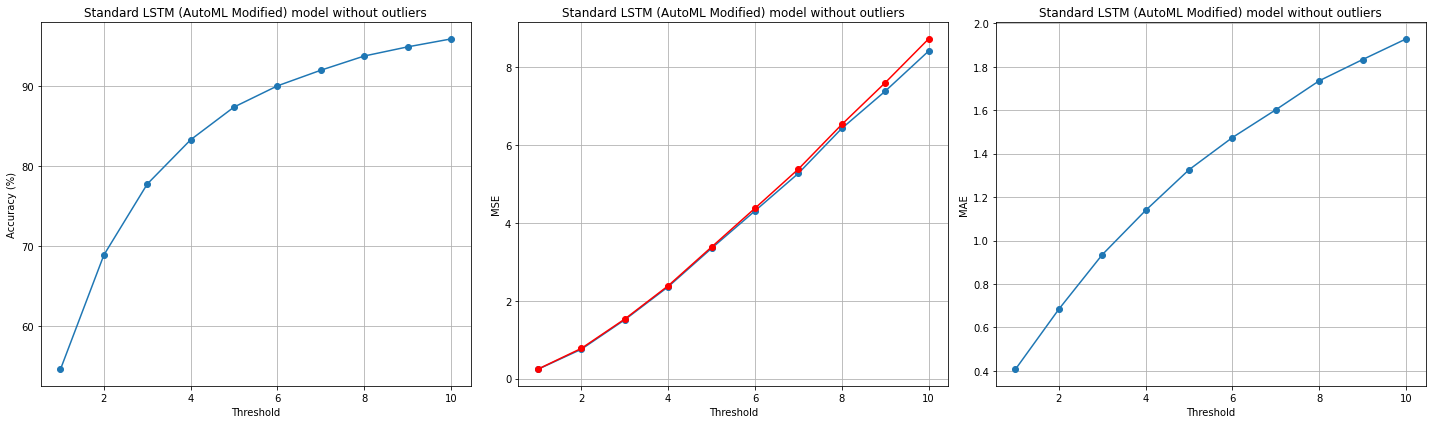

In [746]:
# best model without outliers
import numpy as np
import matplotlib.pyplot as plt



mse_values6 = []
mae_values6 = []
accuracy_values6 = []

for j in range(1, 11):
    count = 0
    squared_errors6 = []  # List to store squared errors for MSE calculation
    absolute_errors6 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_s)):  # Make sure error_u_out is defined
        if (error_s[i] > j) or (error_s[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors6.append((error_s[i]) ** 2)
            absolute_errors6.append(abs(error_s[i]))
             
    a = len(predictions_hl) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.nanmean(squared_errors6) if squared_errors5 else 0.0
    mae = np.nanmean(absolute_errors6) if absolute_errors5 else 0.0
    
    mse_values6.append(mse)
    mae_values6.append(mae)
    
    accuracy = (a / len(predictions_hl)) * 100
    accuracy_values6.append(accuracy)
    
    # Calculate R2 score for the current threshold
    actual_values = test_labels_a[:3000]  # Replace with your actual values
    predicted_values = predictions_hl[:3000]  # Replace with your predicted values
 
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, MAE, and R2
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Increase to 4 subplots

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values6, marker='o', linestyle='-')
axes[0].set_title("Standard LSTM (AutoML Modified) model without outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values6, marker='o', linestyle='-')
axes[1].plot(range(1, 11), mse_values5, marker='o', color='red',linestyle='-')
axes[1].set_title("Standard LSTM (AutoML Modified) model without outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values6, marker='o', linestyle='-')
axes[2].set_title("Standard LSTM (AutoML Modified) model without outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [747]:
# user model
error_co=(error_co.reset_index()['Settlement Point Price'])
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_co)):
        if ((error_co[i])>j) or ((error_co[i]<-j)):
            count=count+1
    a = len(predictions_cl) - count
    accuracy = (a/len(predictions_cl))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 47.84
accuracy: with threshold of 2  is 59.51
accuracy: with threshold of 3  is 67.22
accuracy: with threshold of 4  is 73.12
accuracy: with threshold of 5  is 77.61
accuracy: with threshold of 6  is 81.12
accuracy: with threshold of 7  is 84.10
accuracy: with threshold of 8  is 86.48
accuracy: with threshold of 9  is 88.88
accuracy: with threshold of 10  is 90.50


Accuracy with a threshold of 1  is 47.84
MSE with a threshold of 1  is 0.27
MAE with a threshold of 1  is 0.44


Accuracy with a threshold of 2  is 59.51
MSE with a threshold of 2  is 0.81
MAE with a threshold of 2  is 0.73


Accuracy with a threshold of 3  is 67.22
MSE with a threshold of 3  is 1.66
MAE with a threshold of 3  is 1.00


Accuracy with a threshold of 4  is 73.12
MSE with a threshold of 4  is 2.78
MAE with a threshold of 4  is 1.27


Accuracy with a threshold of 5  is 77.61
MSE with a threshold of 5  is 4.10
MAE with a threshold of 5  is 1.51


Accuracy with a threshold of 6  is 81.12
MSE with a threshold of 6  is 5.54
MAE with a threshold of 6  is 1.73


Accuracy with a threshold of 7  is 84.10
MSE with a threshold of 7  is 7.20
MAE with a threshold of 7  is 1.95


Accuracy with a threshold of 8  is 86.48
MSE with a threshold of 8  is 8.94
MAE with a threshold of 8  is 2.14


Accuracy with a threshold of 9  is 88.88
MSE with a threshold of 9  is 11.11
MAE with a threshol

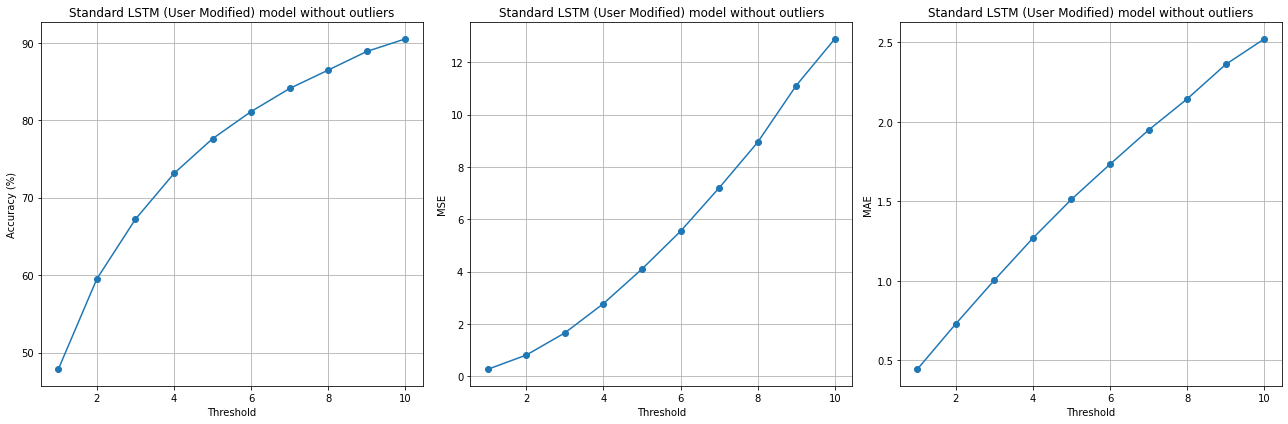

In [748]:
# user model

import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values7 = []
mae_values7 = []
accuracy_values7 = []

for j in range(1, 11):
    count = 0
    squared_errors7 = []  # List to store squared errors for MSE calculation
    absolute_errors7 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_co)):  # Make sure error_u_out is defined
        if (error_co[i] > j) or (error_co[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors7.append((error_co[i]) ** 2)
            absolute_errors7.append(abs(error_co[i]))
             
    a = len(predictions_cl) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.nanmean(squared_errors7) if squared_errors6 else 0.0
    mae = np.nanmean(absolute_errors7) if absolute_errors6 else 0.0
    
    mse_values7.append(mse)
    mae_values7.append(mae)
    
    accuracy = (a / len(predictions_cl)) * 100
    accuracy_values7.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values7, marker='o', linestyle='-')
axes[0].set_title("Standard LSTM (User Modified) model without outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values7, marker='o', linestyle='-')
axes[1].set_title("Standard LSTM (User Modified) model without outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values7, marker='o', linestyle='-')
axes[2].set_title("Standard LSTM (User Modified) model without outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [749]:
# user model
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_C)):
        if ((error_C[i])>j) or ((error_C[i]<-j)):
            count=count+1
    a = len(predictions_C) - count
    accuracy = (a/len(predictions_C))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 32.97
accuracy: with threshold of 2  is 47.63
accuracy: with threshold of 3  is 56.93
accuracy: with threshold of 4  is 64.06
accuracy: with threshold of 5  is 69.49
accuracy: with threshold of 6  is 73.59
accuracy: with threshold of 7  is 77.22
accuracy: with threshold of 8  is 80.11
accuracy: with threshold of 9  is 82.77
accuracy: with threshold of 10  is 84.64


Accuracy with a threshold of 1  is 32.97
MSE with a threshold of 1  is 0.27
MAE with a threshold of 1  is 0.45


Accuracy with a threshold of 2  is 47.63
MSE with a threshold of 2  is 0.86
MAE with a threshold of 2  is 0.76


Accuracy with a threshold of 3  is 56.93
MSE with a threshold of 3  is 1.73
MAE with a threshold of 3  is 1.04


Accuracy with a threshold of 4  is 64.06
MSE with a threshold of 4  is 2.86
MAE with a threshold of 4  is 1.30


Accuracy with a threshold of 5  is 69.49
MSE with a threshold of 5  is 4.22
MAE with a threshold of 5  is 1.55


Accuracy with a threshold of 6  is 73.59
MSE with a threshold of 6  is 5.65
MAE with a threshold of 6  is 1.77


Accuracy with a threshold of 7  is 77.22
MSE with a threshold of 7  is 7.37
MAE with a threshold of 7  is 1.99


Accuracy with a threshold of 8  is 80.11
MSE with a threshold of 8  is 9.17
MAE with a threshold of 8  is 2.19


Accuracy with a threshold of 9  is 82.77
MSE with a threshold of 9  is 11.20
MAE with a threshol

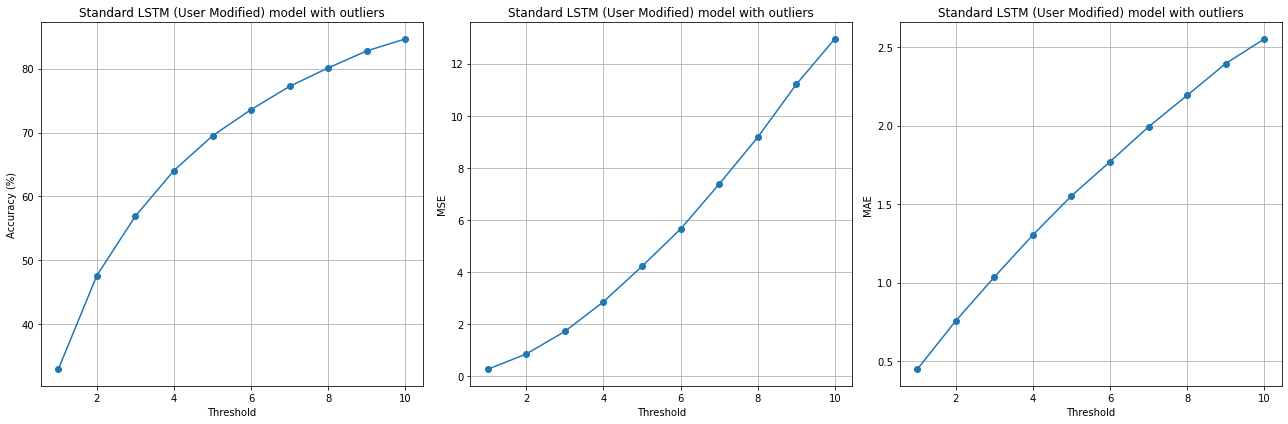

In [750]:
# user model
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE, MAE, and accuracy values
mse_values8 = []
mae_values8 = []
accuracy_values8 = []

for j in range(1, 11):
    count = 0
    squared_errors8 = []  # List to store squared errors for MSE calculation
    absolute_errors8 = []  # List to store absolute errors for MAE calculation
    
    for i in range(len(error_C)):  # Make sure error_u_out is defined
        if (error_C[i] > j) or (error_C[i] < -j):
            count += 1
        else:
            # Calculate squared error and absolute error only if within the threshold
            squared_errors8.append((error_C[i]) ** 2)
            absolute_errors8.append(abs(error_C[i]))
             
    a = len(predictions_C) - count
    
    # Calculate MSE and MAE for the current threshold
    mse = np.mean(squared_errors8) if squared_errors8 else 0.0
    mae = np.mean(absolute_errors8) if absolute_errors8 else 0.0
    
    mse_values8.append(mse)
    mae_values8.append(mae)
    
    accuracy = (a / len(predictions_C)) * 100
    accuracy_values8.append(accuracy)
    
    print("Accuracy with a threshold of %i" % j, " is %.2f" % accuracy)
    print("MSE with a threshold of %i" % j, " is %.2f" % mse)
    print("MAE with a threshold of %i" % j, " is %.2f" % mae)
    print("\n")

# Create subplots for accuracy, MSE, and MAE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
axes[0].plot(range(1, 11), accuracy_values8, marker='o', linestyle='-')
axes[0].set_title("Standard LSTM (User Modified) model with outliers")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Accuracy (%)")
axes[0].grid(True)

# Plot MSE
axes[1].plot(range(1, 11), mse_values8, marker='o', linestyle='-')
axes[1].set_title("Standard LSTM (User Modified) model with outliers")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("MSE")
axes[1].grid(True)

# Plot MAE
axes[2].plot(range(1, 11), mae_values8, marker='o', linestyle='-')
axes[2].set_title("Standard LSTM (User Modified) model with outliers")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("MAE")
axes[2].grid(True)

plt.tight_layout()
plt.show()


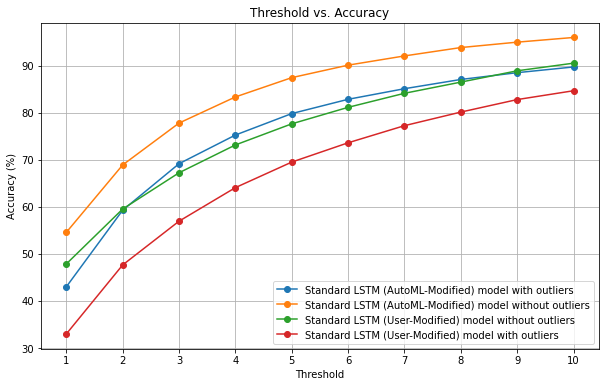

In [751]:

# Initialize lists to store data
thresholds = list(range(1, 11))
accuracies_h = []
accuracies_hl = []
accuracies_cl = []
accuracies_C = []

# Calculate accuracies for different threshold values
for j in thresholds:
    count_h = sum(1 for e in error_h if e > j or e < -j)
    accuracy_h = ((len(predictions_h) - count_h) / len(predictions_h)) * 100
    accuracies_h.append(accuracy_h)

    count_hl = sum(1 for e in error_s if e > j or e < -j)
    accuracy_hl = ((len(predictions_hl) - count_hl) / len(predictions_hl)) * 100
    accuracies_hl.append(accuracy_hl)
    
    count_cl = sum(1 for e in error_co if e > j or e < -j)
    accuracy_cl = ((len(predictions_cl) - count_cl) / len(predictions_cl)) * 100
    accuracies_cl.append(accuracy_cl)

    count_C = sum(1 for e in error_C if e > j or e < -j)
    accuracy_C = ((len(predictions_C) - count_C) / len(predictions_C)) * 100
    accuracies_C.append(accuracy_C)

# Create a single graph with three line plots
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies_h, label='Standard LSTM (AutoML-Modified) model with outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_hl, label='Standard LSTM (AutoML-Modified) model without outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_cl, label='Standard LSTM (User-Modified) model without outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_C, label='Standard LSTM (User-Modified) model with outliers', marker='o', linestyle='-')
plt.title("Threshold vs. Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(thresholds)
plt.legend()
plt.show()


In [752]:
from statistics import mean, stdev
print('Mean of error in test data:', mean(error_h))
print('Standard deviation of error in test data:', stdev(error_h))

Mean of error in test data: 1.7118445843184587
Standard deviation of error in test data: 84.42659371665738


In [753]:
from statistics import mean, stdev
print('Mean of test data:', mean(test_labels['Settlement Point Price']))
print('Standard deviation of test data:', stdev(test_labels['Settlement Point Price']))

Mean of test data: 27.92255865196976
Standard deviation of test data: 13.837448141380454


In [754]:
# for j in range(1,11):
#     i=0
#     count=0
#     for i in range(len(error_s)):
#         if ((error_s[i])>j) or ((error_s[i]<-j)):
#             count=count+1
#     a = len(predictions_h) - count
#     accuracy = (a/len(predictions_h))*100
#     print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

In [755]:
# history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

In [756]:
# example_result = model.predict(example_batch)
# example_result.shape

10
10
10
10


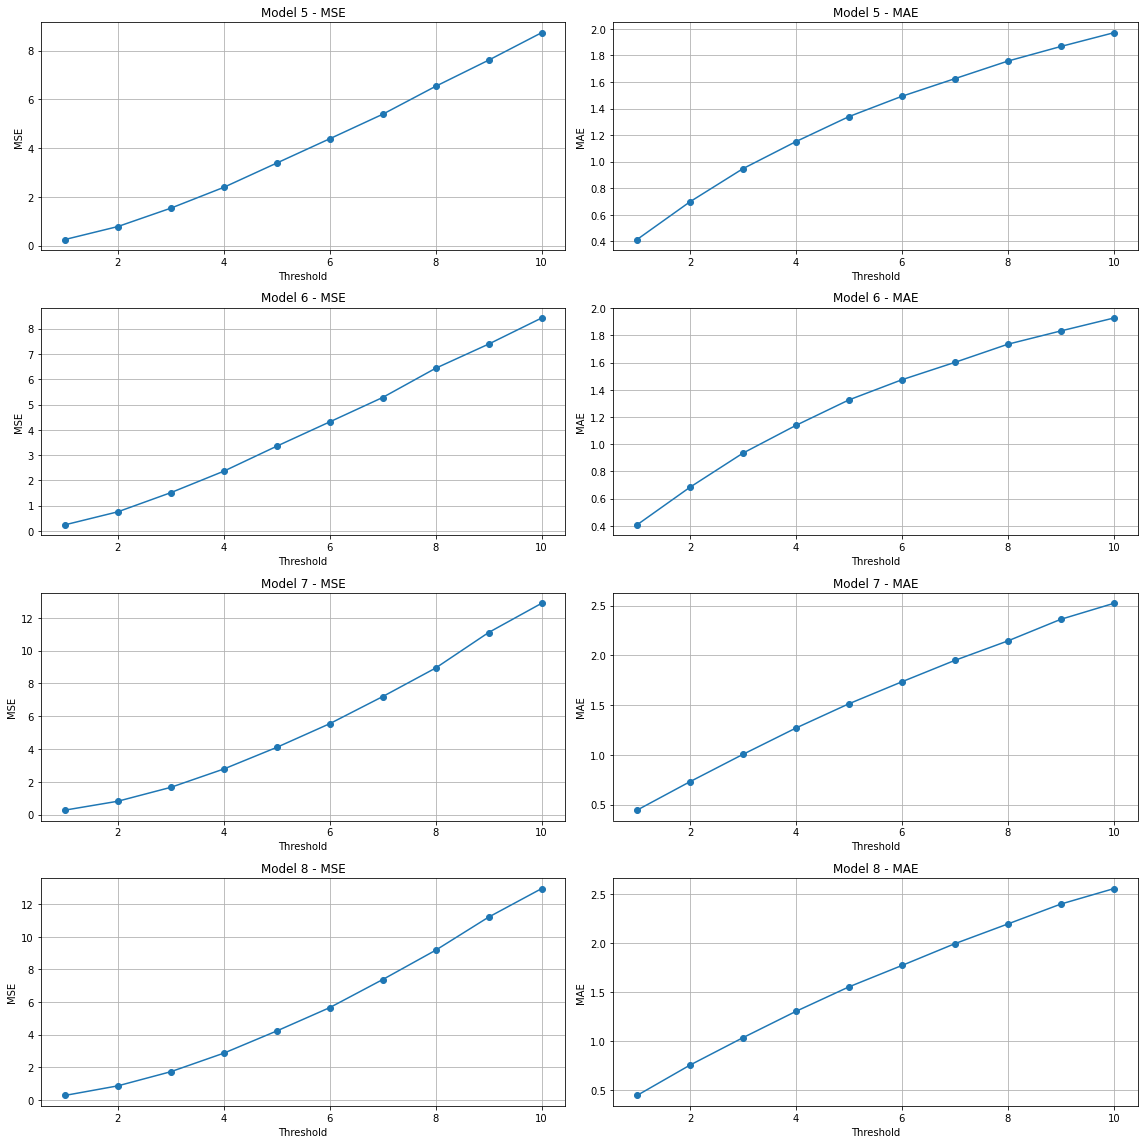

In [757]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE and MAE values for different models
mse_values = [mse_values5, mse_values6, mse_values7, mse_values8]  # Replace with your actual MSE values
mae_values = [mae_values5, mae_values6, mae_values7,mae_values8]  # Replace with your actual MAE values
model_labels = ["Model 5", "Model 6", "Model 7", "Model 8"]  # Replace with your actual model labels

# Create subplots for MSE and MAE
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Plot MSE for each model
for i in range(4):
    thresholds = range(1, len(mse_values[i]) + 1)  # Use the actual number of thresholds
    print(len(mse_values[0]))
    axes[i, 0].plot(thresholds, mse_values[i], marker='o', linestyle='-')
    axes[i, 0].set_title(f"{model_labels[i]} - MSE")
    axes[i, 0].set_xlabel("Threshold")
    axes[i, 0].set_ylabel("MSE")
    axes[i, 0].grid(True)

# Plot MAE for each model
for i in range(4):
    thresholds = range(1, len(mae_values[i]) + 1)  # Use the actual number of thresholds
    axes[i, 1].plot(thresholds, mae_values[i], marker='o', linestyle='-')
    axes[i, 1].set_title(f"{model_labels[i]} - MAE")
    axes[i, 1].set_xlabel("Threshold")
    axes[i, 1].set_ylabel("MAE")
    axes[i, 1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Display the MSE and MAE plots side by side
plt.show()


# ensemble 

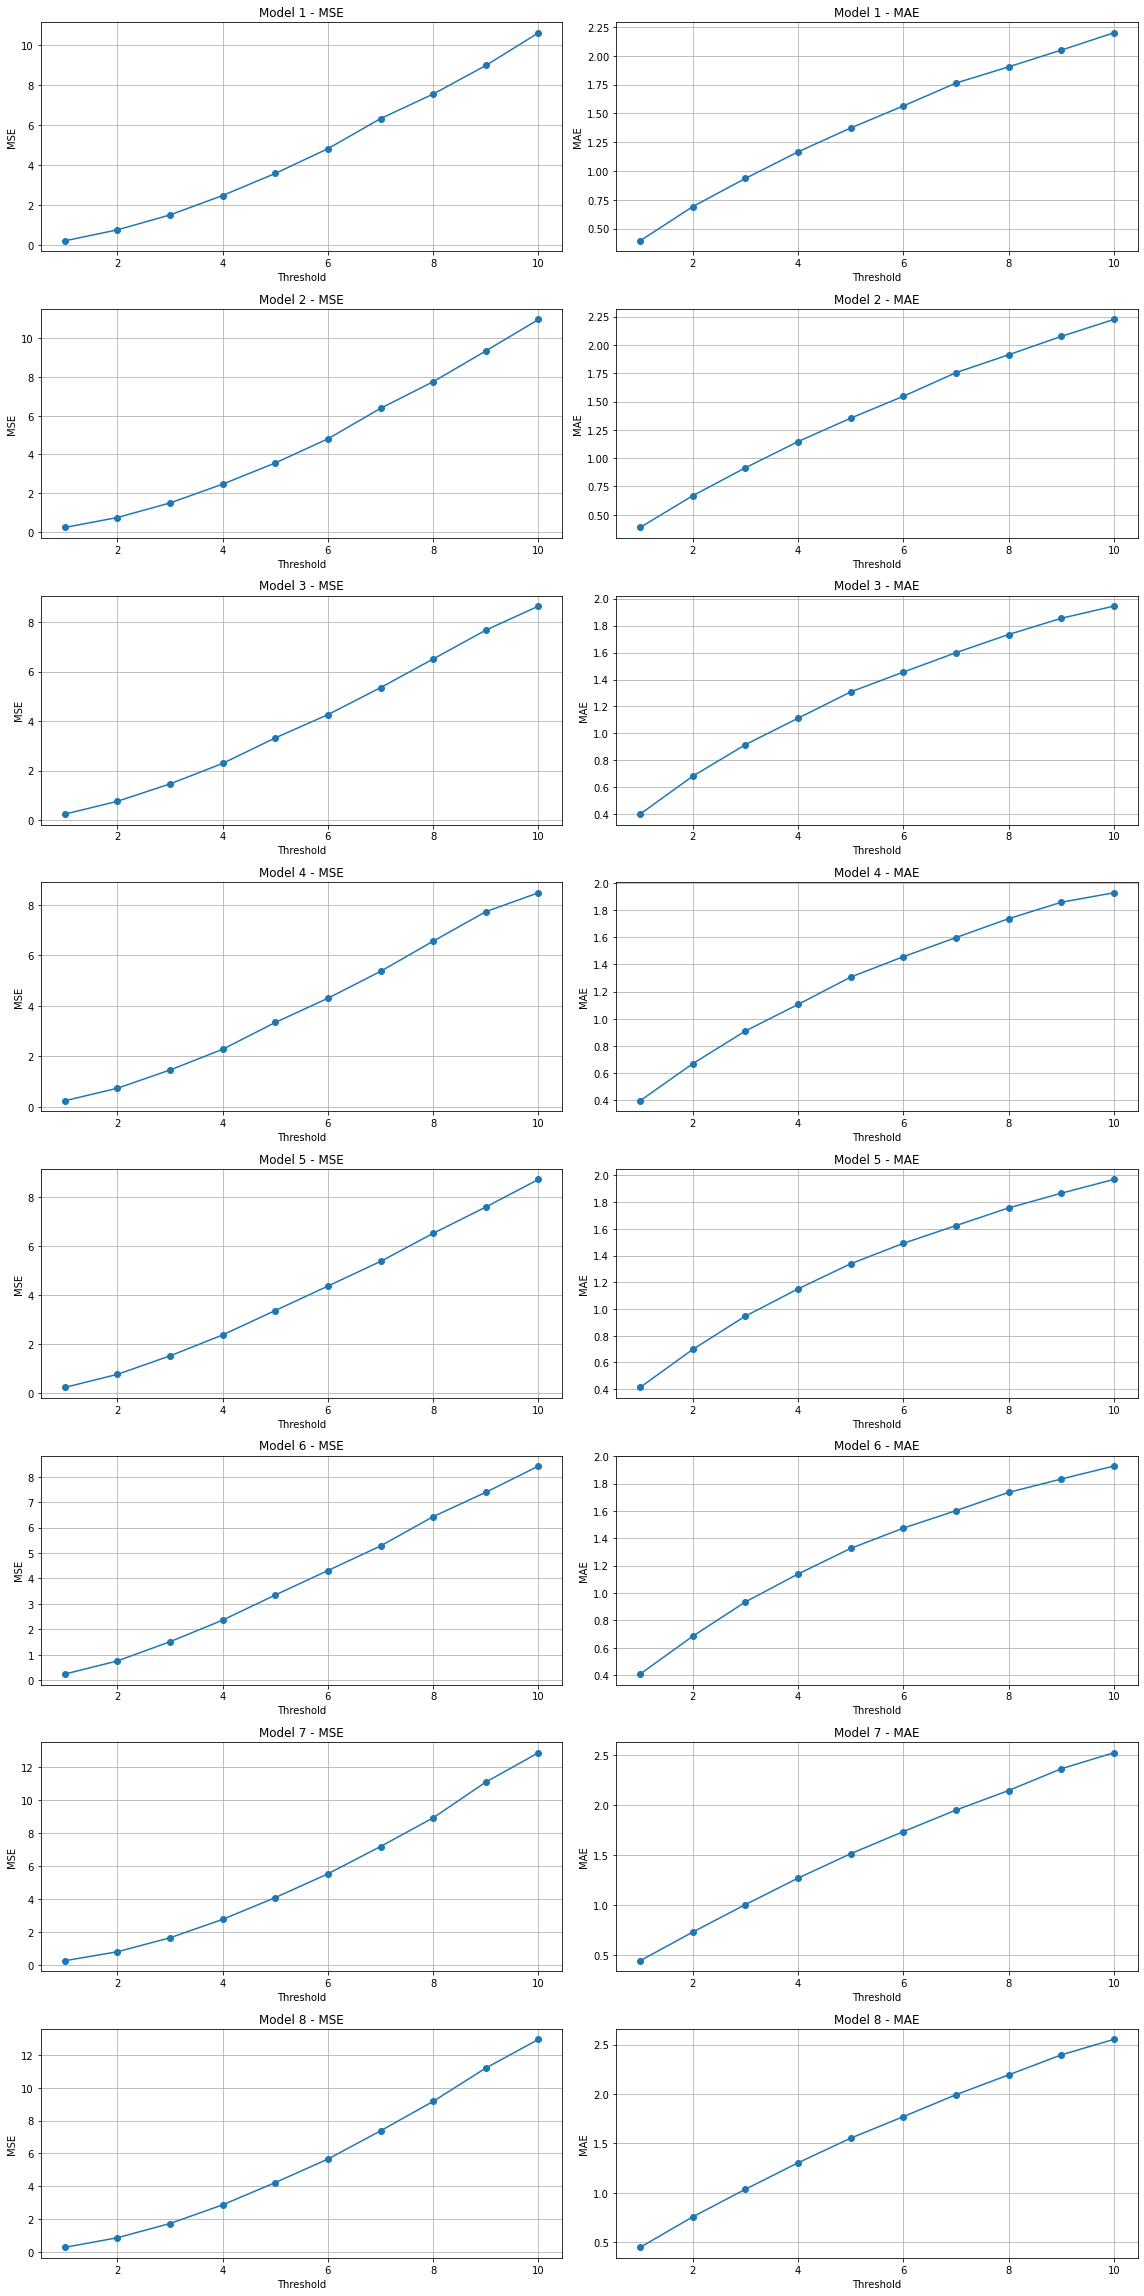

In [760]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE and MAE values for different models
mse_values_2 = [mse_values5, mse_values6, mse_values7, mse_values8]  # Replace with your actual MSE values
mae_values_2 = [mae_values5, mae_values6, mae_values7, mae_values8]  # Replace with your actual MAE values
model_labels_2 = ["Model 5", "Model 6", "Model 7", "Model 8"]  # Replace with your actual model labels

mse_values_1 = [mse_values1, mse_values2, mse_values3, mse_values4]  # Replace with your actual MSE values
mae_values_1 = [mae_values1, mae_values2, mae_values3, mae_values4]  # Replace with your actual MAE values
model_labels_1 = ["Model 1", "Model 2", "Model 3", "Model 4"]  # Replace with your actual model labels

# Create subplots for MSE and MAE
fig, axes = plt.subplots(8, 2, figsize=(16, 32))

# Plot MSE and MAE for the first set of models
for i in range(4):
    thresholds = range(1, len(mse_values_1[i]) + 1)  # Use the actual number of thresholds
    axes[i, 0].plot(thresholds, mse_values_1[i], marker='o', linestyle='-')
    axes[i, 0].set_title(f"{model_labels_1[i]} - MSE")
    axes[i, 0].set_xlabel("Threshold")
    axes[i, 0].set_ylabel("MSE")
    axes[i, 0].grid(True)

    axes[i, 1].plot(thresholds, mae_values_1[i], marker='o', linestyle='-')
    axes[i, 1].set_title(f"{model_labels_1[i]} - MAE")
    axes[i, 1].set_xlabel("Threshold")
    axes[i, 1].set_ylabel("MAE")
    axes[i, 1].grid(True)

# Plot MSE and MAE for the second set of models
for i in range(4):
    thresholds = range(1, len(mse_values_2[i]) + 1)  # Use the actual number of thresholds
    axes[i + 4, 0].plot(thresholds, mse_values_2[i], marker='o', linestyle='-')
    axes[i + 4, 0].set_title(f"{model_labels_2[i]} - MSE")
    axes[i + 4, 0].set_xlabel("Threshold")
    axes[i + 4, 0].set_ylabel("MSE")
    axes[i + 4, 0].grid(True)

    axes[i + 4, 1].plot(thresholds, mae_values_2[i], marker='o', linestyle='-')
    axes[i + 4, 1].set_title(f"{model_labels_2[i]} - MAE")
    axes[i + 4, 1].set_xlabel("Threshold")
    axes[i + 4, 1].set_ylabel("MAE")
    axes[i + 4, 1].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Display the MSE and MAE plots side by side
plt.show()


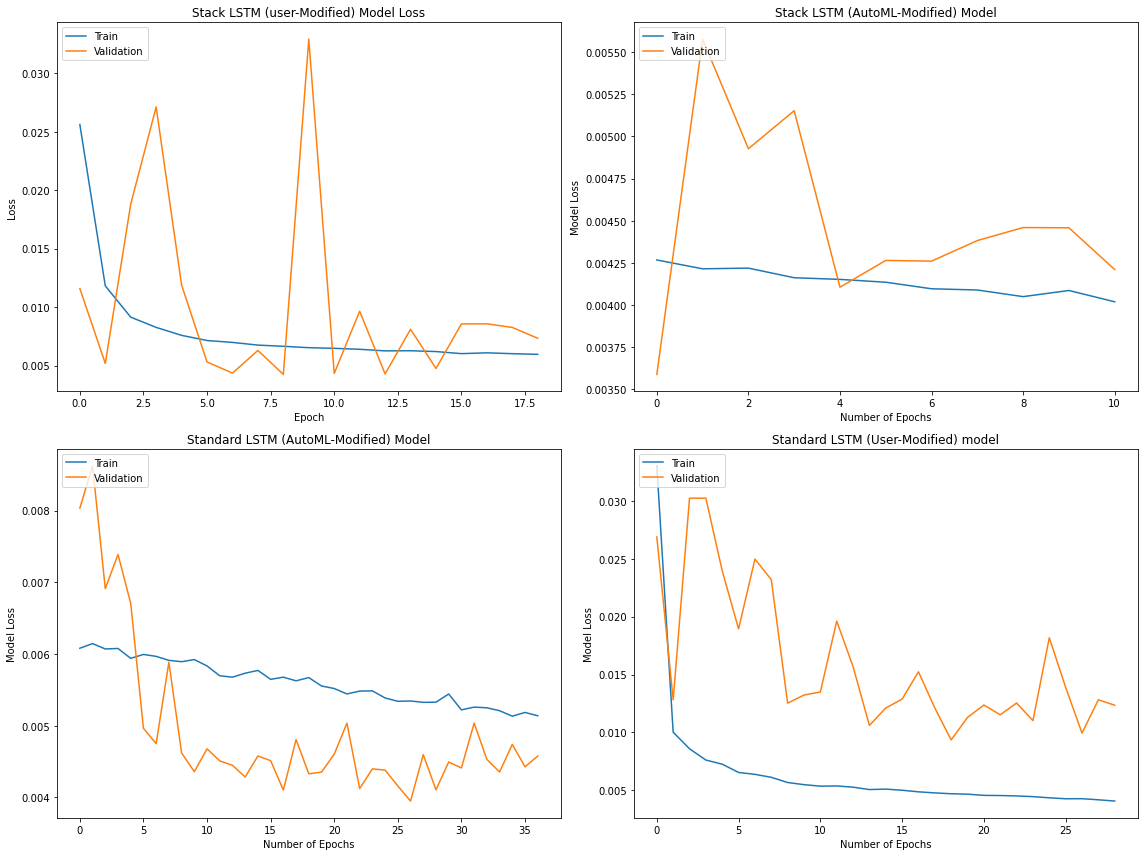

In [761]:
# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the model loss for the first dataset on the left subplot of the first row
axes[0, 0].plot(history.history['loss'])
axes[0, 0].plot(history.history['val_loss'])
axes[0, 0].set_title('Stack LSTM (user-Modified) Model Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(['Train', 'Validation'], loc='upper left')

# Plot the model loss for the second dataset on the right subplot of the first row
axes[0, 1].plot(bestmodel.history['loss'])
axes[0, 1].plot(bestmodel.history['val_loss'])
axes[0, 1].set_title('Stack LSTM (AutoML-Modified) Model')
axes[0, 1].set_ylabel('Model Loss')
axes[0, 1].set_xlabel('Number of Epochs')
axes[0, 1].legend(['Train', 'Validation'], loc='upper left')

# Plot the model loss for the third dataset on the left subplot of the second row
axes[1, 0].plot(history4.history['loss'])
axes[1, 0].plot(history4.history['val_loss'])
axes[1, 0].set_title('Standard LSTM (AutoML-Modified) Model')
axes[1, 0].set_ylabel('Model Loss')
axes[1, 0].set_xlabel('Number of Epochs')
axes[1, 0].legend(['Train', 'Validation'], loc='upper left')

# Plot the model loss for the fourth dataset on the right subplot of the second row
axes[1, 1].plot(history3.history['loss'])
axes[1, 1].plot(history3.history['val_loss'])
axes[1, 1].set_title('Standard LSTM (User-Modified) model')
axes[1, 1].set_ylabel('Model Loss')
axes[1, 1].set_xlabel('Number of Epochs')
axes[1, 1].legend(['Train', 'Validation'], loc='upper left')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [762]:
predictions['Settlement Point Price']

0       24.127127
1       21.673355
2       20.334158
3       18.997978
4       18.330162
          ...    
3459    22.592648
3460    23.100527
3461    20.866154
3462    21.059151
3463    17.914576
Name: Settlement Point Price, Length: 3464, dtype: float32

In [763]:
predictions_C['Settlement Point Price']

0       25.479206
1       21.621944
2       20.089504
3       19.040001
4       18.099012
          ...    
3459    20.921112
3460    21.929321
3461    20.149298
3462    19.790583
3463    17.421412
Name: Settlement Point Price, Length: 3464, dtype: float32

In [764]:
#without outliers best model
for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1-weight1,1)
    ensemble_predictions_d = weight1 * predictions_b_outliers + weight2 * predictions_hl
    print(weight1,weight2)
#    print(mean_squared_error(ensemble_predictions_d,test_labels['actual']))
    error3 = round(ensemble_predictions_d,2) - round(test_labels['Settlement Point Price'],2)
    count=0
    for i in range(len(error3)):
        if ((error3[i])>5) or ((error3[i]<-5)):
            count=count+1
    print(count)

    a = len(ensemble_predictions_d) - count
    a
    accuracy = (a/len(ensemble_predictions_d))*100
    print('accuracy:', accuracy)

0.0 1.0
518
accuracy: 84.72877358490565
0.1 0.9
507
accuracy: 85.05306603773585
0.2 0.8
497
accuracy: 85.34787735849056
0.3 0.7
493
accuracy: 85.46580188679245
0.4 0.6
484
accuracy: 85.73113207547169
0.5 0.5
478
accuracy: 85.90801886792453
0.6 0.4
481
accuracy: 85.81957547169812
0.7 0.3
482
accuracy: 85.79009433962264
0.8 0.2
489
accuracy: 85.58372641509435
0.9 0.1
505
accuracy: 85.1120283018868
1.0 0.0
516
accuracy: 84.7877358490566


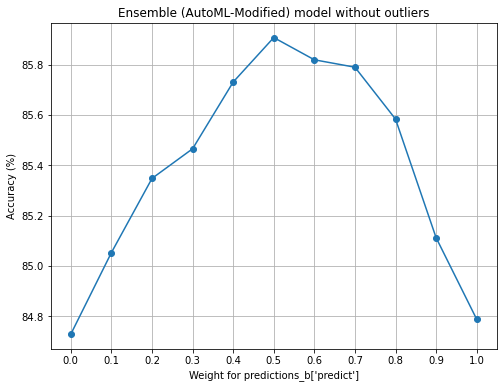

In [765]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = []  # To store accuracy values

for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)
    ensemble_predictions_d = weight1 * predictions_b_outliers + weight2 * predictions_hl

    error3 = round(ensemble_predictions_d, 2) - round(test_labels['Settlement Point Price'], 2)
    count = 0
    for i in range(len(error3)):
        if ((error3[i]) > 5) or ((error3[i] < -5)):
            count += 1

    a = len(ensemble_predictions_d) - count
    accuracy = (a / len(ensemble_predictions_d)) * 100
    accuracies.append(accuracy)

# Create a line plot
weights = np.arange(0, 1.1, 0.1)
plt.figure(figsize=(8, 6))
plt.plot(weights, accuracies, marker='o', linestyle='-')
plt.title("Ensemble (AutoML-Modified) model without outliers")
plt.xlabel("Weight for predictions_b['predict']")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(weights)
plt.show()

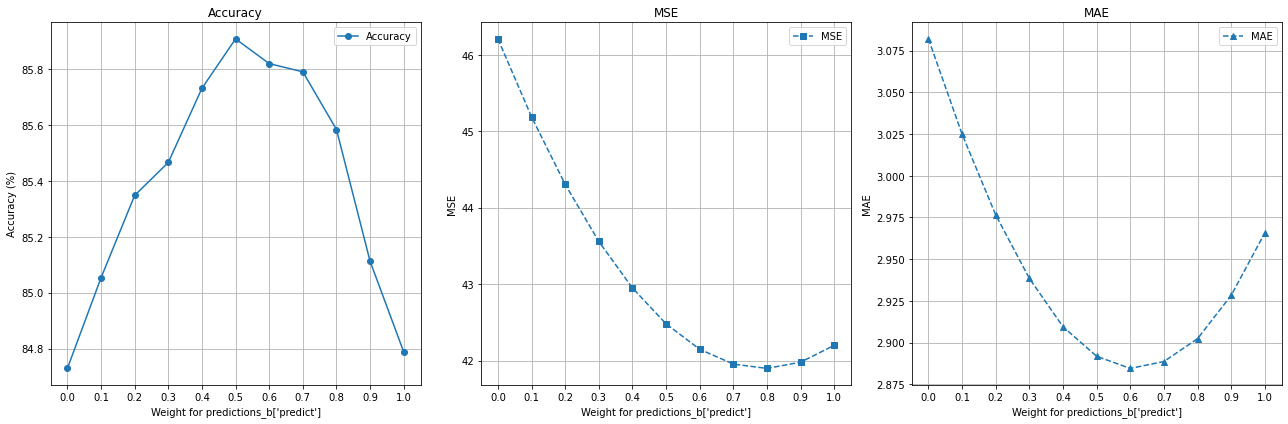

In [851]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store accuracy, MSE, and MAE values
accuracies = []
mse_values = []
mae_values = []

for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)
    ensemble_predictions_d = weight1 * predictions_b_outliers + weight2 * predictions_hl

    error__3 = round(ensemble_predictions_d, 2) - round(test_labels['Settlement Point Price'], 2)
    count = 0
    for i in range(len(error__3)):
        if ((error__3[i]) > 5) or ((error__3[i] < -5)):
            count += 1

    a = len(ensemble_predictions_d) - count
    accuracy = (a / len(ensemble_predictions_d)) * 100
    accuracies.append(accuracy)

    # Calculate MSE and MAE
    mse = np.mean(np.square(error__3))
    mae = np.mean(np.abs(error__3))
    mse_values.append(mse)
    mae_values.append(mae)

# Create subplots for accuracy, MSE, and MAE
weights = np.arange(0, 1.1, 0.1)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot accuracy
axs[0].plot(weights, accuracies, label='Accuracy', marker='o', linestyle='-')
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Weight for predictions_b['predict']")
axs[0].set_ylabel("Accuracy (%)")
axs[0].grid(True)
axs[0].set_xticks(weights)
axs[0].legend()

# Plot MSE
axs[1].plot(weights, mse_values, label='MSE', marker='s', linestyle='--')
axs[1].set_title("MSE")
axs[1].set_xlabel("Weight for predictions_b['predict']")
axs[1].set_ylabel("MSE")
axs[1].grid(True)
axs[1].set_xticks(weights)
axs[1].legend()

# Plot MAE
axs[2].plot(weights, mae_values, label='MAE', marker='^', linestyle='--')
axs[2].set_title("MAE")
axs[2].set_xlabel("Weight for predictions_b['predict']")
axs[2].set_ylabel("MAE")
axs[2].grid(True)
axs[2].set_xticks(weights)
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [766]:
#without outliers user model
for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1-weight1,1)
    ensemble_predictions_du = weight1 * predictions_outliers + weight2 * predictions_cl
    print(weight1,weight2)
#    print(mean_squared_error(ensemble_predictions_d,test_labels['actual']))
    error4 = round(ensemble_predictions_du,2) - round(test_labels['Settlement Point Price'],2)
    count=0
    for i in range(len(error4)):
        if ((error4[i])>5) or ((error4[i]<-5)):
            count=count+1
    print(count)

    a = len(ensemble_predictions_du) - count
    a
    accuracy = (a/len(ensemble_predictions_du))*100
    print('accuracy:', accuracy)

0.0 1.0
1049
accuracy: 69.71709006928405
0.1 0.9
1031
accuracy: 70.23672055427251
0.2 0.8
1015
accuracy: 70.6986143187067
0.3 0.7
1010
accuracy: 70.84295612009238
0.4 0.6
990
accuracy: 71.42032332563511
0.5 0.5
986
accuracy: 71.53579676674366
0.6 0.4
977
accuracy: 71.79561200923787
0.7 0.3
957
accuracy: 72.3729792147806
0.8 0.2
945
accuracy: 72.71939953810623
0.9 0.1
932
accuracy: 73.094688221709
1.0 0.0
926
accuracy: 73.26789838337181


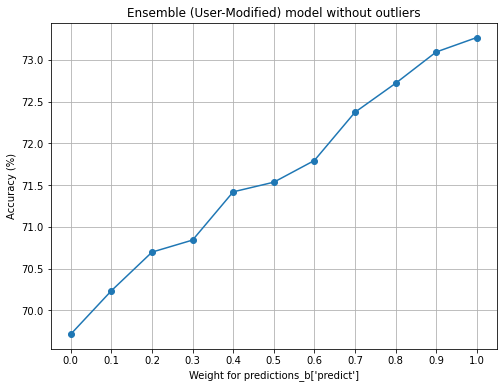

In [767]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = []  # To store accuracy values

for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)
    ensemble_predictions_du = weight1 * predictions_outliers + weight2 * predictions_cl

    error4 = round(ensemble_predictions_du, 2) - round(test_labels['Settlement Point Price'], 2)
    count = 0
    for i in range(len(error4)):
        if ((error4[i]) > 5) or ((error4[i] < -5)):
            count += 1

    a = len(ensemble_predictions_du) - count
    accuracy = (a / len(ensemble_predictions_du)) * 100
    accuracies.append(accuracy)

# Create a line plot
weights = np.arange(0, 1.1, 0.1)
plt.figure(figsize=(8, 6))
plt.plot(weights, accuracies, marker='o', linestyle='-')
plt.title("Ensemble (User-Modified) model without outliers")
plt.xlabel("Weight for predictions_b['predict']")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(weights)
plt.show()

In [768]:
#With outliers
for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1-weight1,1)
    ensemble_predictions = weight1 * predictions_b['Settlement Point Price'] + weight2 * predictions_h['Settlement Point Price']
    print(weight1,weight2)
    print(mean_squared_error(ensemble_predictions,test_labels['Settlement Point Price']))
    error3 = round(ensemble_predictions,2) - round(test_labels['Settlement Point Price'],2)
    count=0
    for i in range(len(error3)):
        if ((error3[i])>5) or ((error3[i]<-5)):
            count=count+1
    print(count)

    a = len(ensemble_predictions) - count
    a
    accuracy = (a/len(ensemble_predictions))*100
    print('accuracy:', accuracy)

0.0 1.0
7128.731342992662
700
accuracy: 79.79214780600462
0.1 0.9
6018.180684839104
686
accuracy: 80.19630484988453
0.2 0.8
5703.37890356906
672
accuracy: 80.60046189376443
0.3 0.7
6184.3268014720215
663
accuracy: 80.86027713625866
0.4 0.6
7461.023545368622
653
accuracy: 81.14896073903002
0.5 0.5
9533.469116117176
647
accuracy: 81.32217090069284
0.6 0.4
12401.665407425546
650
accuracy: 81.23556581986143
0.7 0.3
16065.609536505128
646
accuracy: 81.35103926096998
0.8 0.2
20525.302739424566
661
accuracy: 80.91801385681293
0.9 0.1
25780.745054651925
679
accuracy: 80.39838337182448
1.0 0.0
31831.936938512226
699
accuracy: 79.82101616628175


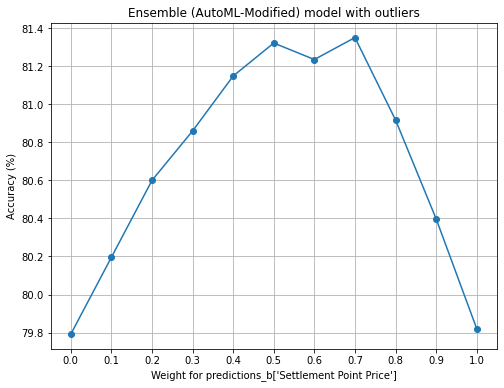

In [769]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

accuracies = []  # To store accuracy values

for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)
    ensemble_predictions = weight1 * predictions_b['Settlement Point Price'] + weight2 * predictions_h['Settlement Point Price']

    # Calculate mean squared error
    mse = mean_squared_error(ensemble_predictions, test_labels['Settlement Point Price'])

    error3 = round(ensemble_predictions, 2) - round(test_labels['Settlement Point Price'], 2)
    count = 0
    for i in range(len(error3)):
        if ((error3[i]) > 5) or ((error3[i] < -5)):
            count += 1

    a = len(ensemble_predictions) - count
    accuracy = (a / len(ensemble_predictions)) * 100
    accuracies.append(accuracy)

# Create a line plot
weights = np.arange(0, 1.1, 0.1)
plt.figure(figsize=(8, 6))
plt.plot(weights, accuracies, marker='o', linestyle='-')
plt.title("Ensemble (AutoML-Modified) model with outliers")
plt.xlabel("Weight for predictions_b['Settlement Point Price']")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(weights)
plt.show()


In [770]:
#With outliers user model
for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1-weight1,1)
    ensemble_predictions_u = weight1 * predictions['Settlement Point Price'] + weight2 * predictions_C['Settlement Point Price']
    print(weight1,weight2)
    print(mean_squared_error(ensemble_predictions_u,test_labels['Settlement Point Price']))
    error6 = round(ensemble_predictions_u,2) - round(test_labels['Settlement Point Price'],2)
    count=0
    for i in range(len(error6)):
        if ((error6[i])>5) or ((error6[i]<-5)):
            count=count+1
    print(count)

    a = len(ensemble_predictions_u) - count
    a
    accuracy = (a/len(ensemble_predictions_u))*100
    print('accuracy:', accuracy)

0.0 1.0
151.71696975932844
1057
accuracy: 69.48614318706697
0.1 0.9
150.64534011113483
1039
accuracy: 70.00577367205543
0.2 0.8
149.62870368084316
1023
accuracy: 70.4676674364896
0.3 0.7
148.66709574370952
1018
accuracy: 70.61200923787528
0.4 0.6
147.76048507746125
997
accuracy: 71.21824480369516
0.5 0.5
146.9089011836863
993
accuracy: 71.33371824480369
0.6 0.4
146.11231320971913
985
accuracy: 71.56466512702079
0.7 0.3
145.37075147066562
965
accuracy: 72.14203233256352
0.8 0.2
144.68418689808655
953
accuracy: 72.48845265588915
0.9 0.1
144.05265156203137
940
accuracy: 72.86374133949192
1.0 0.0
143.4761088900037
934
accuracy: 73.03695150115473


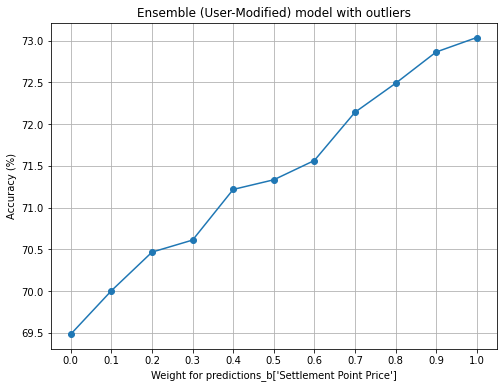

In [771]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

accuracies = []  # To store accuracy values

for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)
    ensemble_predictions_u = weight1 * predictions['Settlement Point Price'] + weight2 * predictions_C['Settlement Point Price']

    # Calculate mean squared error
    mse = mean_squared_error(ensemble_predictions_u, test_labels['Settlement Point Price'])

    error6 = round(ensemble_predictions_u, 2) - round(test_labels['Settlement Point Price'], 2)
    count = 0
    for i in range(len(error6)):
        if ((error6[i]) > 5) or ((error6[i] < -5)):
            count += 1

    a = len(ensemble_predictions_u) - count
    accuracy = (a / len(ensemble_predictions_u)) * 100
    accuracies.append(accuracy)

# Create a line plot
weights = np.arange(0, 1.1, 0.1)
plt.figure(figsize=(8, 6))
plt.plot(weights, accuracies, marker='o', linestyle='-')
plt.title("Ensemble (User-Modified) model with outliers")
plt.xlabel("Weight for predictions_b['Settlement Point Price']")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(weights)
plt.show()


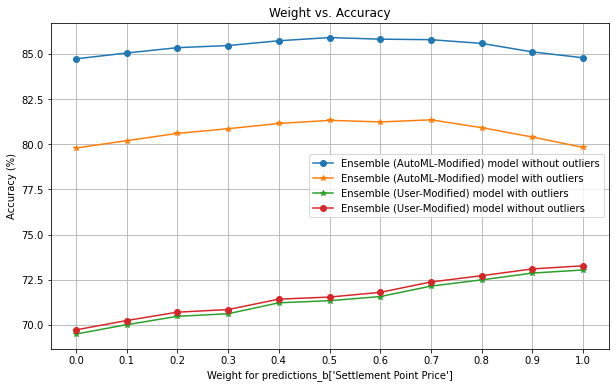

In [772]:
# Initialize lists to store data
weights = np.arange(0, 1.1, 0.1)
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_4 = []

# Calculate accuracies for different weight combinations and datasets
for i in range(11):
    weight1 = i / 10.0
    weight2 = np.round(1 - weight1, 1)

    # For the first dataset
    ensemble_predictions_d_1 = weight1 * predictions_b_outliers + weight2 * predictions_hl
    error1 = round(ensemble_predictions_d_1, 2) - round(test_labels['Settlement Point Price'], 2)
    count1 = 0
    for i in range(len(error1)):
        if ((error1[i]) > 5) or ((error1[i] < -5)):
            count1 += 1
    a1 = len(ensemble_predictions_d_1) - count1
    accuracy1 = (a1 / len(ensemble_predictions_d_1)) * 100
    accuracies_1.append(accuracy1)

    # For the second dataset
    ensemble_predictions_d_2 = weight1 * predictions_b['Settlement Point Price'] + weight2 * predictions_h['Settlement Point Price']
    error2 = round(ensemble_predictions_d_2, 2) - round(test_labels['Settlement Point Price'], 2)
    count2 = 0
    for i in range(len(error2)):
        if ((error2[i]) > 5) or ((error2[i] < -5)):
            count2 += 1
    a2 = len(ensemble_predictions_d_2) - count2
    accuracy2 = (a2 / len(ensemble_predictions_d_2)) * 100
    accuracies_2.append(accuracy2)
    
        # For the second dataset
    ensemble_predictions_c_1 = weight1 * predictions['Settlement Point Price'] + weight2 * predictions_C['Settlement Point Price']
    error3 = round(ensemble_predictions_c_1, 2) - round(test_labels['Settlement Point Price'], 2)
    count3 = 0
    for i in range(len(error3)):
        if ((error3[i]) > 5) or ((error3[i] < -5)):
            count3 += 1
    a3 = len(ensemble_predictions_c_1) - count3
    accuracy3 = (a3 / len(ensemble_predictions_c_1)) * 100
    accuracies_3.append(accuracy3)

    
        # For the second dataset
    ensemble_predictions_c_2 = weight1 * predictions_outliers + weight2 * predictions_cl
    error4 = round(ensemble_predictions_c_2, 2) - round(test_labels['Settlement Point Price'], 2)
    count4 = 0
    for i in range(len(error4)):
        if ((error4[i]) > 5) or ((error4[i] < -5)):
            count4 += 1
    a4 = len(ensemble_predictions_c_2) - count4
    accuracy4 = (a4 / len(ensemble_predictions_c_2)) * 100
    accuracies_4.append(accuracy4)

# Create a single graph with two line plots
plt.figure(figsize=(10, 6))
plt.plot(weights, accuracies_1, label='Ensemble (AutoML-Modified) model without outliers', marker='o', linestyle='-')
plt.plot(weights, accuracies_2, label='Ensemble (AutoML-Modified) model with outliers', marker='*', linestyle='-')
plt.plot(weights, accuracies_3, label='Ensemble (User-Modified) model with outliers', marker='*', linestyle='-')
plt.plot(weights, accuracies_4, label='Ensemble (User-Modified) model without outliers', marker='o', linestyle='-')
plt.title("Weight vs. Accuracy")
plt.xlabel("Weight for predictions_b['Settlement Point Price']")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(weights)
plt.legend()
plt.show()


In [805]:
#without outliers best
weight1 = 0.8  # Change the weights as per your preference
weight2 = 0.2
ensemble_predictions = weight1 * predictions_b_outliers + weight2 * predictions_hl

In [807]:
#with outliers best
weight1 = 0.5  # Change the weights as per your preference
weight2 = 0.5
ensemble_predictions_out = weight1 * predictions_b['Settlement Point Price'] + weight2 * predictions_h['Settlement Point Price']

In [808]:
#with outliers user
weight1 = 0.9  # Change the weights as per your preference
weight2 = 0.1
ensemble_predictions_op = weight1 * predictions['Settlement Point Price'] + weight2 * predictions_C['Settlement Point Price']

In [809]:
#without outliers user
weight1 = 0.9  # Change the weights as per your preference
weight2 = 0.1
ensemble_predictions_opd = weight1 * predictions_outliers + weight2 * predictions_cl

In [810]:
ensemble_predictions

0       29.554966
1       24.916374
2       21.053917
3       19.302670
4       18.135937
          ...    
3459    22.761219
3460    23.545635
3461    21.069061
3462    21.257959
3463    17.666267
Name: Settlement Point Price, Length: 3392, dtype: float32

In [811]:

ensemble_predictions_out

0       29.328381
1       24.437584
2       20.925312
3       19.215418
4       18.180885
          ...    
3459    22.943592
3460    24.551958
3461    21.136026
3462    21.672035
3463    17.738918
Name: Settlement Point Price, Length: 3464, dtype: float32

In [812]:
np.reshape(test_labels, (-1,1))
test_labels.shape

(3464, 1)

In [813]:
test_labels2 = pd.DataFrame({'Settlement Point Price':(Y_val[:,1])})
#test_labels.rename(columns = {(Y_test.shape[1]):'actual'}, inplace = True)
#test_labels['actual']
test_labels2['Settlement Point Price']

0       0.81502
1       0.67267
2       0.46096
3       0.33333
4       0.28428
         ...   
3459    0.62713
3460    0.60561
3461    0.57658
3462    0.30244
3463    0.12346
Name: Settlement Point Price, Length: 3464, dtype: float64

In [814]:
np.reshape(test_labels2, (-1,1))
test_labels2.shape

(3464, 1)

In [815]:
test_labels2['Settlement Point Price']=ct.named_transformers_['y'].inverse_transform(test_labels2)
test_labels2['Settlement Point Price']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: Settlement Point Price, Length: 3464, dtype: float64

In [816]:
max(test_labels2['Settlement Point Price'])

152.81651694254407

In [817]:
len(np.round(Y_val,2))

3464

In [818]:
# error = np.round(Y_val,2) - np.round(ensemble_predictions,2)
# plt.figure(figsize=(25,15))
# plt.hist(error, bins = 50)
# plt.xlabel("Prediction Error")
# _ = plt.ylabel("Count")

In [819]:
# test_labels2['actual'].shape[1]

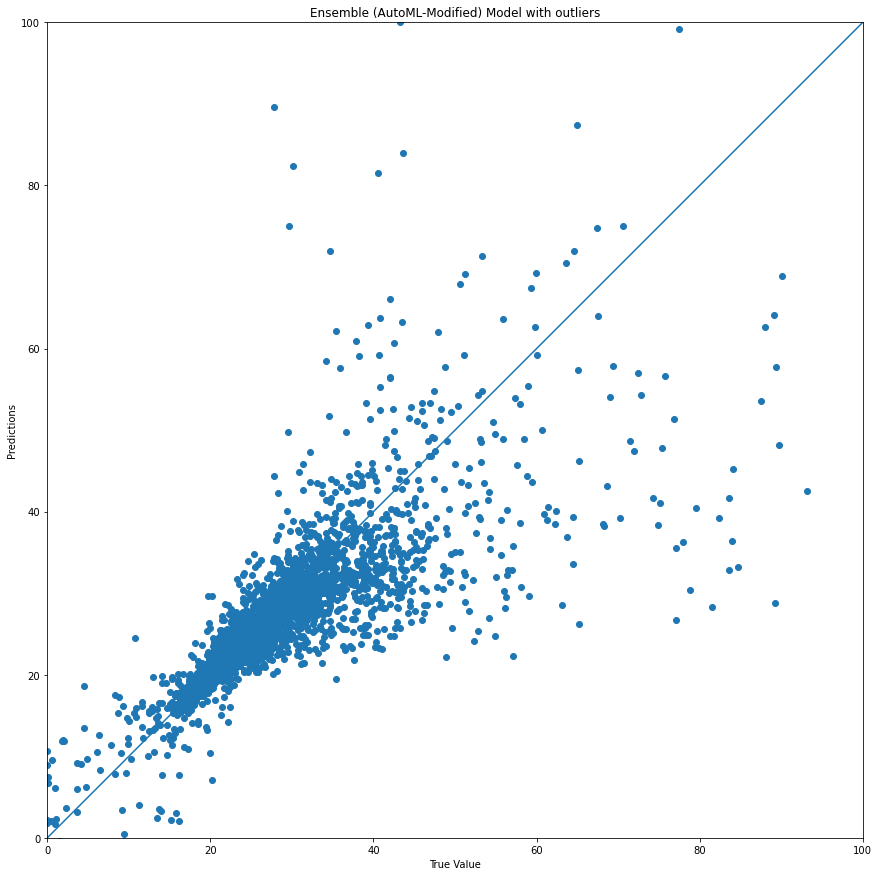

In [820]:
#with outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'], ensemble_predictions_out)
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Ensemble (AutoML-Modified) Model with outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

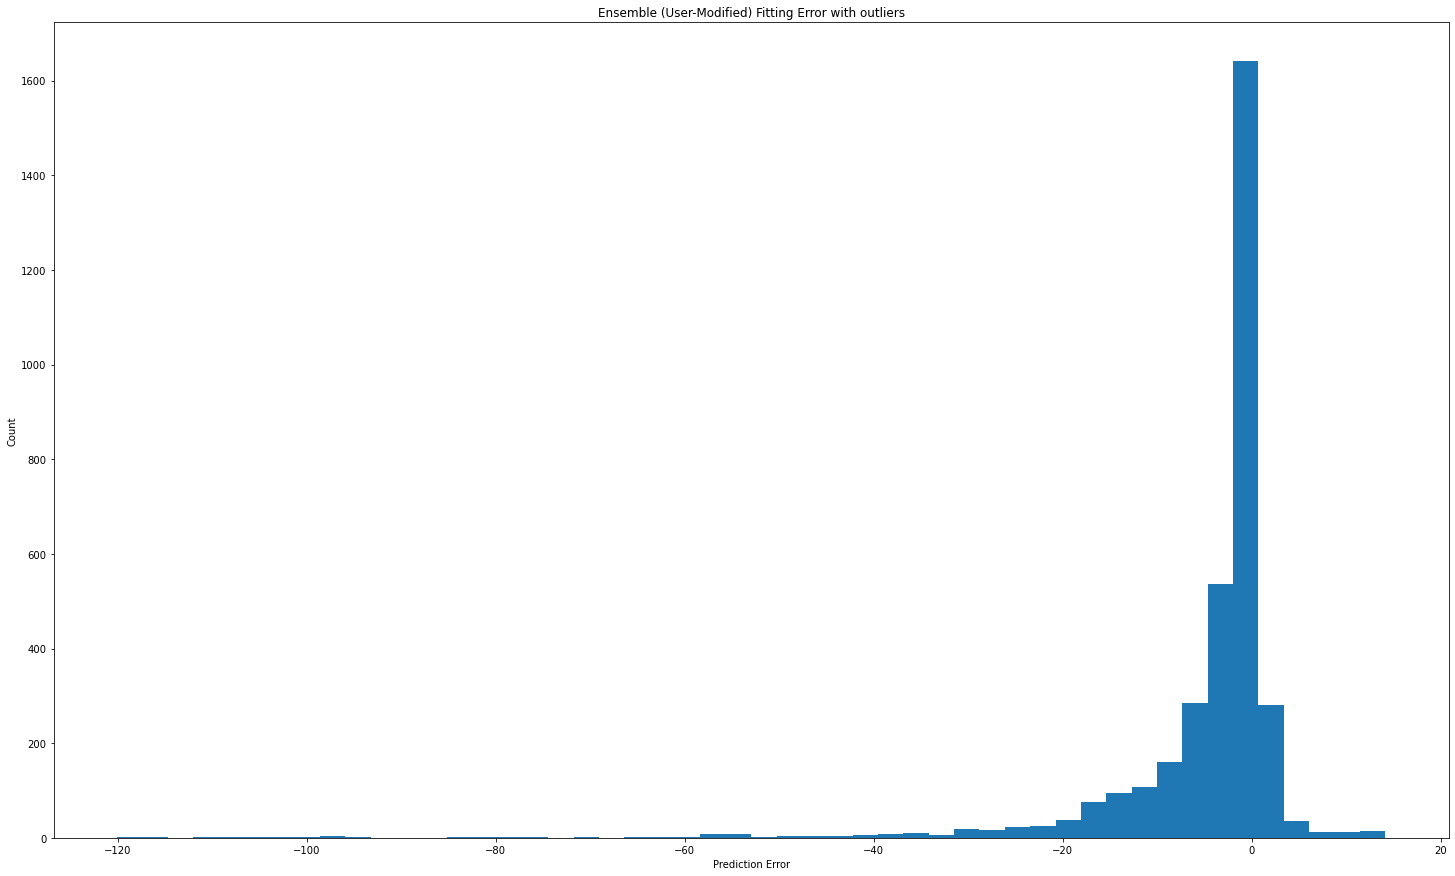

In [821]:
error_out = round(ensemble_predictions_out,2) - round(test_labels2['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Ensemble (User-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")

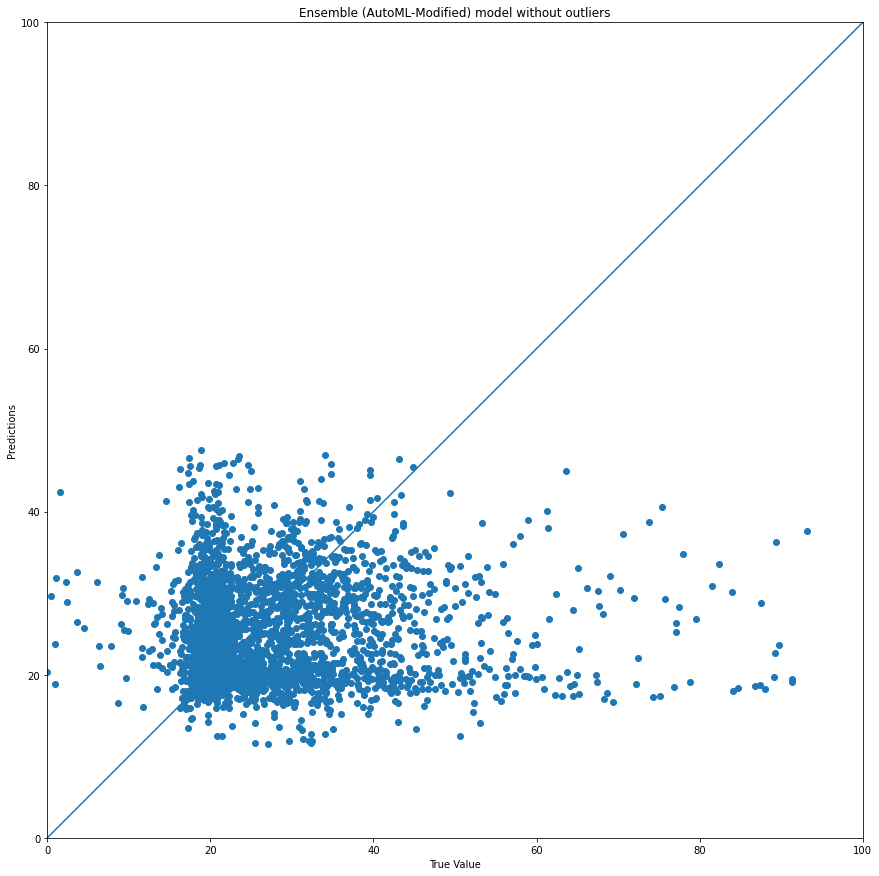

In [822]:
#without outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['Settlement Point Price'][:3000], ensemble_predictions[:3000])
plt.xlabel('True Value')
plt.ylabel('Predictions')
plt.title('Ensemble (AutoML-Modified) model without outliers')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

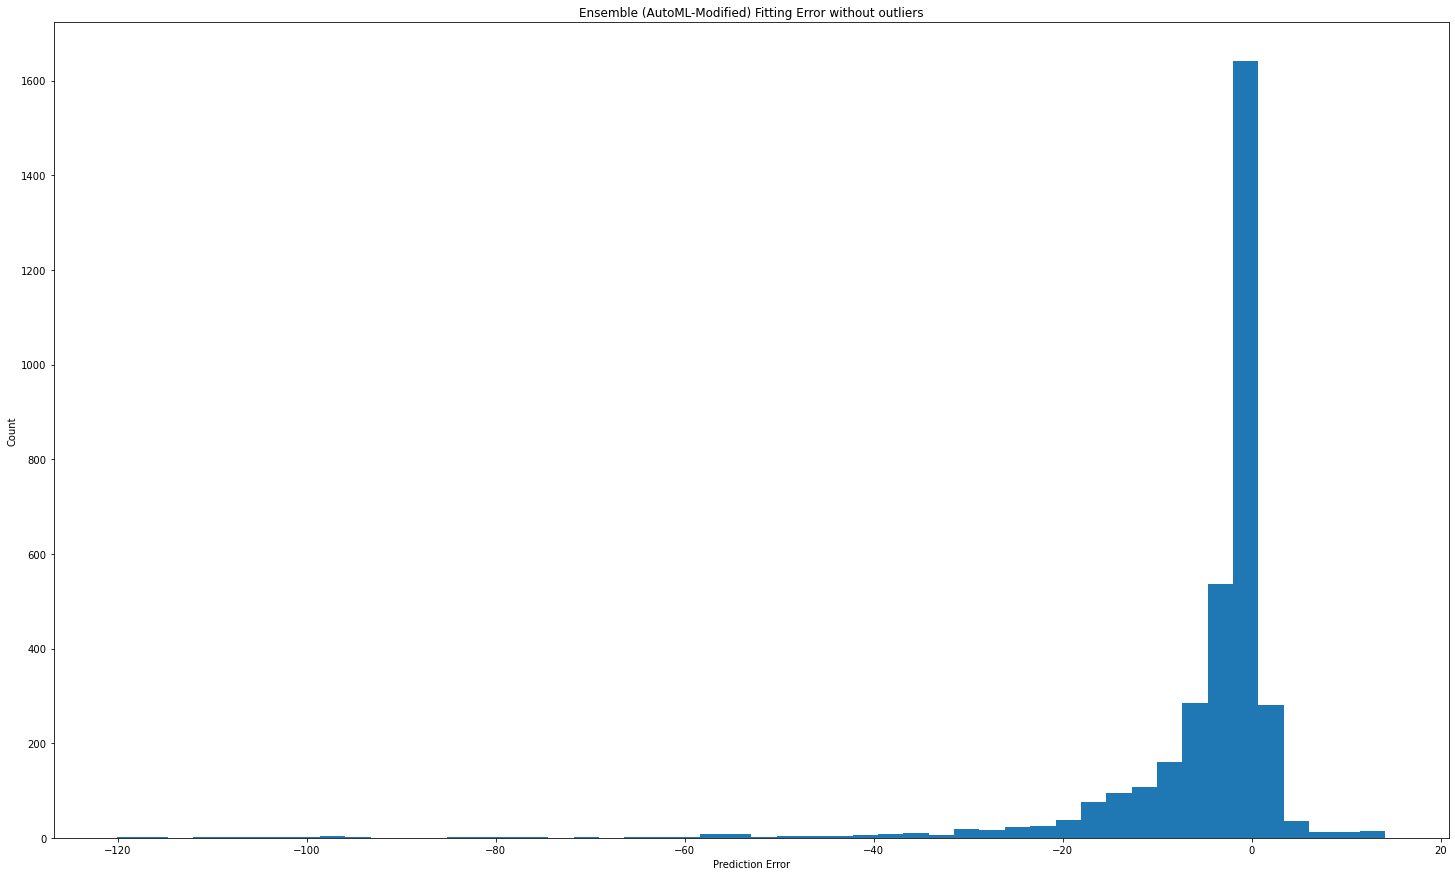

In [823]:
error2 = round(ensemble_predictions,2) - round(test_labels2['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Ensemble (AutoML-Modified) Fitting Error without outliers')
_ = plt.ylabel("Count")

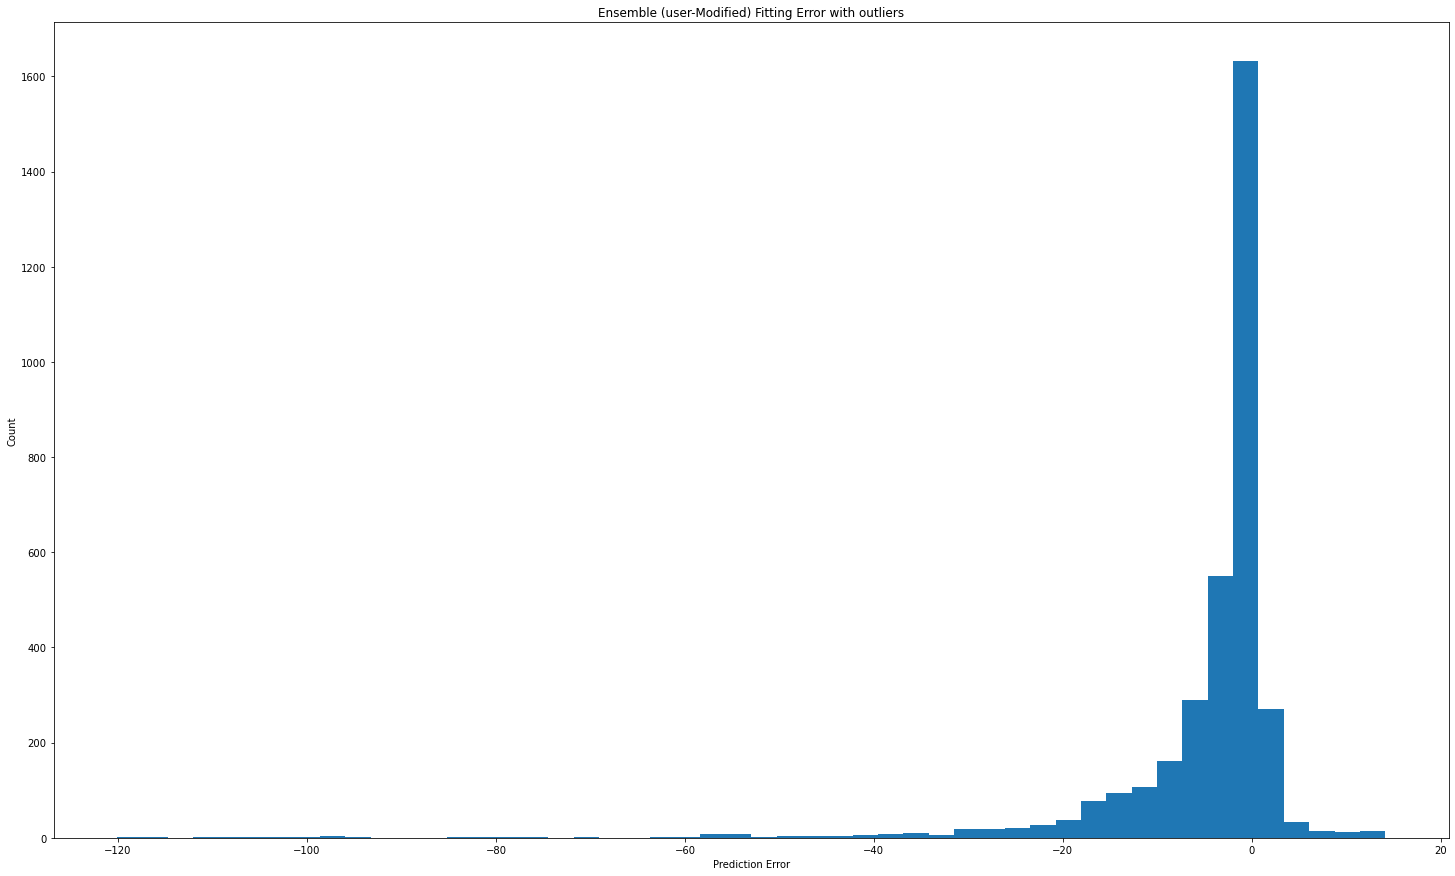

In [840]:
error_epo = round(ensemble_predictions_op,2) - round(test_labels2['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error_epo, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Ensemble (user-Modified) Fitting Error with outliers')
_ = plt.ylabel("Count")

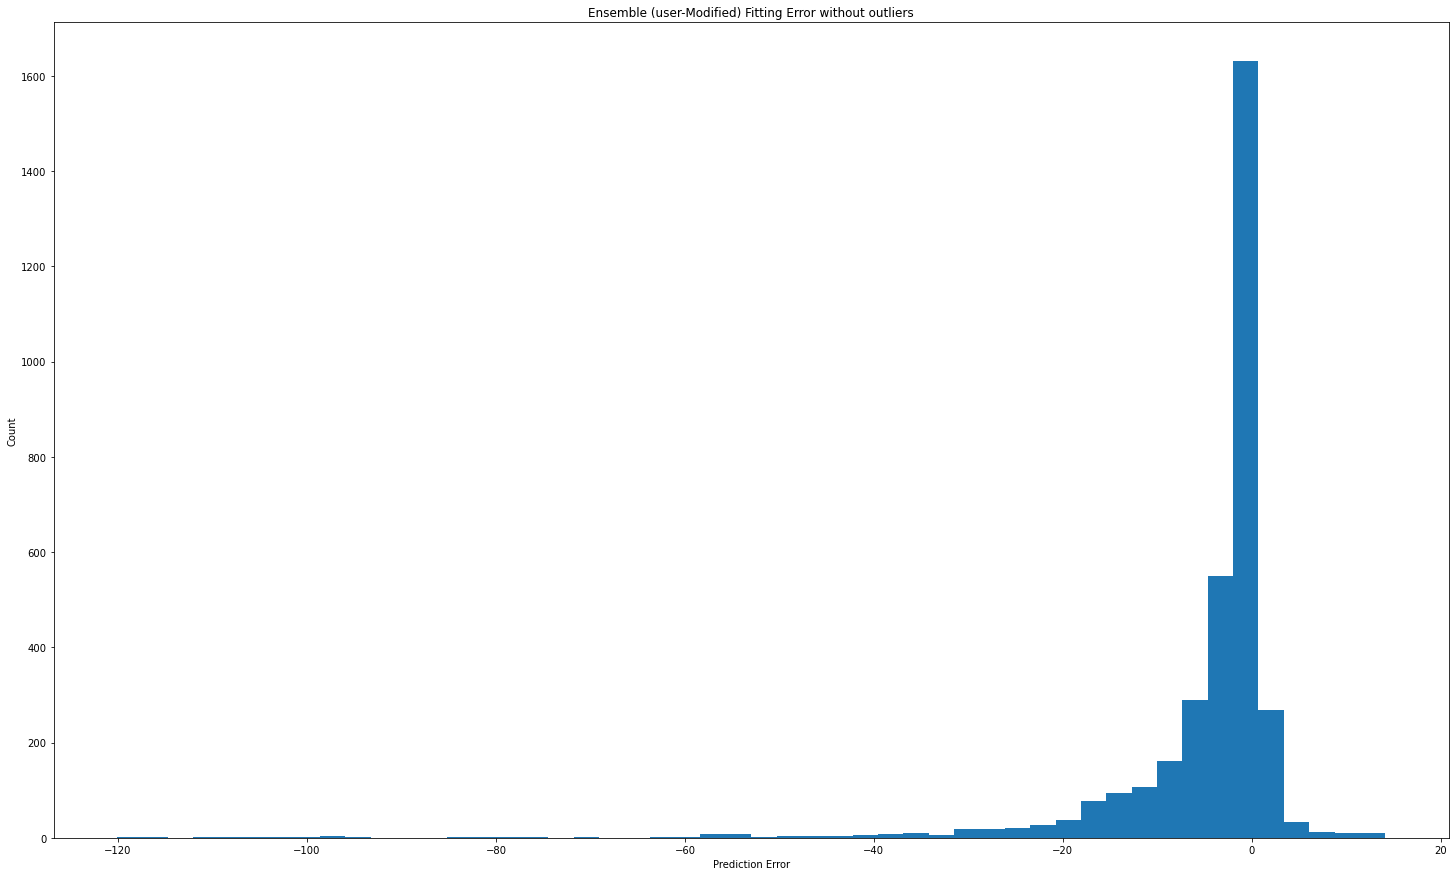

In [841]:
error_epod = round(ensemble_predictions_opd,2) - round(test_labels2['Settlement Point Price'],2)
plt.figure(figsize=(25,15))
plt.hist(error_epod, bins = 50)
plt.xlabel("Prediction Error")
plt.title('Ensemble (user-Modified) Fitting Error without outliers')
_ = plt.ylabel("Count")

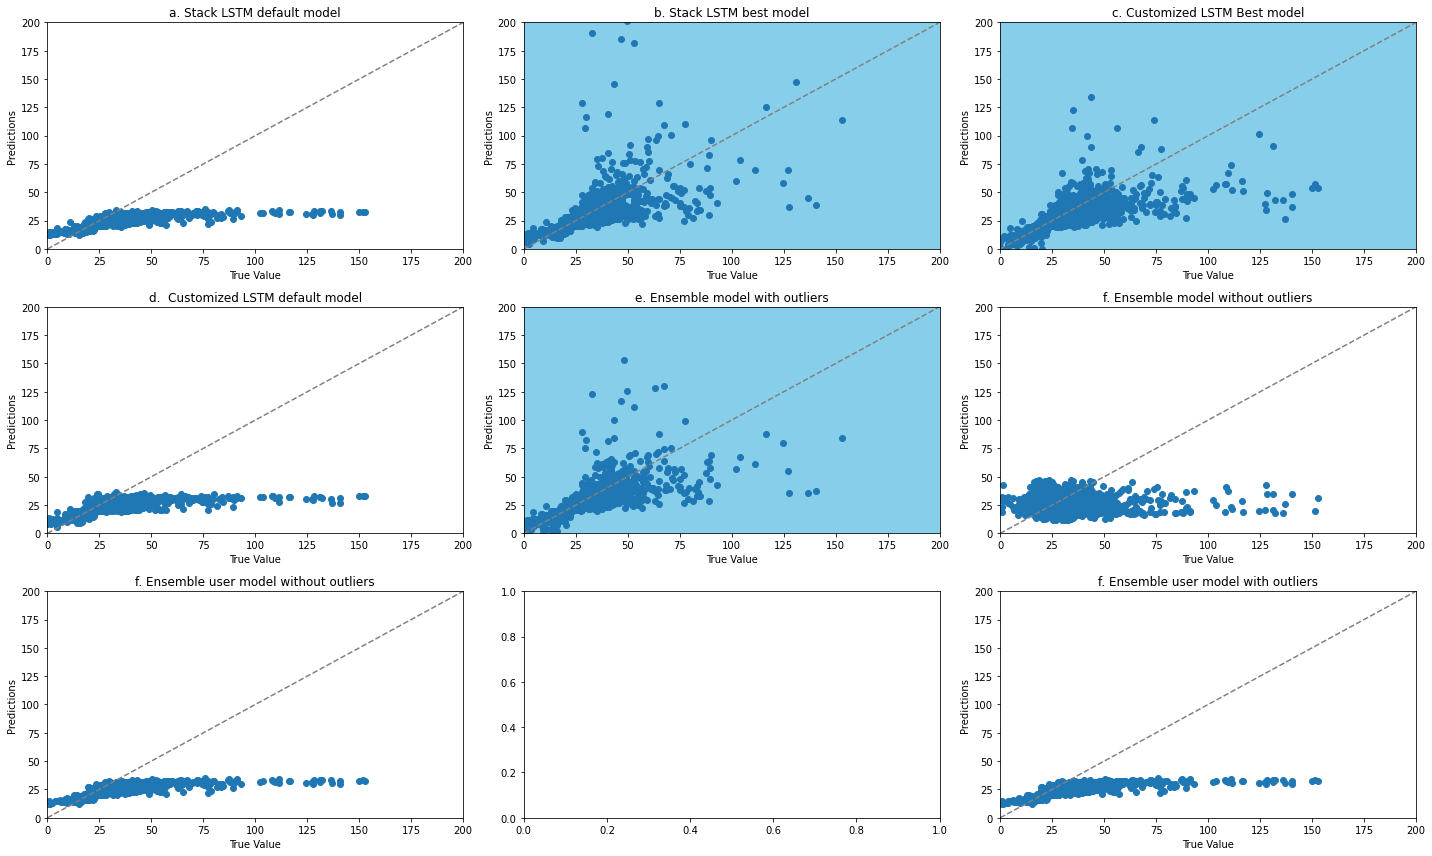

In [826]:
import matplotlib.pyplot as plt

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

# Plot the first scatter plot on the top-left subplot
axes[0, 0].scatter(test_labels['Settlement Point Price'], predictions)
axes[0, 0].set_title('a. Stack LSTM default model')
axes[0, 0].set_xlabel('True Value')
axes[0, 0].set_ylabel('Predictions')
axes[0, 0].set_xlim([0, 200])
axes[0, 0].set_ylim([0, 200])
axes[0, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the second scatter plot on the top-center subplot
axes[0, 1].scatter(test_labels['Settlement Point Price'], predictions_b)
axes[0, 1].set_title('b. Stack LSTM best model')
axes[0, 1].set_xlabel('True Value')
axes[0, 1].set_ylabel('Predictions')
axes[0, 1].set_xlim([0, 200])
axes[0, 1].set_ylim([0, 200])
axes[0, 1].plot([0, 200], [0, 200], linestyle='--', color='gray') 
axes[0, 1].set_facecolor('skyblue')# Add a diagonal line

# Plot the third scatter plot on the top-right subplot
axes[0, 2].scatter(test_labels['Settlement Point Price'], predictions_h)
axes[0, 2].set_title('c. Customized LSTM Best model')
axes[0, 2].set_xlabel('True Value')
axes[0, 2].set_ylabel('Predictions')
axes[0, 2].set_xlim([0, 200])
axes[0, 2].set_ylim([0, 200])
axes[0, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line
axes[0, 2].set_facecolor('skyblue')
# Plot the fourth scatter plot on the bottom-left subplot
axes[1, 0].scatter(test_labels['Settlement Point Price'], predictions_C)
axes[1, 0].set_title('d.  Customized LSTM default model')
axes[1, 0].set_xlabel('True Value')
axes[1, 0].set_ylabel('Predictions')
axes[1, 0].set_xlim([0, 200])
axes[1, 0].set_ylim([0, 200])
axes[1, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the fifth scatter plot on the bottom-center subplot
axes[1, 1].scatter(test_labels['Settlement Point Price'], ensemble_predictions_out)
axes[1, 1].set_title('e. Ensemble model with outliers')
axes[1, 1].set_xlabel('True Value')
axes[1, 1].set_ylabel('Predictions')
axes[1, 1].set_xlim([0, 200])
axes[1, 1].set_ylim([0, 200])
axes[1, 1].plot([0, 200], [0, 200], linestyle='--', color='gray')
axes[1, 1].set_facecolor('skyblue')
# Add a diagonal line

# Plot the sixth scatter plot on the bottom-right subplot
axes[1, 2].scatter(test_labels['Settlement Point Price'][:3000], ensemble_predictions[:3000])
axes[1, 2].set_title('f. Ensemble model without outliers')
axes[1, 2].set_xlabel('True Value')
axes[1, 2].set_ylabel('Predictions')
axes[1, 2].set_xlim([0, 200])
axes[1, 2].set_ylim([0, 200])
axes[1, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the sixth scatter plot on the bottom-right subplot
axes[2, 2].scatter(test_labels['Settlement Point Price'][:3000], ensemble_predictions_op[:3000])
axes[2, 2].set_title('f. Ensemble user model with outliers')
axes[2, 2].set_xlabel('True Value')
axes[2, 2].set_ylabel('Predictions')
axes[2, 2].set_xlim([0, 200])
axes[2, 2].set_ylim([0, 200])
axes[2, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the sixth scatter plot on the bottom-right subplot
axes[2, 0].scatter(test_labels['Settlement Point Price'][:3000], ensemble_predictions_opd[:3000])
axes[2, 0].set_title('f. Ensemble user model without outliers')
axes[2, 0].set_xlabel('True Value')
axes[2, 0].set_ylabel('Predictions')
axes[2, 0].set_xlim([0, 200])
axes[2, 0].set_ylim([0, 200])
axes[2, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


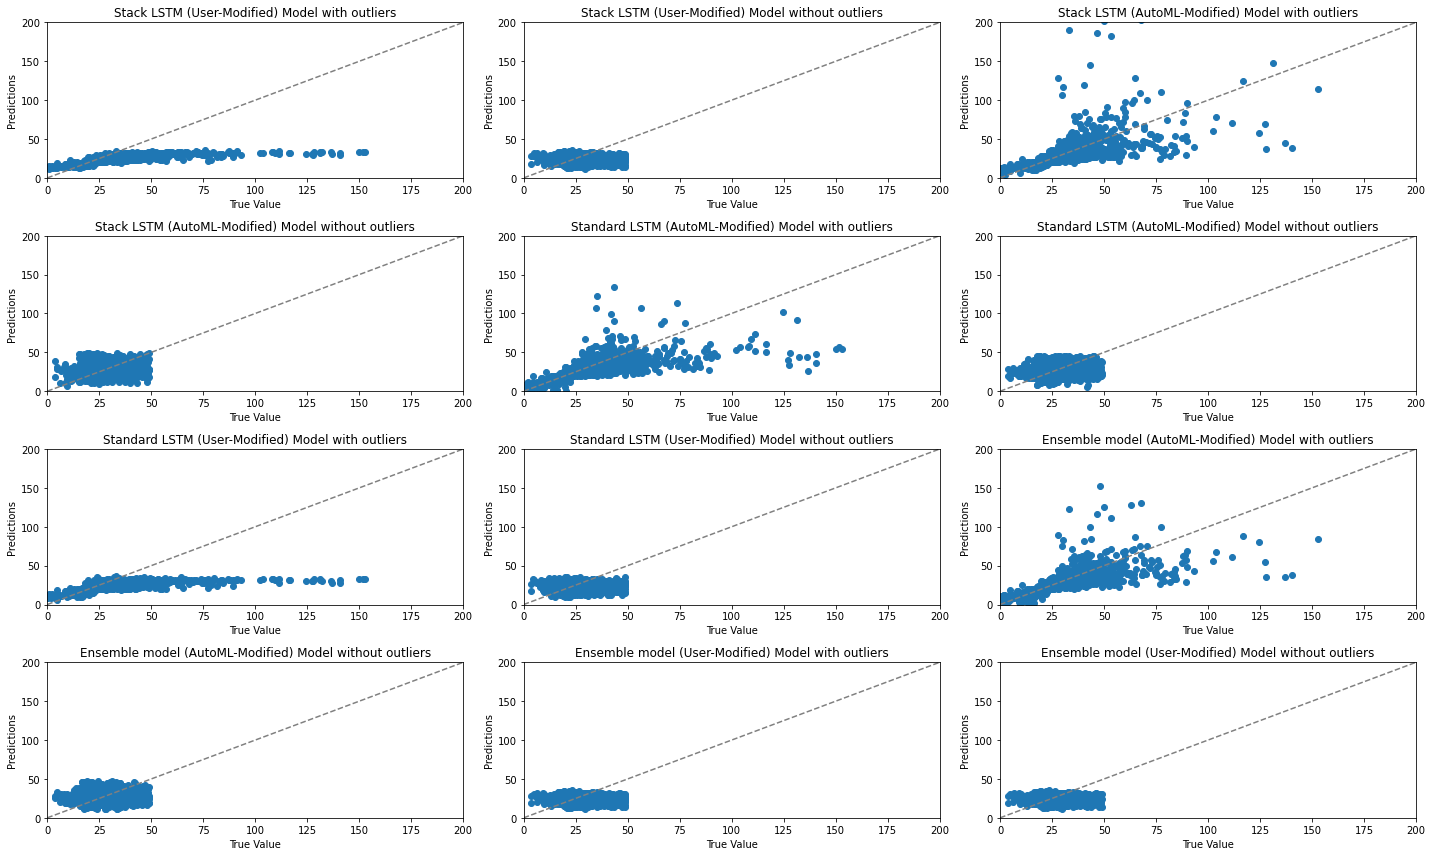

In [839]:
import matplotlib.pyplot as plt

# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 12))

# Plot the first scatter plot on the top-left subplot
axes[0, 0].scatter(test_labels['Settlement Point Price'], predictions)
axes[0, 0].set_title('Stack LSTM (User-Modified) Model with outliers')
axes[0, 0].set_xlabel('True Value')
axes[0, 0].set_ylabel('Predictions')
axes[0, 0].set_xlim([0, 200])
axes[0, 0].set_ylim([0, 200])
axes[0, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the first scatter plot on the top-left subplot
axes[0, 1].scatter(test_labels_a[:3000], predictions_outliers[:3000])
axes[0, 1].set_title('Stack LSTM (User-Modified) Model without outliers')
axes[0, 1].set_xlabel('True Value')
axes[0, 1].set_ylabel('Predictions')
axes[0, 1].set_xlim([0, 200])
axes[0, 1].set_ylim([0, 200])
axes[0, 1].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the second scatter plot on the top-center subplot
axes[0, 2].scatter(test_labels['Settlement Point Price'], predictions_b)
axes[0, 2].set_title('Stack LSTM (AutoML-Modified) Model with outliers')
axes[0, 2].set_xlabel('True Value')
axes[0, 2].set_ylabel('Predictions')
axes[0, 2].set_xlim([0, 200])
axes[0, 2].set_ylim([0, 200])
axes[0, 2].plot([0, 200], [0, 200], linestyle='--', color='gray') 

# Plot the second scatter plot on the top-center subplot
axes[1, 0].scatter(test_labels_a[:3000], predictions_b_outliers[:3000])
axes[1, 0].set_title('Stack LSTM (AutoML-Modified) Model without outliers')
axes[1, 0].set_xlabel('True Value')
axes[1, 0].set_ylabel('Predictions')
axes[1, 0].set_xlim([0, 200])
axes[1, 0].set_ylim([0, 200])
axes[1, 0].plot([0, 200], [0, 200], linestyle='--', color='gray') 

# Plot the third scatter plot on the top-right subplot
axes[1, 1].scatter(test_labels['Settlement Point Price'], predictions_h)
axes[1, 1].set_title('Standard LSTM (AutoML-Modified) Model with outliers')
axes[1, 1].set_xlabel('True Value')
axes[1, 1].set_ylabel('Predictions')
axes[1, 1].set_xlim([0, 200])
axes[1, 1].set_ylim([0, 200])
axes[1, 1].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the fourth scatter plot on the bottom-left subplot
axes[1, 2].scatter(test_labels_a[:3000], predictions_hl[:3000])
axes[1, 2].set_title('Standard LSTM (AutoML-Modified) Model without outliers')
axes[1, 2].set_xlabel('True Value')
axes[1, 2].set_ylabel('Predictions')
axes[1, 2].set_xlim([0, 200])
axes[1, 2].set_ylim([0, 200])
axes[1, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the fourth scatter plot on the bottom-left subplot
axes[2, 0].scatter(test_labels['Settlement Point Price'], predictions_C)
axes[2, 0].set_title('Standard LSTM (User-Modified) Model with outliers')
axes[2, 0].set_xlabel('True Value')
axes[2, 0].set_ylabel('Predictions')
axes[2, 0].set_xlim([0, 200])
axes[2, 0].set_ylim([0, 200])
axes[2, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the fourth scatter plot on the bottom-left subplot
axes[2, 1].scatter(test_labels_a[:3000], predictions_cl[:3000])
axes[2, 1].set_title('Standard LSTM (User-Modified) Model without outliers')
axes[2, 1].set_xlabel('True Value')
axes[2, 1].set_ylabel('Predictions')
axes[2, 1].set_xlim([0, 200])
axes[2, 1].set_ylim([0, 200])
axes[2, 1].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line



# Plot the fifth scatter plot on the bottom-center subplot
axes[2, 2].scatter(test_labels['Settlement Point Price'], ensemble_predictions_out)
axes[2, 2].set_title('Ensemble model (AutoML-Modified) Model with outliers')
axes[2, 2].set_xlabel('True Value')
axes[2, 2].set_ylabel('Predictions')
axes[2, 2].set_xlim([0, 200])
axes[2, 2].set_ylim([0, 200])
axes[2, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')


# Plot the sixth scatter plot on the bottom-right subplot
axes[3, 0].scatter(test_labels_a[:3000], ensemble_predictions[:3000])
axes[3, 0].set_title('Ensemble model (AutoML-Modified) Model without outliers')
axes[3, 0].set_xlabel('True Value')
axes[3, 0].set_ylabel('Predictions')
axes[3, 0].set_xlim([0, 200])
axes[3, 0].set_ylim([0, 200])
axes[3, 0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the sixth scatter plot on the bottom-right subplot
axes[3, 1].scatter(test_labels_a[:3000], ensemble_predictions_op[:3000])
axes[3, 1].set_title('Ensemble model (User-Modified) Model with outliers')
axes[3, 1].set_xlabel('True Value')
axes[3, 1].set_ylabel('Predictions')
axes[3, 1].set_xlim([0, 200])
axes[3, 1].set_ylim([0, 200])
axes[3, 1].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the sixth scatter plot on the bottom-right subplot
axes[3, 2].scatter(test_labels_a[:3000], ensemble_predictions_opd[:3000])
axes[3, 2].set_title('Ensemble model (User-Modified) Model without outliers')
axes[3, 2].set_xlabel('True Value')
axes[3, 2].set_ylabel('Predictions')
axes[3, 2].set_xlim([0, 200])
axes[3, 2].set_ylim([0, 200])
axes[3, 2].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line



# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


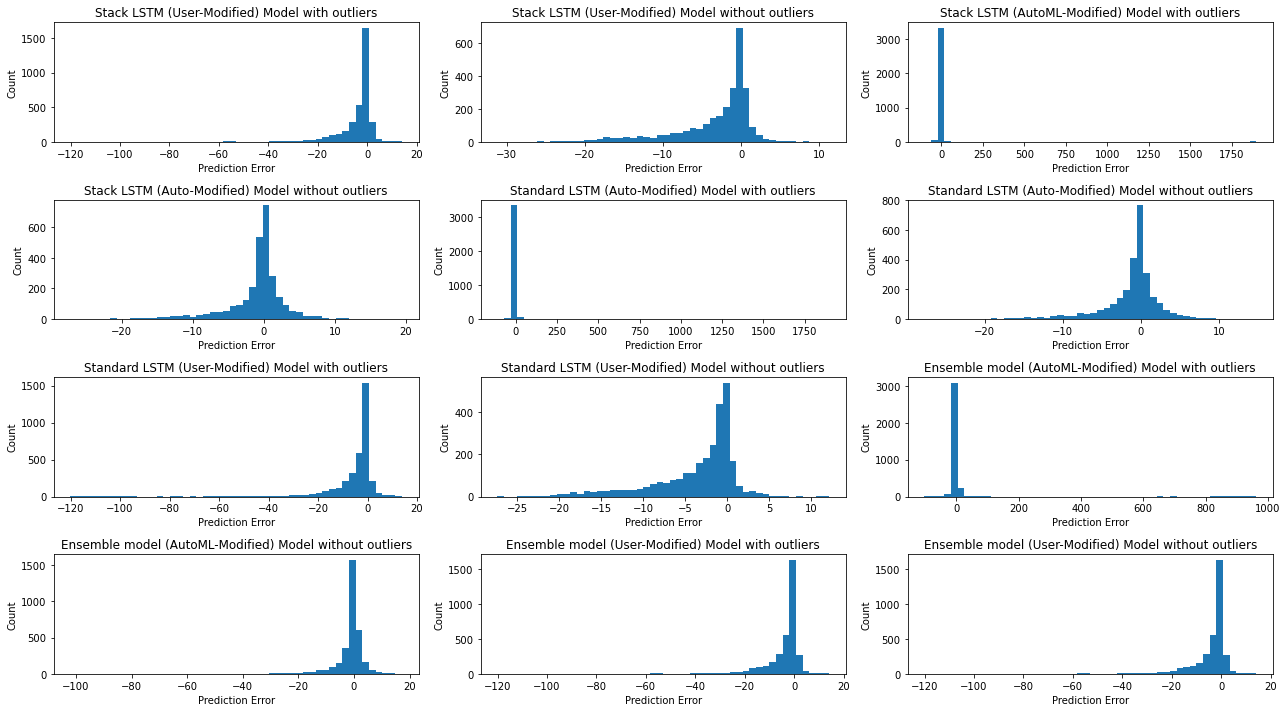

In [843]:
import matplotlib.pyplot as plt

# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

# Plot histograms for the first dataset on the first row of subplots
axes[0, 0].hist(error, bins=50)
axes[0, 0].set_title("Stack LSTM (User-Modified) Model with outliers")
axes[0, 0].set_xlabel("Prediction Error")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(error_u_out, bins=50)
axes[0, 1].set_title("Stack LSTM (User-Modified) Model without outliers")
axes[0, 1].set_xlabel("Prediction Error")
axes[0, 1].set_ylabel("Count")

axes[0, 2].hist(error_b, bins=50)
axes[0, 2].set_title("Stack LSTM (AutoML-Modified) Model with outliers")
axes[0, 2].set_xlabel("Prediction Error")
axes[0, 2].set_ylabel("Count")

axes[1, 0].hist(error_b_out, bins=50)
axes[1, 0].set_title("Stack LSTM (Auto-Modified) Model without outliers")
axes[1, 0].set_xlabel("Prediction Error")
axes[1, 0].set_ylabel("Count")

axes[1, 1].hist(error_h, bins=50)
axes[1, 1].set_title("Standard LSTM (Auto-Modified) Model with outliers")
axes[1, 1].set_xlabel("Prediction Error")
axes[1, 1].set_ylabel("Count")

axes[1, 2].hist(error_s, bins=50)
axes[1, 2].set_title("Standard LSTM (Auto-Modified) Model without outliers")
axes[1, 2].set_xlabel("Prediction Error")
axes[1, 2].set_ylabel("Count")

# Plot histograms for the second dataset on the second row of subplots
axes[2, 0].hist(error_C, bins=50)
axes[2, 0].set_title("Standard LSTM (User-Modified) Model with outliers")
axes[2, 0].set_xlabel("Prediction Error")
axes[2, 0].set_ylabel("Count")

axes[2, 1].hist(error_co, bins=50)
axes[2, 1].set_title("Standard LSTM (User-Modified) Model without outliers")
axes[2, 1].set_xlabel("Prediction Error")
axes[2, 1].set_ylabel("Count")

# Plot histograms for the third dataset on the third row of subplots
axes[2, 2].hist(error_out, bins=50)
axes[2, 2].set_title("Ensemble model (AutoML-Modified) Model with outliers")
axes[2, 2].set_xlabel("Prediction Error")
axes[2, 2].set_ylabel("Count")

axes[3, 0].hist(error2, bins=50)
axes[3, 0].set_title("Ensemble model (AutoML-Modified) Model without outliers")
axes[3, 0].set_xlabel("Prediction Error")
axes[3, 0].set_ylabel("Count")

axes[3, 1].hist(error_epod, bins=50)
axes[3, 1].set_title("Ensemble model (User-Modified) Model with outliers")
axes[3, 1].set_xlabel("Prediction Error")
axes[3, 1].set_ylabel("Count")

axes[3, 2].hist(error_epo, bins=50)
axes[3, 2].set_title("Ensemble model (User-Modified) Model without outliers")
axes[3, 2].set_xlabel("Prediction Error")
axes[3, 2].set_ylabel("Count")


# Adjust the layout to leave some space between subplots
plt.tight_layout()

# Display the subplots side by side
plt.show()


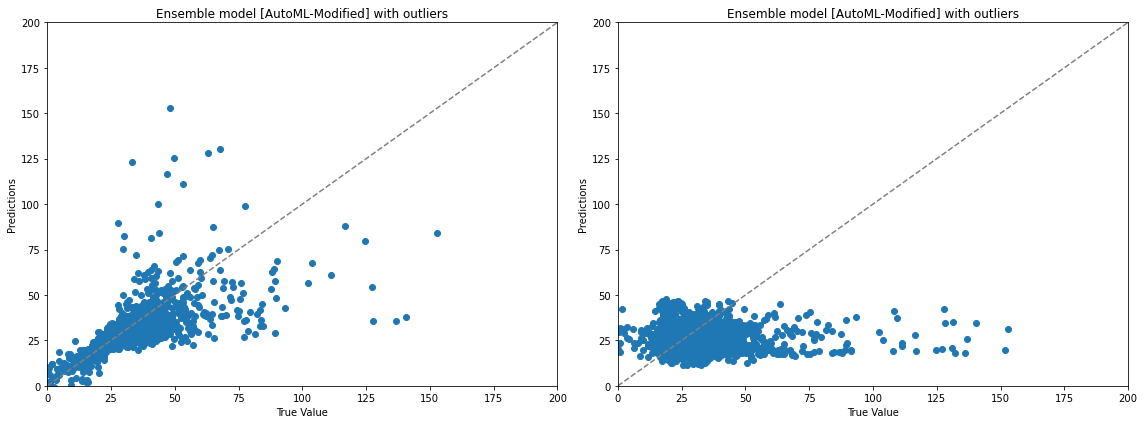

In [829]:
# ensemble model

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the scatter plot with outliers on the left subplot
axes[0].scatter(test_labels['Settlement Point Price'], ensemble_predictions_out)
axes[0].set_title('Ensemble model [AutoML-Modified] with outliers')
axes[0].set_xlabel('True Value')
axes[0].set_ylabel('Predictions')
axes[0].set_xlim([0, 200])
axes[0].set_ylim([0, 200])
axes[0].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Plot the scatter plot without outliers on the right subplot
axes[1].scatter(test_labels['Settlement Point Price'][:3000], ensemble_predictions[:3000])
axes[1].set_title('Ensemble model [AutoML-Modified] with outliers')
axes[1].set_xlabel('True Value')
axes[1].set_ylabel('Predictions')
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, 200])
axes[1].plot([0, 200], [0, 200], linestyle='--', color='gray')  # Add a diagonal line

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [830]:
i=0
count=0
for i in range(len(error2)):
    if ((error2[i])>5) or ((error2[i]<-5)):
        count=count+1
print(count)

489


In [831]:
a = len(ensemble_predictions) - count
a
accuracy = (a/len(ensemble_predictions))*100
print('accuracy:', accuracy)

accuracy: 85.58372641509435


In [832]:
# series of accuracy without outliers
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error2)):
        if ((error2[i])>j) or ((error2[i]<-j)):
            count=count+1
    a = len(ensemble_predictions) - count
    accuracy = (a/len(ensemble_predictions))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 49.73
accuracy: with threshold of 2  is 66.45
accuracy: with threshold of 3  is 75.09
accuracy: with threshold of 4  is 81.31
accuracy: with threshold of 5  is 85.58
accuracy: with threshold of 6  is 88.24
accuracy: with threshold of 7  is 90.36
accuracy: with threshold of 8  is 91.86
accuracy: with threshold of 9  is 93.04
accuracy: with threshold of 10  is 94.13


In [833]:
# series of accuracy with outliers
# error_io = round(ensemble_predictions_out,2) - round(test_labels['actual'],2)
count=0
for i in range(len(error_out)):
    if ((error_out[i])>5) or ((error_out[i]<-5)):
        count=count+1
print(count)

a = len(ensemble_predictions_out) - count
a
accuracy = (a/len(ensemble_predictions_out))*100
print('accuracy:', accuracy)

647
accuracy: 81.32217090069284


In [834]:
# series of accuracy with outliers
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_out)):
        if ((error_out[i])>j) or ((error_out[i]<-j)):
            count=count+1
    a = len(ensemble_predictions_out) - count
    accuracy = (a/len(ensemble_predictions_out))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 44.54
accuracy: with threshold of 2  is 61.75
accuracy: with threshold of 3  is 70.84
accuracy: with threshold of 4  is 76.73
accuracy: with threshold of 5  is 81.32
accuracy: with threshold of 6  is 84.30
accuracy: with threshold of 7  is 86.40
accuracy: with threshold of 8  is 88.22
accuracy: with threshold of 9  is 89.69
accuracy: with threshold of 10  is 90.79


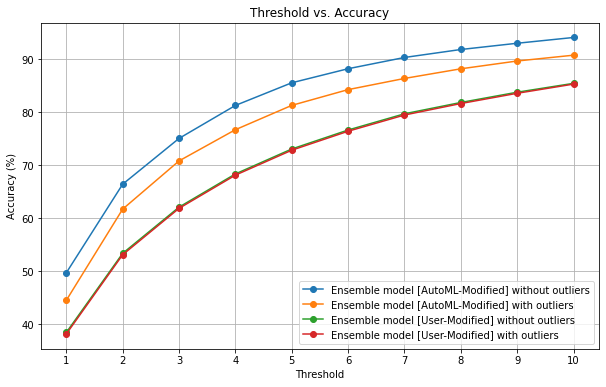

In [835]:
import matplotlib.pyplot as plt

# Initialize lists to store data
thresholds = list(range(1, 11))
accuracies_without_outliers_auto = []
accuracies_with_outliers_auto = []

accuracies_without_outliers_user = []
accuracies_with_outliers_user = []

# Calculate accuracies without outliers
for j in thresholds:
    count = sum(1 for e in error2 if e > j or e < -j)
    a = len(ensemble_predictions) - count
    accuracy = (a / len(ensemble_predictions)) * 100
    accuracies_without_outliers_auto.append(accuracy)

# Calculate accuracies with outliers
for j in thresholds:
    count = sum(1 for e in error_out if e > j or e < -j)
    a = len(ensemble_predictions_out) - count
    accuracy = (a / len(ensemble_predictions_out)) * 100
    accuracies_with_outliers_auto.append(accuracy)

for j in thresholds:
    count = sum(1 for e in error_epo if e > j or e < -j)
    a = len(ensemble_predictions_op) - count
    accuracy = (a / len(ensemble_predictions_op)) * 100
    accuracies_with_outliers_user.append(accuracy)

for j in thresholds:
    count = sum(1 for e in error_epod if e > j or e < -j)
    a = len(ensemble_predictions_opd) - count
    accuracy = (a / len(ensemble_predictions_opd)) * 100
    accuracies_without_outliers_user.append(accuracy)
    
    
# Create a single graph with two line plots
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies_without_outliers_auto, label='Ensemble model [AutoML-Modified] without outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_with_outliers_auto, label='Ensemble model [AutoML-Modified] with outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_without_outliers_user, label='Ensemble model [User-Modified] without outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_with_outliers_user, label='Ensemble model [User-Modified] with outliers', marker='o', linestyle='-')

plt.title("Threshold vs. Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(thresholds)
plt.legend()
plt.show()


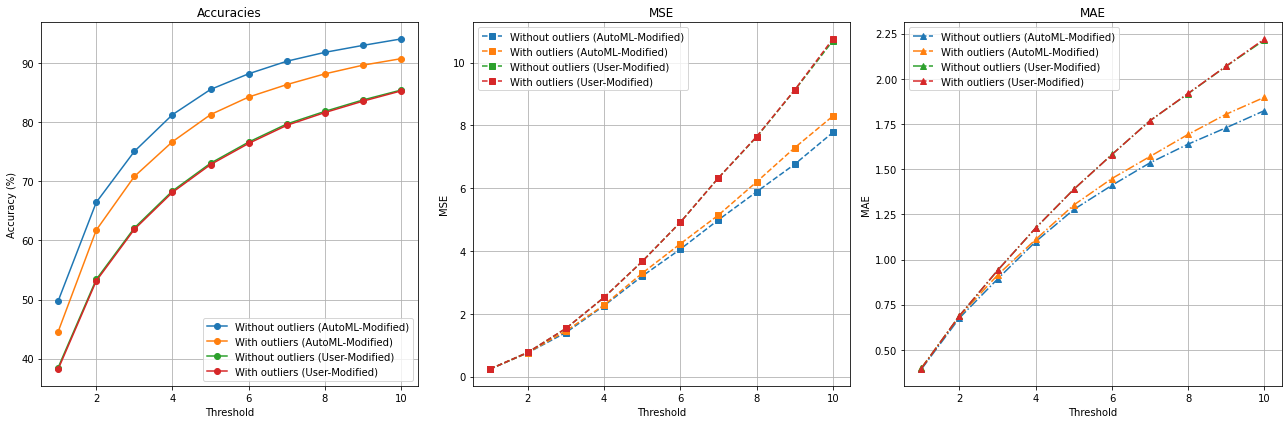

In [852]:
import matplotlib.pyplot as plt

# Initialize lists to store data
thresholds = list(range(1, 11))
accuracies_without_outliers_auto = []
accuracies_with_outliers_auto = []

accuracies_without_outliers_user = []
accuracies_with_outliers_user = []

mse_values_without_outliers_auto = []
mse_values_with_outliers_auto = []
mse_values_without_outliers_user = []
mse_values_with_outliers_user = []

mae_values_without_outliers_auto = []
mae_values_with_outliers_auto = []
mae_values_without_outliers_user = []
mae_values_with_outliers_user = []

# Calculate accuracies, MSE, and MAE without outliers
for j in thresholds:
    count = sum(1 for e in error2 if e > j or e < -j)
    a = len(ensemble_predictions) - count
    accuracy = (a / len(ensemble_predictions)) * 100
    accuracies_without_outliers_auto.append(accuracy)

    mse = np.mean(np.square([e for e in error2 if -j <= e <= j]))
    mae = np.mean(np.abs([e for e in error2 if -j <= e <= j]))

    mse_values_without_outliers_auto.append(mse)
    mae_values_without_outliers_auto.append(mae)

# Calculate accuracies, MSE, and MAE with outliers (AutoML-Modified)
for j in thresholds:
    count = sum(1 for e in error_out if e > j or e < -j)
    a = len(ensemble_predictions_out) - count
    accuracy = (a / len(ensemble_predictions_out)) * 100
    accuracies_with_outliers_auto.append(accuracy)

    mse = np.mean(np.square([e for e in error_out if -j <= e <= j]))
    mae = np.mean(np.abs([e for e in error_out if -j <= e <= j]))

    mse_values_with_outliers_auto.append(mse)
    mae_values_with_outliers_auto.append(mae)

# Calculate accuracies, MSE, and MAE with outliers (User-Modified)
for j in thresholds:
    count = sum(1 for e in error_epo if e > j or e < -j)
    a = len(ensemble_predictions_op) - count
    accuracy = (a / len(ensemble_predictions_op)) * 100
    accuracies_with_outliers_user.append(accuracy)

    mse = np.mean(np.square([e for e in error_epo if -j <= e <= j]))
    mae = np.mean(np.abs([e for e in error_epo if -j <= e <= j]))

    mse_values_with_outliers_user.append(mse)
    mae_values_with_outliers_user.append(mae)

# Calculate accuracies, MSE, and MAE without outliers (User-Modified)
for j in thresholds:
    count = sum(1 for e in error_epod if e > j or e < -j)
    a = len(ensemble_predictions_opd) - count
    accuracy = (a / len(ensemble_predictions_opd)) * 100
    accuracies_without_outliers_user.append(accuracy)

    mse = np.mean(np.square([e for e in error_epod if -j <= e <= j]))
    mae = np.mean(np.abs([e for e in error_epod if -j <= e <= j]))

    mse_values_without_outliers_user.append(mse)
    mae_values_without_outliers_user.append(mae)

# Create subplots for MSE, MAE, and Accuracies
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracies
axs[0].plot(thresholds, accuracies_without_outliers_auto, label='Without outliers (AutoML-Modified)', marker='o', linestyle='-')
axs[0].plot(thresholds, accuracies_with_outliers_auto, label='With outliers (AutoML-Modified)', marker='o', linestyle='-')
axs[0].plot(thresholds, accuracies_without_outliers_user, label='Without outliers (User-Modified)', marker='o', linestyle='-')
axs[0].plot(thresholds, accuracies_with_outliers_user, label='With outliers (User-Modified)', marker='o', linestyle='-')
axs[0].set_title("Accuracies")
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Accuracy (%)")
axs[0].grid(True)
axs[0].legend()

# Plot MSE
axs[1].plot(thresholds, mse_values_without_outliers_auto, label='Without outliers (AutoML-Modified)', marker='s', linestyle='--')
axs[1].plot(thresholds, mse_values_with_outliers_auto, label='With outliers (AutoML-Modified)', marker='s', linestyle='--')
axs[1].plot(thresholds, mse_values_without_outliers_user, label='Without outliers (User-Modified)', marker='s', linestyle='--')
axs[1].plot(thresholds, mse_values_with_outliers_user, label='With outliers (User-Modified)', marker='s', linestyle='--')
axs[1].set_title("MSE")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("MSE")
axs[1].grid(True)
axs[1].legend()

# Plot MAE
axs[2].plot(thresholds, mae_values_without_outliers_auto, label='Without outliers (AutoML-Modified)', marker='^', linestyle='-.')
axs[2].plot(thresholds, mae_values_with_outliers_auto, label='With outliers (AutoML-Modified)', marker='^', linestyle='-.')
axs[2].plot(thresholds, mae_values_without_outliers_user, label='Without outliers (User-Modified)', marker='^', linestyle='-.')
axs[2].plot(thresholds, mae_values_with_outliers_user, label='With outliers (User-Modified)', marker='^', linestyle='-.')
axs[2].set_title("MAE")
axs[2].set_xlabel("Threshold")
axs[2].set_ylabel("MAE")
axs[2].grid(True)
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


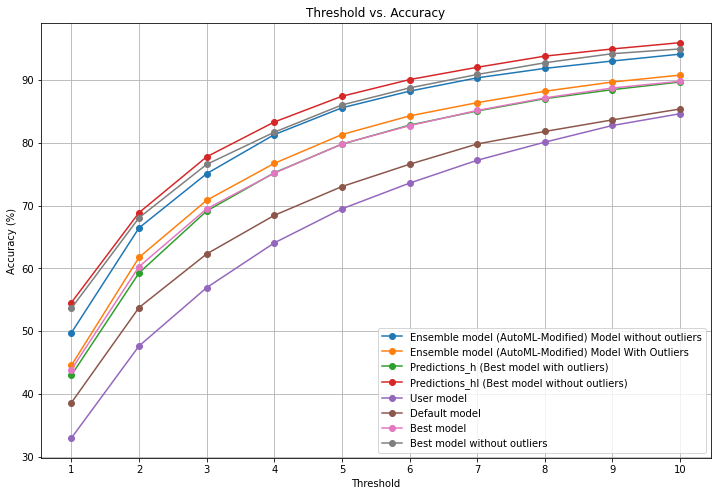

In [836]:
import matplotlib.pyplot as plt

# Create a figure with one subplot for both line plots
import matplotlib.pyplot as plt

# Create a figure and axis for the combined plot
plt.figure(figsize=(12, 8))

# Plot the first set of lines (two lines) on the combined plot
plt.plot(thresholds, accuracies_without_outliers_auto, label='Ensemble model (AutoML-Modified) Model without outliers', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_with_outliers_auto, label='Ensemble model (AutoML-Modified) Model With Outliers', marker='o', linestyle='-')

# Plot the second set of lines (three lines) on the combined plot
plt.plot(thresholds, accuracies_h, label='Predictions_h (Best model with outliers)', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_hl, label='Predictions_hl (Best model without outliers)', marker='o', linestyle='-')
plt.plot(thresholds, accuracies_C, label='User model', marker='o', linestyle='-')

# Plot the third set of lines (three lines) on the combined plot
plt.plot(thresholds_s, accuracies_s, marker='o', linestyle='-', label="Default model")
plt.plot(thresholds2, accuracies2, marker='o', linestyle='-', label="Best model")
plt.plot(thresholds3, accuracies3, marker='o', linestyle='-', label="Best model without outliers")

# Add titles, labels, legend, and grid
plt.title("Threshold vs. Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.xticks(range(1, 11))
plt.legend()

# Display the single graph with all line plots
plt.show()



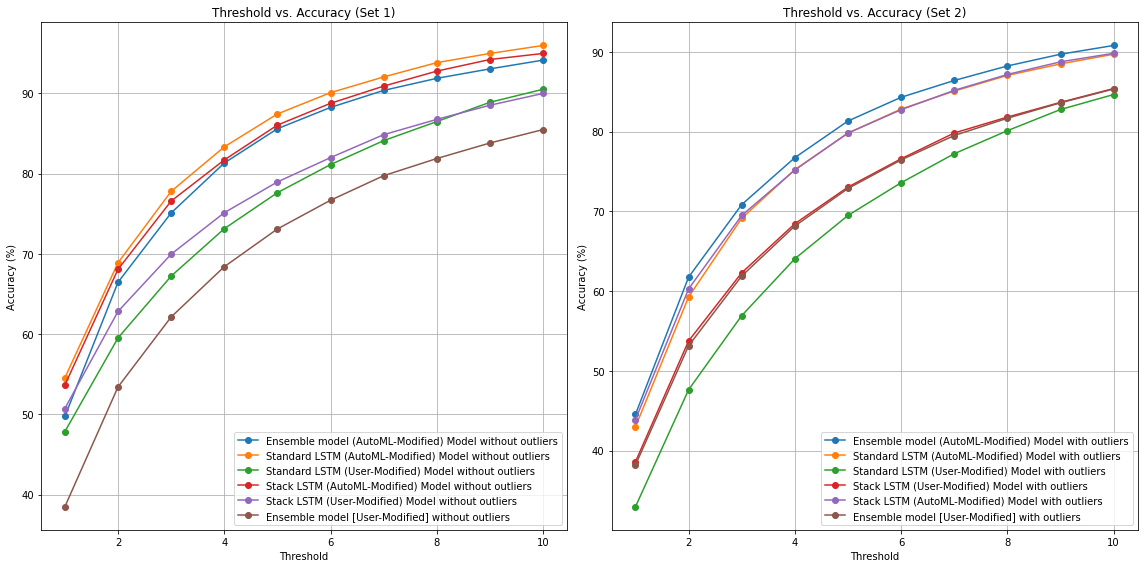

In [837]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first set of lines (two lines) in the first subplot
axs[0].plot(thresholds, accuracies_without_outliers_auto, label='Ensemble model (AutoML-Modified) Model without outliers', marker='o', linestyle='-')
axs[0].plot(thresholds, accuracies_hl, label='Standard LSTM (AutoML-Modified) Model without outliers', marker='o', linestyle='-')
axs[0].plot(thresholds, accuracies_cl, label='Standard LSTM (User-Modified) Model without outliers', marker='o', linestyle='-')
axs[0].plot(thresholds3, accuracies3, marker='o', linestyle='-', label="Stack LSTM (AutoML-Modified) Model without outliers")
axs[0].plot(thresholds3, accuracies_u, marker='o', linestyle='-', label="Stack LSTM (User-Modified) Model without outliers")
axs[0].plot(thresholds, accuracies_without_outliers_user, label='Ensemble model [User-Modified] without outliers', marker='o', linestyle='-')
# axs[0].plot(thresholds3, accuracies3, marker='o', linestyle='-', label="Stack LSTM (AutoML-Modified) Model without outliers")
# axs[0].plot(thresholds3, accuracies_u, marker='o', linestyle='-', label="Stack LSTM (User-Modified) Model without outliers")
# Add titles, labels, legend, and grid to the first subplot
axs[0].set_title("Threshold vs. Accuracy (Set 1)")
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Accuracy (%)")
axs[0].grid(True)
axs[0].legend()

# Plot the third set of lines (three lines) in the second subplot

axs[1].plot(thresholds, accuracies_with_outliers_auto, label='Ensemble model (AutoML-Modified) Model with outliers', marker='o', linestyle='-')
axs[1].plot(thresholds, accuracies_h, label='Standard LSTM (AutoML-Modified) Model with outliers', marker='o', linestyle='-')
axs[1].plot(thresholds, accuracies_C, label='Standard LSTM (User-Modified) Model with outliers', marker='o', linestyle='-')
axs[1].plot(thresholds_s, accuracies_s, marker='o', linestyle='-', label="Stack LSTM (User-Modified) Model with outliers")
axs[1].plot(thresholds2, accuracies2, marker='o', linestyle='-', label="Stack LSTM (AutoML-Modified) Model with outliers")
axs[1].plot(thresholds, accuracies_with_outliers_user, label='Ensemble model [User-Modified] with outliers', marker='o', linestyle='-')
# Add titles, labels, legend, and grid to the second subplot
axs[1].set_title("Threshold vs. Accuracy (Set 2)")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("Accuracy (%)")
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the two side-by-side subplots
plt.show()







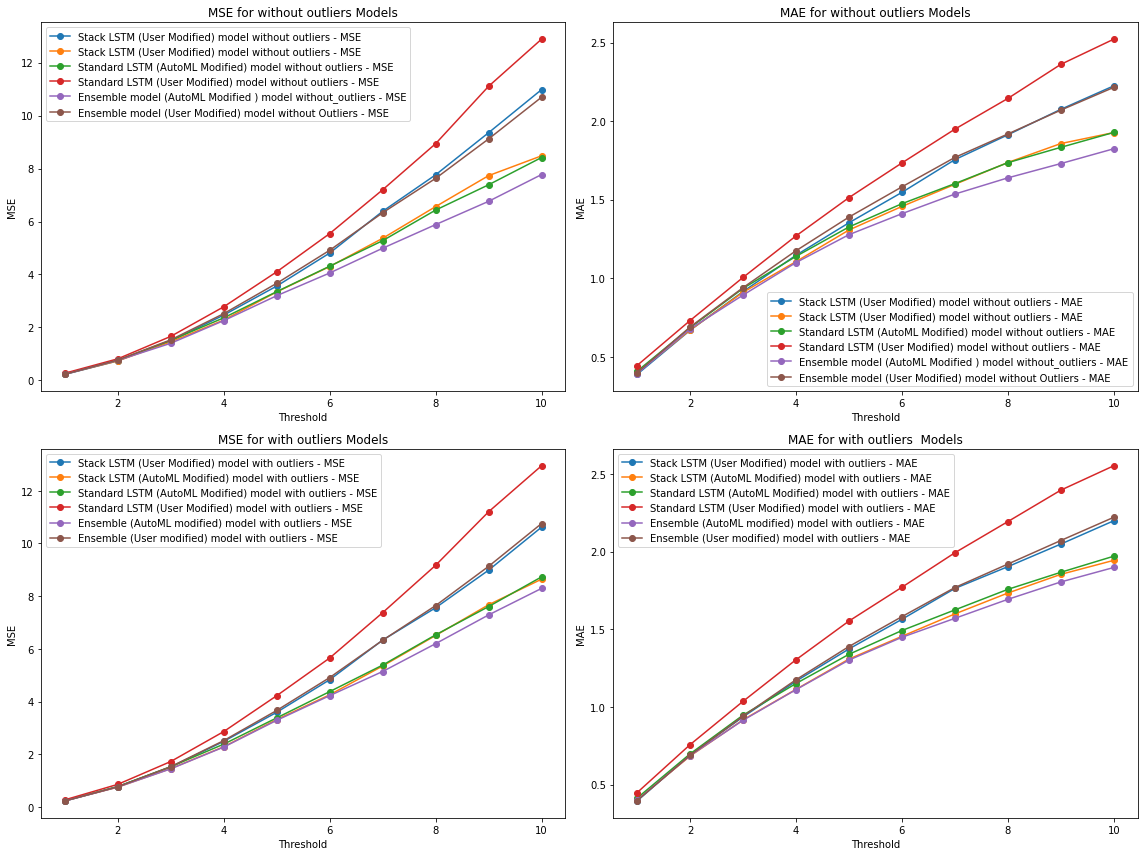

In [854]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store MSE and MAE values for different models
mse_values_with_outliers = [mse_values1,mse_values3,mse_values5, mse_values8,mse_values_with_outliers_auto,mse_values_with_outliers_user]  # Replace with your actual MSE values
mae_values_with_outliers = [mae_values1,mae_values3,mae_values5, mae_values8,mae_values_with_outliers_auto,mae_values_with_outliers_user]  # Replace with your actual MAE values
model_labels_with_outliers = ["Stack LSTM (User Modified) model with outliers", "Stack LSTM (AutoML Modified) model with outliers", "Standard LSTM (AutoML Modified) model with outliers", "Standard LSTM (User Modified) model with outliers","Ensemble (AutoML modified) model with outliers","Ensemble (User modified) model with outliers"]  # Replace with your actual model labels

mse_values_without_outliers = [mse_values2, mse_values4,mse_values6,mse_values7,mse_values_without_outliers_auto,mse_values_without_outliers_user]  # Replace with your actual MSE values
mae_values_without_outliers = [mae_values2, mae_values4,mae_values6,mae_values7,mae_values_without_outliers_auto,mae_values_without_outliers_user]  # Replace with your actual MAE values
model_labels_without_outliers = ["Stack LSTM (User Modified) model without outliers", "Stack LSTM (User Modified) model without outliers", "Standard LSTM (AutoML Modified) model without outliers", "Standard LSTM (User Modified) model without outliers","Ensemble model (AutoML Modified ) model without_outliers","Ensemble model (User Modified) model without Outliers"]  # Replace with your actual model labels

# Create subplots for MSE and MAE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot MSE and MAE for the first set of models
for i in range(6):
    thresholds = range(1, len(mse_values_without_outliers[i]) + 1)  # Use the actual number of thresholds
    axes[0, 0].plot(thresholds, mse_values_without_outliers[i], marker='o', linestyle='-', label=f"{model_labels_without_outliers[i]} - MSE")
    axes[0, 1].plot(thresholds, mae_values_without_outliers[i], marker='o', linestyle='-', label=f"{model_labels_without_outliers[i]} - MAE")

# Plot MSE and MAE for the second set of models
for i in range(6):
    thresholds = range(1, len(mse_values_with_outliers[i]) + 1)  # Use the actual number of thresholds
    axes[1, 0].plot(thresholds, mse_values_with_outliers[i], marker='o', linestyle='-', label=f"{model_labels_with_outliers[i]} - MSE")
    axes[1, 1].plot(thresholds, mae_values_with_outliers[i], marker='o', linestyle='-', label=f"{model_labels_with_outliers[i]} - MAE")

# Set titles and labels for the subplots
axes[0, 0].set_title("MSE for without outliers Models")
axes[0, 0].set_xlabel("Threshold")
axes[0, 0].set_ylabel("MSE")
axes[0, 0].legend()

axes[0, 1].set_title("MAE for without outliers Models")
axes[0, 1].set_xlabel("Threshold")
axes[0, 1].set_ylabel("MAE")
axes[0, 1].legend()

axes[1, 0].set_title("MSE for with outliers Models")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("MSE")
axes[1, 0].legend()

axes[1, 1].set_title("MAE for with outliers  Models")
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("MAE")
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the merged MSE and MAE plots
plt.show()


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_11388\3297248802.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(["Data 1 with Outliers", "Settlement Point Price", "Data 3 without Outliers"])


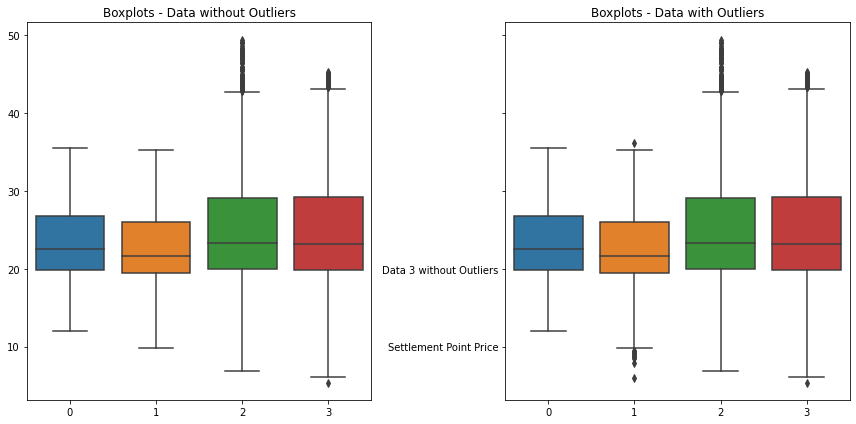

In [862]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
# User modified data
data2_without_outliers = predictions_cl
data1_without_outliers=predictions_outliers
data3_without_outliers = predictions_b_outliers
data4_without_outliers = predictions_hl
# Data with outliers

data1_with_outliers = predictions['Settlement Point Price']
data2_with_outliers = predictions_C['Settlement Point Price']
data3_with_outliers = predictions_b['Settlement Point Price']
data4_with_outliers = predictions_h['Settlement Point Price']

# Create a figure with two sets of subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set of boxplots in the first subplot (without outliers)
sns.boxplot(data=[data1_without_outliers,data2_without_outliers,data3_without_outliers ,data4_without_outliers], ax=axs[0])
axs[0].set_title("Boxplots - Data without Outliers")


# Plot the second set of boxplots in the second subplot (with outliers)
sns.boxplot(data=[data1_with_outliers, data2_with_outliers, data3_without_outliers,data4_without_outliers], ax=axs[1])
axs[1].set_title("Boxplots - Data with Outliers")
axs[1].set_yticklabels(["Data 1 with Outliers", "Settlement Point Price", "Data 3 without Outliers"])

# Adjust spacing between subplots
plt.tight_layout()

# Display the two sets of boxplots side by side
plt.show()
